In [4]:
# ===========================
# SISTEMA DE PREDICCIÓN DE CORNERS - OPTIMIZADO PARA APUESTAS (VERSIÓN COMPLETA)
# ===========================

import numpy as np
import pandas as pd
import joblib
from scipy.stats import poisson

# ===========================
# 1. CARGAR MODELO Y SCALER
# ===========================

print("\n" + "=" * 80)
print("🎯 SISTEMA DE PREDICCIÓN DE CORNERS PARA APUESTAS (VERSIÓN AVANZADA)")
print("=" * 80)

xgb_model = joblib.load('xgboost_corners_optimized_v2_6_leagues.pkl')  # ✅ CAMBIO: versión v2
scaler = joblib.load('scaler_corners_xgb_v2_6_leagues.pkl')

print("✅ Modelo cargado correctamente")
print(f"   Features esperadas: {len(scaler.feature_names_in_)}")

# ===========================
# 2. FUNCIONES AUXILIARES (IGUAL)
# ===========================

def calcular_probabilidades_poisson(lambda_pred, rango_inferior=5, rango_superior=5):
    """Calcula probabilidades usando distribución de Poisson"""
    
    valor_central = int(round(lambda_pred))
    valores_analizar = range(
        max(0, valor_central - rango_inferior),
        valor_central + rango_superior + 1
    )
    
    probabilidades_exactas = {}
    for k in valores_analizar:
        prob = poisson.pmf(k, lambda_pred) * 100
        probabilidades_exactas[k] = prob
    
    # ✅ CORRECCIÓN: MISMAS LÍNEAS PARA OVER Y UNDER
    lines = [7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
    
    probabilidades_over = {}
    for linea in lines:
        prob_over = (1 - poisson.cdf(linea, lambda_pred)) * 100
        probabilidades_over[linea] = prob_over
    
    probabilidades_under = {}
    for linea in lines:  # ✅ CAMBIO: usar la misma lista
        prob_under = poisson.cdf(linea, lambda_pred) * 100
        probabilidades_under[linea] = prob_under
    
    return {
        'exactas': probabilidades_exactas,
        'over': probabilidades_over,
        'under': probabilidades_under
    }

def clasificar_confianza(prob):
    """Clasifica la confianza según probabilidad"""
    if prob >= 66:
        return "ALTA ✅"
    elif prob >= 55:
        return "MEDIA ⚠️"
    else:
        return "BAJA ❌"

# ===========================
# 3. ✅ NUEVA FUNCIÓN GET_AVERAGE CON MÉTRICAS AVANZADAS
# ===========================

def get_average(df, is_team=False, lst_avg=None):
    """Calcula promedios de estadísticas (VERSIÓN COMPLETA)"""
    
    if len(df) == 0:
        if is_team:
            # ✅ Retornar 23 valores (métricas avanzadas)
            return (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        return (0, 0, 0, 0, 0, 0, 0, 0, 0)
    
    if is_team:
        # ===========================
        # ESTADÍSTICAS BÁSICAS (NORMALIZADAS)
        # ===========================
        avg_cross = (df['Performance_Crs'].sum() / len(df)) - lst_avg[3]
        avg_att_3rd = (df['Touches_Att 3rd'].sum() / len(df)) - lst_avg[4]
        avg_sca = (df['SCA Types_SCA'].sum() / len(df)) - lst_avg[2]
        avg_xg = (df['Expected_xG'].sum() / len(df)) - lst_avg[1]
        
        # ✅ VARIANZA DE CORNERS
        var_ck = df['Pass Types_CK'].var() if len(df) > 1 else 0
        avg_ck = (df['Pass Types_CK'].sum() / len(df)) - lst_avg[8]
        
        avg_poss = (df['Poss'].sum() / len(df)) - 50
        avg_gf = (df['GF'].sum() / len(df)) - lst_avg[5]
        avg_ga = (df['GA'].sum() / len(df)) - lst_avg[6]
        
        # ===========================
        # MÉTRICAS OFENSIVAS AVANZADAS
        # ===========================
        total_sh = df['Standard_Sh'].sum()
        sh_accuracy = (df['Standard_SoT'].sum() / total_sh) if total_sh > 0 else 0
        xg_shot = (df['Expected_xG'].sum() / total_sh) if total_sh > 0 else 0
        
        total_touches = df['Touches_Touches'].sum()
        attacking_presence = (df['Touches_Att 3rd'].sum() / total_touches) if total_touches > 0 else 0
        
        total_poss = df['Poss'].sum()
        possession_shot = (total_sh / total_poss) if total_poss > 0 else 0
        
        # ===========================
        # MÉTRICAS DE CREACIÓN
        # ===========================
        total_passes = df['Total_Att'].sum()
        progressive_pass_ratio = (df['PrgP'].sum() / total_passes) if total_passes > 0 else 0
        final_third_involvement = (df['1/3'].sum() / total_passes) if total_passes > 0 else 0
        
        total_sca = df['SCA Types_SCA'].sum()
        assist_sca = (df['Ast'].sum() / total_sca) if total_sca > 0 else 0
        creative_efficiency = (total_sca / total_poss) if total_poss > 0 else 0
        
        # ===========================
        # MÉTRICAS DEFENSIVAS
        # ===========================
        total_tackles = df['Tackles_Tkl'].sum()
        high_press_intensity = (df['Tackles_Att 3rd'].sum() / total_tackles) if total_tackles > 0 else 0
        interception_tackle = (df['Int'].sum() / total_tackles) if total_tackles > 0 else 0
        
        total_defensive_actions = total_tackles + df['Int'].sum()
        clearance_ratio = (df['Clr'].sum() / total_defensive_actions) if total_defensive_actions > 0 else 0
        
        # ===========================
        # MÉTRICAS DE POSESIÓN
        # ===========================
        total_carries = df['Carries_Carries'].sum()
        progressive_carry_ratio = (df['Carries_PrgC'].sum() / total_carries) if total_carries > 0 else 0
        
        total_prog_passes = df['PrgP'].sum()
        carry_pass_balance = (df['Carries_PrgC'].sum() / total_prog_passes) if total_prog_passes > 0 else 0
        
        # ===========================
        # ÍNDICES COMPUESTOS
        # ===========================
        avg_gf_raw = df['GF'].mean()
        avg_xg_raw = df['Expected_xG'].mean()
        avg_sot = df['Standard_SoT'].mean()
        avg_sh = df['Standard_Sh'].mean()
        offensive_index = (avg_gf_raw + avg_xg_raw) * (avg_sot / avg_sh) if avg_sh > 0 else 0
        
        avg_prgp = df['PrgP'].mean()
        avg_prgc = df['Carries_PrgC'].mean()
        avg_poss_raw = df['Poss'].mean()
        transition_index = ((avg_prgp + avg_prgc) / avg_poss_raw) if avg_poss_raw > 0 else 0
        
        # ✅ RETORNAR 23 VALORES
        return (
            avg_ck,           # 0
            var_ck,           # 1 - ✅ NUEVO
            avg_xg,           # 2
            avg_sca,          # 3
            avg_cross,        # 4
            avg_poss,         # 5
            avg_att_3rd,      # 6
            avg_gf,           # 7
            avg_ga,           # 8
            sh_accuracy,      # 9
            xg_shot,          # 10
            attacking_presence,  # 11
            possession_shot,  # 12
            progressive_pass_ratio,  # 13
            final_third_involvement,  # 14
            assist_sca,       # 15
            creative_efficiency,  # 16
            high_press_intensity,  # 17
            interception_tackle,  # 18
            clearance_ratio,  # 19
            progressive_carry_ratio,  # 20
            carry_pass_balance,  # 21
            offensive_index,  # 22
            transition_index  # 23
        )
    
    # ===========================
    # PROMEDIOS DE LIGA (is_team=False)
    # ===========================
    avg_cross = df['Performance_Crs'].mean()
    avg_att_3rd = df['Touches_Att 3rd'].mean()
    avg_sca = df['SCA Types_SCA'].mean()
    avg_xg = df['Expected_xG'].mean()
    var_ck = df['Pass Types_CK'].var() if len(df) > 1 else 0
    avg_ck = df['Pass Types_CK'].mean()
    avg_gf = df['GF'].mean()
    avg_ga = df['GA'].mean()
    avg_sh = df['Standard_Sh'].mean() if 'Standard_Sh' in df.columns else 0
    
    return (
        var_ck,      # 0
        avg_xg,      # 1
        avg_sca,     # 2
        avg_cross,   # 3
        avg_att_3rd, # 4
        avg_gf,      # 5
        avg_ga,      # 6
        avg_sh,      # 7
        avg_ck       # 8
    )

# ===========================
# 4. ✅ NUEVA FUNCIÓN GET_TEAM_PPP
# ===========================

def get_points_from_result(result):
    """Convierte resultado (W/D/L) a puntos"""
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

def get_team_ppp(df, team, season, round_num, league=None):
    """Calcula puntos por partido (PPP) de un equipo"""
    team_matches = df[
        (df['team'] == team) & 
        (df['season'] == season) & 
        (df['round'] < round_num)
    ]
    
    if league is not None:
        team_matches = team_matches[team_matches['league'] == league]
    
    if len(team_matches) == 0:
        return 0.0
    
    total_points = team_matches['result'].apply(get_points_from_result).sum()
    ppp = total_points / len(team_matches)
    
    return ppp

def get_ppp_difference(df, local, away, season, round_num, league=None):
    """Calcula diferencia de PPP entre local y visitante"""
    local_ppp = get_team_ppp(df, local, season, round_num, league)
    away_ppp = get_team_ppp(df, away, season, round_num, league)
    return local_ppp - away_ppp


# ===========================
# 5. ✅ FUNCIÓN PRINCIPAL DE PREDICCIÓN (ACTUALIZADA)
# ===========================

def predecir_corners(local, visitante, jornada, temporada="2526", league_code="ESP"):
    """
    Predice corners totales con análisis completo para apuestas
    
    Args:
        local: Equipo local
        visitante: Equipo visitante
        jornada: Número de jornada
        temporada: Temporada (formato "2526")
        league_code: Código de liga ("ESP", "GER", "FRA", "ITA", "NED")
    """
    
    print(f"\n{'='*80}")
    print(f"🏟️  {local} vs {visitante}")
    print(f"📅 Temporada {temporada} | Jornada {jornada} | Liga: {league_code}")
    print(f"{'='*80}")
    
    if jornada < 5:
        return {
            "error": "❌ Se necesitan al menos 5 jornadas previas",
            "prediccion": None
        }
    
    try:
        # ===========================
        # EXTRAER FEATURES (igual que antes)
        # ===========================
        
        lst_avg = get_average(
            df_database[
                (df_database['season'] == temporada) & 
                (df_database['round'] < jornada) &
                (df_database['league'] == league_code)
            ],
            is_team=False
        )
        
        (team1_home, team1_away, team1_opp_home, team1_opp_away,
         team2_home, team2_away, team2_opp_home, team2_opp_away) = get_dataframes(
            df_database, temporada, jornada, local, visitante, league=league_code
        )
        
        index = lst_years.index(temporada)
        result = lst_years[:index+1]
        team1_h2h, team2_h2h = get_head_2_head(
            df_database, local, visitante, seasons=result, league=league_code
        )
        
        local_ppp = get_team_ppp(df_database, local, temporada, jornada, league=league_code)
        away_ppp = get_team_ppp(df_database, visitante, temporada, jornada, league=league_code)
        ppp_diff = local_ppp - away_ppp
        
        # ===========================
        # CONSTRUIR DICCIONARIO DE FEATURES (igual que antes)
        # ===========================
        
        def create_line(df, is_form=True, is_team=False, use_advanced=True):
            if is_form:
                df = df[-6:]
            if use_advanced:
                return get_average(df, is_team, lst_avg)
            else:
                result = get_average(df, is_team, lst_avg)
                return result[:9]
        
        dic_features = {}
        
        dic_features['ppp_local'] = (local_ppp,)
        dic_features['ppp_away'] = (away_ppp,)
        dic_features['ppp_difference'] = (ppp_diff,)
        
        dic_features['lst_team1_home_form'] = create_line(team1_home, True, True, use_advanced=True)
        dic_features['lst_team1_home_general'] = create_line(team1_home, False, True, use_advanced=True)
        dic_features['lst_team1_away_form'] = create_line(team1_away, True, True, use_advanced=True)
        dic_features['lst_team1_away_general'] = create_line(team1_away, False, True, use_advanced=True)
        
        dic_features['lst_team2_home_form'] = create_line(team2_home, True, True, use_advanced=True)
        dic_features['lst_team2_home_general'] = create_line(team2_home, False, True, use_advanced=True)
        dic_features['lst_team2_away_form'] = create_line(team2_away, True, True, use_advanced=True)
        dic_features['lst_team2_away_general'] = create_line(team2_away, False, True, use_advanced=True)
        
        dic_features['lst_team1_h2h'] = create_line(team1_h2h, False, True, use_advanced=True)
        dic_features['lst_team2_h2h'] = create_line(team2_h2h, False, True, use_advanced=True)
        
        dic_features['lst_team1_opp_away'] = create_line(team1_opp_away, False, True, use_advanced=False)
        dic_features['lst_team2_opp_home'] = create_line(team2_opp_home, False, True, use_advanced=False)
        
        league_dummies = {
            'league_ESP': 1 if league_code == 'ESP' else 0,
            'league_GER': 1 if league_code == 'GER' else 0,
            'league_FRA': 1 if league_code == 'FRA' else 0,
            'league_ITA': 1 if league_code == 'ITA' else 0,
            'league_NED': 1 if league_code == 'NED' else 0
        }
        
        for key, value in league_dummies.items():
            dic_features[key] = (value,)
        
        # ===========================
        # CONSTRUIR VECTOR DE FEATURES
        # ===========================
        
        lst_base_advanced = [
            "avg_ck", "var_ck", "xg", "sca", "cross", "poss", "att_3rd", "gf", "ga",
            "sh_accuracy", "xg_shot", "attacking_presence", "possession_shot",
            "progressive_pass_ratio", "final_third_involvement", "assist_sca", "creative_efficiency",
            "high_press_intensity", "interception_tackle", "clearance_ratio",
            "progressive_carry_ratio", "carry_pass_balance", "offensive_index", "transition_index"
        ]
        
        lst_base_original = [
            "var_ck", "xg", "sca", "cross", "poss", "att_3rd", "gf", "ga", "avg_ck"
        ]
        
        lst_features_values = []
        lst_features_names = []
        
        for key in dic_features:
            lst_features_values.extend(list(dic_features[key]))
            
            if key in ['ppp_local', 'ppp_away', 'ppp_difference']:
                lst_features_names.append(key)
            elif key.startswith('league_'):
                lst_features_names.append(key)
            elif key in ['lst_team1_opp_away', 'lst_team2_opp_home']:
                lst_features_names.extend([f"{key}_{col}" for col in lst_base_original])
            else:
                lst_features_names.extend([f"{key}_{col}" for col in lst_base_advanced])
        
        df_input = pd.DataFrame([lst_features_values], columns=lst_features_names)
        
        expected_features = scaler.feature_names_in_
        
        if len(df_input.columns) != len(expected_features):
            print(f"\n⚠️ ERROR: Número de features no coincide")
            print(f"   Esperadas: {len(expected_features)}")
            print(f"   Recibidas: {len(df_input.columns)}")
            return {"error": "Desajuste de features", "prediccion": None}
        
        df_input = df_input[expected_features]
        
        X_input_scaled = pd.DataFrame(
            scaler.transform(df_input), 
            columns=df_input.columns
        )
        
        # ===========================
        # PREDICCIÓN
        # ===========================
        
        prediccion = xgb_model.predict(X_input_scaled)[0]
        
        # ===========================
        # ✅ ANÁLISIS PROBABILÍSTICO CON POISSON
        # ===========================
        
        analisis = calcular_probabilidades_poisson(prediccion, rango_inferior=5, rango_superior=5)
        
        # ===========================
        # ESTADÍSTICAS DETALLADAS
        # ===========================
        
        local_ck_home = team1_home['Pass Types_CK'].mean() if len(team1_home) > 0 else 0
        local_xg_home = team1_home['Expected_xG'].mean() if len(team1_home) > 0 else 0
        local_poss_home = team1_home['Poss'].mean() if len(team1_home) > 0 else 0
        
        away_ck_away = team2_away['Pass Types_CK'].mean() if len(team2_away) > 0 else 0
        away_xg_away = team2_away['Expected_xG'].mean() if len(team2_away) > 0 else 0
        away_poss_away = team2_away['Poss'].mean() if len(team2_away) > 0 else 0
        
        local_ck_received = team1_opp_home['Pass Types_CK'].mean() if len(team1_opp_home) > 0 else 0
        away_ck_received = team2_opp_away['Pass Types_CK'].mean() if len(team2_opp_away) > 0 else 0
        
        partido_ck_esperado = local_ck_home + away_ck_away
        
        h2h_ck_local = team1_h2h['Pass Types_CK'].mean() if len(team1_h2h) > 0 else 0
        h2h_ck_away = team2_h2h['Pass Types_CK'].mean() if len(team2_h2h) > 0 else 0
        h2h_total = h2h_ck_local + h2h_ck_away
        
        # ===========================
        # ✅ MOSTRAR RESULTADOS CON PROBABILIDADES
        # ===========================
        
        print(f"\n🎲 PREDICCIÓN MODELO: {prediccion:.2f} corners totales")
        print(f"   PPP: {local} ({local_ppp:.2f}) vs {visitante} ({away_ppp:.2f}) | Diff: {ppp_diff:+.2f}")
        
        print(f"\n📊 ESTADÍSTICAS HISTÓRICAS:")
        print(f"   {local} (Casa): {local_ck_home:.1f} CK/partido | xG: {local_xg_home:.2f} | Poss: {local_poss_home:.1f}%")
        print(f"   {visitante} (Fuera): {away_ck_away:.1f} CK/partido | xG: {away_xg_away:.2f} | Poss: {away_poss_away:.1f}%")
        print(f"   Corners recibidos: {local} ({local_ck_received:.1f}) | {visitante} ({away_ck_received:.1f})")
        print(f"   Total esperado (suma): {partido_ck_esperado:.1f} corners")
        
        if len(team1_h2h) > 0 or len(team2_h2h) > 0:
            print(f"\n🔄 HEAD TO HEAD (últimos {max(len(team1_h2h), len(team2_h2h))} partidos):")
            print(f"   {local}: {h2h_ck_local:.1f} CK/partido")
            print(f"   {visitante}: {h2h_ck_away:.1f} CK/partido")
            print(f"   Promedio total: {h2h_total:.1f} corners")
        
        # ===========================
        # ✅ MOSTRAR PROBABILIDADES EXACTAS
        # ===========================
        
        valor_mas_probable = max(analisis['exactas'].items(), key=lambda x: x[1])
        
        print(f"\n📈 PROBABILIDADES EXACTAS (Poisson):")
        for k in sorted(analisis['exactas'].keys()):
            prob = analisis['exactas'][k]
            bar = '█' * int(prob / 2)
            marca = ' ⭐' if k == valor_mas_probable[0] else ''
            print(f"   {k:2d} corners: {prob:5.2f}% {bar}{marca}")
        
        print(f"\n✅ Valor más probable: {valor_mas_probable[0]} corners ({valor_mas_probable[1]:.2f}%)")
        
        # ✅ RANGO DE 80% CONFIANZA
        probs_sorted = sorted(analisis['exactas'].items(), key=lambda x: x[1], reverse=True)
        cumsum = 0
        rango_80 = []
        for val, prob in probs_sorted:
            cumsum += prob
            rango_80.append(val)
            if cumsum >= 80:
                break
        
        print(f"📊 Rango 80% confianza: {min(rango_80)}-{max(rango_80)} corners")
        
        # ===========================
        # ✅ MOSTRAR OVER/UNDER CON CUOTAS IMPLÍCITAS
        # ===========================
        
        print(f"\n🎯 ANÁLISIS OVER/UNDER:")
        print(f"{'Línea':<10} {'Prob Over':<12} {'Cuota Impl':<12} {'Confianza':<15} {'Prob Under':<12} {'Cuota Impl':<12}")
        print("-" * 85)
        
        for linea in [7.5, 8.5, 9.5, 10.5, 11.5, 12.5]:
            prob_over = analisis['over'][linea]
            prob_under = analisis['under'][linea]
            
            # Cuotas implícitas (inverso de probabilidad en decimal)
            cuota_impl_over = 100 / prob_over if prob_over > 0 else 999
            cuota_impl_under = 100 / prob_under if prob_under > 0 else 999
            
            conf_over = clasificar_confianza(prob_over)
            
            print(f"O/U {linea:<5} {prob_over:6.2f}%     @{cuota_impl_over:5.2f}      {conf_over:<15} {prob_under:6.2f}%     @{cuota_impl_under:5.2f}")
        
        # ===========================
        # ✅ RECOMENDACIONES CON CUOTAS
        # ===========================
        
        print(f"\n💡 RECOMENDACIONES DE APUESTA:")
        
        mejores_over = [(l, p) for l, p in analisis['over'].items() if p >= 55]
        mejores_under = [(l, p) for l, p in analisis['under'].items() if p >= 55]
        
        if mejores_over:
            print(f"\n✅ OVER con confianza MEDIA/ALTA:")
            for linea, prob in sorted(mejores_over, key=lambda x: x[1], reverse=True):
                cuota_impl = 100 / prob
                conf = clasificar_confianza(prob)
                print(f"   • Over {linea}: {prob:.2f}% (Cuota justa: @{cuota_impl:.2f}) - {conf}")
        
        if mejores_under:
            print(f"\n✅ UNDER con confianza MEDIA/ALTA:")
            for linea, prob in sorted(mejores_under, key=lambda x: x[1], reverse=True):
                cuota_impl = 100 / prob
                conf = clasificar_confianza(prob)
                print(f"   • Under {linea}: {prob:.2f}% (Cuota justa: @{cuota_impl:.2f}) - {conf}")
        
        if not mejores_over and not mejores_under:
            print(f"   ⚠️ No hay apuestas con confianza MEDIA o superior")
        
        # ===========================
        # ✅ ANÁLISIS DE RIESGO
        # ===========================
        
        df_varianza_temp = analizar_fiabilidad_equipos(df_database, temporada=temporada, min_partidos=3)
        riesgo = obtener_fiabilidad_partido(local, visitante, df_varianza_temp)

        print(f"\n⚠️ ANÁLISIS DE RIESGO:")
        print(f"   Local ({local}): {riesgo['nivel_local']} (CV: {riesgo['cv_local']:.1f}%)")
        print(f"   Away ({visitante}): {riesgo['nivel_away']} (CV: {riesgo['cv_away']:.1f}%)")
        print(f"   🎲 FIABILIDAD PARTIDO: {riesgo['fiabilidad']} (Score: {riesgo['score_promedio']:.1f})")
        print(f"   💡 {riesgo['mensaje']}")
        
        # ===========================
        # RETORNAR DICCIONARIO COMPLETO
        # ===========================
        
        return {
            "prediccion": round(prediccion, 2),
            "local": local,
            "visitante": visitante,
            "ppp_local": local_ppp,
            "ppp_away": away_ppp,
            "ppp_diff": ppp_diff,
            "riesgo": riesgo,
            "stats": {
                "local_ck": local_ck_home,
                "away_ck": away_ck_away,
                "local_ck_received": local_ck_received,
                "away_ck_received": away_ck_received,
                "h2h_total": h2h_total,
                "partido_esperado": partido_ck_esperado
            },
            "probabilidades_exactas": analisis['exactas'],
            "probabilidades_over": analisis['over'],
            "probabilidades_under": analisis['under'],
            "valor_mas_probable": valor_mas_probable[0],
            "prob_mas_probable": valor_mas_probable[1],
            "rango_80": (min(rango_80), max(rango_80))
        }
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return {"error": str(e), "prediccion": None}

print("\n✅ Sistema listo con probabilidades Poisson y cuotas implícitas")


🎯 SISTEMA DE PREDICCIÓN DE CORNERS PARA APUESTAS (VERSIÓN AVANZADA)
✅ Modelo cargado correctamente
   Features esperadas: 266

✅ Sistema listo con probabilidades Poisson y cuotas implícitas


In [21]:

"""("Getafe", "Girona"),
("Villarreal", "Rayo Vallecano"),
("Atlético Madrid", "Sevilla"),
("Real Sociedad", "Athletic Club"),
("Real Madrid", "Valencia"),

("Bayern", "Leverkusen"),
("Augsburgo", "Dortmund"),
    ("Leipzig", "Stuttgart"),
("Mainz", "Werder Bremen"),

("Heidenheim", "Frankfurt"),
("St. Pauli", "Mönchengladbach"),
("Union Berlin", "Friburgo"),
"""
partidos = [
    
    ("Levante", "Celta Vigo"),
    ("Alavés", "Espanyol"),
    ("Barcelona", "Elche"),
    ("Betis", "Mallorca"),
    ("Oviedo", "Osasuna")
]

for i in partidos:
    resultado = predecir_corners(
    local=i[0],
    visitante=i[1], 
    jornada=11,
    temporada="2526",
    league_code="ESP"  # ✅ NUEVO PARÁMETRO
)
    
partidos = [
    ("Köln", "Hamburger"),
    ("Wolfsburg", "Hoffenheim"),
]

for i in partidos:
    resultado = predecir_corners(
    local=i[0],
    visitante=i[1], 
    jornada=9,
    temporada="2526",
    league_code="GER"  # ✅ NUEVO PARÁMETRO
)
    

partidos = [
    ("Hellas Verona", "Inter"),
    ("Fiorentina", "Lecce"),
    ("Torino", "Pisa"),
    ("Parma", "Bologna"),
    ("Milan", "Roma"),
]

for i in partidos:
    resultado = predecir_corners(
    local=i[0],
    visitante=i[1], 
    jornada=10,
    temporada="2526",
    league_code="ITA"  # ✅ NUEVO PARÁMETRO
)
    
partidos = [
    ("Heracles Almelo", "Zwolle"),
    ("Groningen", "Twente"),
    ("Sparta R'dam", "AZ Alkmaar"),
    ("Utrecht", "NEC Nijmegen")
]

for i in partidos:
    resultado = predecir_corners(
    local=i[0],
    visitante=i[1], 
    jornada=11,
    temporada="2526",
    league_code="NED"  # ✅ NUEVO PARÁMETRO
)
    
partidos = [
    ("Toulouse", "Le Havre"),
    ("Lens", "Lorient"),
    ("Rennes", "Strasbourg"),
    ("Lille", "Angers"),
    ("Nantes", "Metz"),
    ("Lyon", "Brest")
]
    
for i in partidos:
    resultado = predecir_corners(
    local=i[0],
    visitante=i[1], 
    jornada=11,
    temporada="2526",
    league_code="FRA"  # ✅ NUEVO PARÁMETRO
)


🏟️  Levante vs Celta Vigo
📅 Temporada 2526 | Jornada 11 | Liga: ESP

🎲 PREDICCIÓN MODELO: 7.41 corners totales
   PPP: Levante (0.90) vs Celta Vigo (1.00) | Diff: -0.10

📊 ESTADÍSTICAS HISTÓRICAS:
   Levante (Casa): 4.0 CK/partido | xG: 1.28 | Poss: 36.0%
   Celta Vigo (Fuera): 3.8 CK/partido | xG: 1.03 | Poss: 42.5%
   Corners recibidos: Levante (6.5) | Celta Vigo (4.7)
   Total esperado (suma): 7.8 corners

🔄 HEAD TO HEAD (últimos 3 partidos):
   Levante: 4.0 CK/partido
   Celta Vigo: 3.7 CK/partido
   Promedio total: 7.7 corners

📈 PROBABILIDADES EXACTAS (Poisson):
    2 corners:  1.67% 
    3 corners:  4.11% ██
    4 corners:  7.61% ███
    5 corners: 11.28% █████
    6 corners: 13.92% ██████
    7 corners: 14.73% ███████ ⭐
    8 corners: 13.64% ██████
    9 corners: 11.22% █████
   10 corners:  8.31% ████
   11 corners:  5.60% ██
   12 corners:  3.45% █

✅ Valor más probable: 7 corners (14.73%)
📊 Rango 80% confianza: 4-10 corners

🎯 ANÁLISIS OVER/UNDER:
Línea      Prob Over    Cu

Traceback (most recent call last):
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 939, in _finalize_columns_and_data
    columns = _validate_or_indexify_columns(contents, columns)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 986, in _validate_or_indexify_columns
    raise AssertionError(
AssertionError: 266 columns passed, passed data had 264 columns

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Danie\AppData\Local\Temp\ipykernel_18308\3090270536.py", line 382, in predecir_corners
    df_input = pd.DataFrame([lst_features_values], columns=lst_features_names)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Pyt


🎲 PREDICCIÓN MODELO: 10.74 corners totales
   PPP: Wolfsburg (1.00) vs Hoffenheim (1.62) | Diff: -0.62

📊 ESTADÍSTICAS HISTÓRICAS:
   Wolfsburg (Casa): 4.8 CK/partido | xG: 1.40 | Poss: 46.5%
   Hoffenheim (Fuera): 5.2 CK/partido | xG: 2.00 | Poss: 51.0%
   Corners recibidos: Wolfsburg (8.0) | Hoffenheim (5.2)
   Total esperado (suma): 10.0 corners

🔄 HEAD TO HEAD (últimos 3 partidos):
   Wolfsburg: 6.7 CK/partido
   Hoffenheim: 4.0 CK/partido
   Promedio total: 10.7 corners

📈 PROBABILIDADES EXACTAS (Poisson):
    6 corners:  4.62% ██
    7 corners:  7.08% ███
    8 corners:  9.51% ████
    9 corners: 11.35% █████
   10 corners: 12.19% ██████ ⭐
   11 corners: 11.90% █████
   12 corners: 10.65% █████
   13 corners:  8.80% ████
   14 corners:  6.75% ███
   15 corners:  4.83% ██
   16 corners:  3.24% █

✅ Valor más probable: 10 corners (12.19%)
📊 Rango 80% confianza: 7-15 corners

🎯 ANÁLISIS OVER/UNDER:
Línea      Prob Over    Cuota Impl   Confianza       Prob Under   Cuota Impl  
-----

Traceback (most recent call last):
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 939, in _finalize_columns_and_data
    columns = _validate_or_indexify_columns(contents, columns)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 986, in _validate_or_indexify_columns
    raise AssertionError(
AssertionError: 266 columns passed, passed data had 264 columns

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Danie\AppData\Local\Temp\ipykernel_18308\3090270536.py", line 382, in predecir_corners
    df_input = pd.DataFrame([lst_features_values], columns=lst_features_names)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Pyt


⚠️ ANÁLISIS DE RIESGO:
   Local (Parma): BUENO ✅ (CV: 61.1%)
   Away (Bologna): ACEPTABLE 🟡 (CV: 43.3%)
   🎲 FIABILIDAD PARTIDO: ALTA ✅ (Score: 55.0)
   💡 ✅ BUEN PARTIDO PARA APOSTAR

🏟️  Milan vs Roma
📅 Temporada 2526 | Jornada 10 | Liga: ITA

🎲 PREDICCIÓN MODELO: 8.95 corners totales
   PPP: Milan (2.00) vs Roma (2.33) | Diff: -0.33

📊 ESTADÍSTICAS HISTÓRICAS:
   Milan (Casa): 4.8 CK/partido | xG: 1.38 | Poss: 53.0%
   Roma (Fuera): 5.8 CK/partido | xG: 1.25 | Poss: 58.5%
   Corners recibidos: Milan (5.0) | Roma (3.2)
   Total esperado (suma): 10.6 corners

🔄 HEAD TO HEAD (últimos 3 partidos):
   Milan: 3.3 CK/partido
   Roma: 4.7 CK/partido
   Promedio total: 8.0 corners

📈 PROBABILIDADES EXACTAS (Poisson):
    4 corners:  3.48% █
    5 corners:  6.22% ███
    6 corners:  9.28% ████
    7 corners: 11.85% █████
    8 corners: 13.25% ██████ ⭐
    9 corners: 13.17% ██████
   10 corners: 11.78% █████
   11 corners:  9.58% ████
   12 corners:  7.14% ███
   13 corners:  4.91% ██
   14 co

In [25]:
resultado = predecir_corners(
    local="Twente",
    visitante="Telstar", 
    jornada=11,
    temporada="2526",
    league_code="NED"  # ✅ NUEVO PARÁMETRO
)


🏟️  Twente vs Telstar
📅 Temporada 2526 | Jornada 11 | Liga: NED

❌ ERROR: 266 columns passed, passed data had 264 columns


Traceback (most recent call last):
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 939, in _finalize_columns_and_data
    columns = _validate_or_indexify_columns(contents, columns)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py", line 986, in _validate_or_indexify_columns
    raise AssertionError(
AssertionError: 266 columns passed, passed data had 264 columns

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\3882300319.py", line 382, in predecir_corners
    df_input = pd.DataFrame([lst_features_values], columns=lst_features_names)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Danie\AppData\Local\Programs\Python\Pyt

In [5]:
# ===========================
# SISTEMA AVANZADO DE DETECCIÓN DE PARTIDOS APOSTABLES
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def analizar_fiabilidad_equipos(df_database, temporada="2526", min_partidos=5):
    """
    Análisis completo de fiabilidad para apuestas de corners
    No solo varianza, sino consistencia, tendencias y patrones
    """
    
    df_temp = df_database[df_database['season'] == temporada].copy()
    resultados = []
    equipos = pd.concat([df_temp['team'], df_temp['opponent']]).unique()
    
    for equipo in equipos:
        # Partidos del equipo
        partidos_equipo = df_temp[df_temp['team'] == equipo]
        
        if len(partidos_equipo) < min_partidos:
            continue
        
        ck_sacados = partidos_equipo['Pass Types_CK'].values
        
        # ===========================
        # 1. MÉTRICAS DE VARIABILIDAD
        # ===========================
        media = ck_sacados.mean()
        std = ck_sacados.std()
        cv = (std / media * 100) if media > 0 else 0
        
        # ===========================
        # 2. MÉTRICAS DE CONSISTENCIA
        # ===========================
        
        # 2.1 Porcentaje de partidos cerca de la media (±2 corners)
        cerca_media = np.sum(np.abs(ck_sacados - media) <= 2) / len(ck_sacados) * 100
        
        # 2.2 Rachas (detectar equipos con "explosiones" de corners)
        cambios_bruscos = np.sum(np.abs(np.diff(ck_sacados)) > 4)
        pct_cambios_bruscos = cambios_bruscos / (len(ck_sacados) - 1) * 100
        
        # 2.3 Cuartiles (Q1, Q2=mediana, Q3)
        q1, q2, q3 = np.percentile(ck_sacados, [25, 50, 75])
        iqr = q3 - q1  # Rango intercuartílico (más robusto que std)
        
        # ===========================
        # 3. MÉTRICAS DE TENDENCIA
        # ===========================
        
        # 3.1 Tendencia lineal (¿mejora/empeora con el tiempo?)
        jornadas = np.arange(len(ck_sacados))
        slope, intercept, r_value, p_value, std_err = stats.linregress(jornadas, ck_sacados)
        
        # 3.2 Autocorrelación (¿resultado actual predice el siguiente?)
        if len(ck_sacados) > 2:
            autocorr = np.corrcoef(ck_sacados[:-1], ck_sacados[1:])[0, 1]
        else:
            autocorr = 0
        
        # ===========================
        # 4. MÉTRICAS DE OUTLIERS
        # ===========================
        
        # 4.1 Detección de valores atípicos (método IQR)
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = np.sum((ck_sacados < lower_bound) | (ck_sacados > upper_bound))
        pct_outliers = outliers / len(ck_sacados) * 100
        
        # 4.2 Z-score máximo
        z_scores = np.abs(stats.zscore(ck_sacados))
        max_z = z_scores.max()
        
        # ===========================
        # 5. MÉTRICAS DE RANGO
        # ===========================
        
        rango = ck_sacados.max() - ck_sacados.min()
        rango_normalizado = rango / media if media > 0 else 0
        
        # ===========================
        # 6. SCORE GLOBAL DE FIABILIDAD
        # ===========================
        
        # Penalizaciones (0-100, menor = peor)
        score_cv = max(0, 100 - cv * 2)  # CV alto = mala
        score_consistencia = cerca_media  # Más cerca de media = mejor
        score_cambios = max(0, 100 - pct_cambios_bruscos * 2)  # Cambios bruscos = malo
        score_outliers = max(0, 100 - pct_outliers * 3)  # Outliers = malo
        score_iqr = max(0, 100 - iqr * 10)  # IQR grande = malo
        
        # Score final (promedio ponderado)
        score_fiabilidad = (
            score_cv * 0.25 +
            score_consistencia * 0.30 +
            score_cambios * 0.20 +
            score_outliers * 0.15 +
            score_iqr * 0.10
        )
        
        # ===========================
        # 7. CLASIFICACIÓN MULTI-CRITERIO
        # ===========================
        
        # Clasificación basada en score
        if score_fiabilidad >= 70:
            nivel = "EXCELENTE ⭐⭐⭐"
            color = "#27ae60"
        elif score_fiabilidad >= 55:
            nivel = "BUENO ✅"
            color = "#2ecc71"
        elif score_fiabilidad >= 40:
            nivel = "ACEPTABLE 🟡"
            color = "#f39c12"
        elif score_fiabilidad >= 25:
            nivel = "REGULAR ⚠️"
            color = "#e67e22"
        else:
            nivel = "EVITAR ⛔"
            color = "#e74c3c"
        
        resultados.append({
            'Equipo': equipo,
            'Partidos': len(ck_sacados),
            
            # Estadísticas básicas
            'Media_CK': round(media, 2),
            'Mediana_CK': round(q2, 2),
            'Std_CK': round(std, 2),
            'CV_%': round(cv, 1),
            
            # Consistencia
            'Pct_Cerca_Media': round(cerca_media, 1),
            'Cambios_Bruscos_%': round(pct_cambios_bruscos, 1),
            'IQR': round(iqr, 2),
            
            # Rango
            'Rango': int(rango),
            'Rango_Norm': round(rango_normalizado, 2),
            'Min': int(ck_sacados.min()),
            'Max': int(ck_sacados.max()),
            
            # Outliers
            'Outliers': int(outliers),
            'Pct_Outliers': round(pct_outliers, 1),
            'Max_ZScore': round(max_z, 2),
            
            # Tendencia
            'Tendencia_Slope': round(slope, 3),
            'Autocorr': round(autocorr, 3),
            
            # Score y clasificación
            'Score_Fiabilidad': round(score_fiabilidad, 1),
            'Nivel': nivel,
            'Color': color
        })
    
    df_resultado = pd.DataFrame(resultados)
    df_resultado = df_resultado.sort_values('Score_Fiabilidad', ascending=False)
    
    return df_resultado


def mostrar_analisis_fiabilidad(df_analisis, top_n=10):
    """
    Muestra el análisis completo de fiabilidad
    """
    
    print("\n" + "=" * 120)
    print("🎯 ANÁLISIS DE FIABILIDAD PARA APUESTAS - CORNERS")
    print("=" * 120)
    
    # TOP EQUIPOS FIABLES
    print(f"\n⭐ TOP {top_n} EQUIPOS MÁS FIABLES")
    print("-" * 120)
    
    top_fiables = df_analisis.head(top_n)
    
    for idx, row in top_fiables.iterrows():
        print(f"\n{row['Equipo']:25s} | {row['Nivel']:20s} | Score: {row['Score_Fiabilidad']:.1f}")
        print(f"  📊 Media: {row['Media_CK']:.1f} | Mediana: {row['Mediana_CK']:.1f} | CV: {row['CV_%']:.1f}%")
        print(f"  ✅ {row['Pct_Cerca_Media']:.1f}% cerca de media | IQR: {row['IQR']:.1f}")
        print(f"  ⚠️ Cambios bruscos: {row['Cambios_Bruscos_%']:.1f}% | Outliers: {row['Pct_Outliers']:.1f}%")
        print(f"  📈 Rango: {row['Min']}-{row['Max']} ({row['Rango']} corners)")
    
    # TOP EQUIPOS NO FIABLES
    print(f"\n\n⛔ TOP {top_n} EQUIPOS MENOS FIABLES")
    print("-" * 120)
    
    top_no_fiables = df_analisis.tail(top_n)
    
    for idx, row in top_no_fiables.iterrows():
        print(f"\n{row['Equipo']:25s} | {row['Nivel']:20s} | Score: {row['Score_Fiabilidad']:.1f}")
        print(f"  📊 Media: {row['Media_CK']:.1f} | Mediana: {row['Mediana_CK']:.1f} | CV: {row['CV_%']:.1f}%")
        print(f"  ❌ Solo {row['Pct_Cerca_Media']:.1f}% cerca de media | IQR: {row['IQR']:.1f}")
        print(f"  ⚠️ Cambios bruscos: {row['Cambios_Bruscos_%']:.1f}% | Outliers: {row['Pct_Outliers']:.1f}%")
    
    # ESTADÍSTICAS GENERALES
    print(f"\n\n📊 DISTRIBUCIÓN POR NIVEL DE FIABILIDAD")
    print("-" * 120)
    print(df_analisis['Nivel'].value_counts())
    
    print(f"\n📈 ESTADÍSTICAS DE SCORE:")
    print(f"  Media: {df_analisis['Score_Fiabilidad'].mean():.1f}")
    print(f"  Mediana: {df_analisis['Score_Fiabilidad'].median():.1f}")
    print(f"  Score máximo: {df_analisis['Score_Fiabilidad'].max():.1f}")
    print(f"  Score mínimo: {df_analisis['Score_Fiabilidad'].min():.1f}")


def obtener_fiabilidad_partido(local, visitante, df_analisis):
    """
    Evalúa la fiabilidad de un partido específico
    """
    
    datos_local = df_analisis[df_analisis['Equipo'] == local]
    datos_away = df_analisis[df_analisis['Equipo'] == visitante]
    
    if datos_local.empty or datos_away.empty:
        return {
            'fiabilidad': 'DESCONOCIDO',
            'score': 0,
            'mensaje': '⚠️ Datos insuficientes'
        }
    
    score_local = datos_local['Score_Fiabilidad'].values[0]
    score_away = datos_away['Score_Fiabilidad'].values[0]
    score_promedio = (score_local + score_away) / 2
    
    # Clasificación del partido
    if score_promedio >= 65:
        fiabilidad = "MUY ALTA ⭐⭐⭐"
        mensaje = "✅ EXCELENTE PARTIDO PARA APOSTAR"
    elif score_promedio >= 50:
        fiabilidad = "ALTA ✅"
        mensaje = "✅ BUEN PARTIDO PARA APOSTAR"
    elif score_promedio >= 35:
        fiabilidad = "MEDIA 🟡"
        mensaje = "🟡 APOSTAR CON PRECAUCIÓN"
    else:
        fiabilidad = "BAJA ⛔"
        mensaje = "⛔ EVITAR APUESTA"
    
    return {
        'fiabilidad': fiabilidad,
        'score_local': score_local,
        'score_away': score_away,
        'score_promedio': score_promedio,
        'nivel_local': datos_local['Nivel'].values[0],
        'nivel_away': datos_away['Nivel'].values[0],
        'mensaje': mensaje,
        
        # Datos adicionales útiles
        'cv_local': datos_local['CV_%'].values[0],
        'cv_away': datos_away['CV_%'].values[0],
        'consistencia_local': datos_local['Pct_Cerca_Media'].values[0],
        'consistencia_away': datos_away['Pct_Cerca_Media'].values[0]
    }


# ===========================
# EJECUTAR ANÁLISIS
# ===========================

df_fiabilidad = analizar_fiabilidad_equipos(df_database, temporada="2526", min_partidos=5)

mostrar_analisis_fiabilidad(df_fiabilidad, top_n=10)

# Guardar resultados
df_fiabilidad.to_csv('analisis_fiabilidad_equipos.csv', index=False)
print("\n💾 Resultados guardados en 'analisis_fiabilidad_equipos.csv'")

# ===========================
# EJEMPLO DE USO
# ===========================

print("\n" + "=" * 120)
print("🎯 EJEMPLO: ANÁLISIS DE FIABILIDAD DE PARTIDO")
print("=" * 120)

fiabilidad = obtener_fiabilidad_partido("Barcelona", "Elche", df_fiabilidad)

print(f"\n🏟️ PARTIDO: Marseille vs Angers")
print(f"{'='*80}")
print(f"Local (Marseille): {fiabilidad['nivel_local']} (Score: {fiabilidad['score_local']:.1f})")
print(f"  • CV: {fiabilidad['cv_local']:.1f}% | Consistencia: {fiabilidad['consistencia_local']:.1f}%")
print(f"\nAway (Angers): {fiabilidad['nivel_away']} (Score: {fiabilidad['score_away']:.1f})")
print(f"  • CV: {fiabilidad['cv_away']:.1f}% | Consistencia: {fiabilidad['consistencia_away']:.1f}%")
print(f"\n🎲 FIABILIDAD DEL PARTIDO: {fiabilidad['fiabilidad']}")
print(f"Score Promedio: {fiabilidad['score_promedio']:.1f}/100")
print(f"\n💡 {fiabilidad['mensaje']}")
print("=" * 80)


🎯 ANÁLISIS DE FIABILIDAD PARA APUESTAS - CORNERS

⭐ TOP 10 EQUIPOS MÁS FIABLES
------------------------------------------------------------------------------------------------------------------------

Bournemouth               | EXCELENTE ⭐⭐⭐        | Score: 75.3
  📊 Media: 5.6 | Mediana: 5.0 | CV: 30.0%
  ✅ 77.8% cerca de media | IQR: 3.0
  ⚠️ Cambios bruscos: 0.0% | Outliers: 0.0%
  📈 Rango: 4-8 (4 corners)

Twente                    | EXCELENTE ⭐⭐⭐        | Score: 75.1
  📊 Media: 4.7 | Mediana: 4.0 | CV: 31.8%
  ✅ 90.0% cerca de media | IQR: 1.5
  ⚠️ Cambios bruscos: 0.0% | Outliers: 10.0%
  📈 Rango: 3-8 (5 corners)

Toulouse                  | EXCELENTE ⭐⭐⭐        | Score: 75.0
  📊 Media: 4.3 | Mediana: 5.0 | CV: 33.0%
  ✅ 90.0% cerca de media | IQR: 1.0
  ⚠️ Cambios bruscos: 0.0% | Outliers: 10.0%
  📈 Rango: 1-6 (5 corners)

Heracles Almelo           | EXCELENTE ⭐⭐⭐        | Score: 71.3
  📊 Media: 3.6 | Mediana: 3.5 | CV: 41.8%
  ✅ 80.0% cerca de media | IQR: 1.8
  ⚠️ Cambios bru

In [27]:
resultado = predecir_corners(
    local="Villarreal",
    visitante="Rayo Vallecano", 
    jornada=11,
    temporada="2526"
)


🏟️  Villarreal vs Rayo Vallecano
📅 Temporada 2526 | Jornada 11

🎲 PREDICCIÓN MODELO: 9.99 corners totales
   Diferencia de puntos: Villarreal (+6 pts) vs Rayo Vallecano

📊 ESTADÍSTICAS GENERALES
          Métrica Villarreal Rayo Vallecano
  Corners sacados       7.20           5.17
Corners recibidos       4.60           5.00
      xG promedio       1.80           1.45
       Posesión %       54.0           52.2
      H2H corners       5.00           5.33

   📌 Total H2H esperado: 10.33 corners
   📌 Total histórico esperado: 12.37 corners

📈 PROBABILIDADES EXACTAS
Corners Probabilidad
     5         3.80%
     6         6.32%
     7         9.02%
     8        11.27%
     9        12.52%
   10 ⭐       12.51%
    11        11.37%
    12         9.47%
    13         7.28%
    14         5.19%
    15         3.46%

🔼 PROBABILIDADES OVER
    Línea Probabilidad Cuota Justa Confianza
 Over 7.5       77.92%        1.28    ALTA ✅
 Over 8.5       66.65%        1.50    ALTA ✅
 Over 9.5       54.

In [32]:
partidos = [
    ("Getafe", "Girona"),
    ("Villarreal", "Rayo Vallecano"),
    ("Atlético Madrid", "Sevilla"),
    ("Real Sociedad", "Athletic Club"),
    ("Real Madrid", "Valencia"),
    ("Levante", "Celta Vigo"),
    ("Alavés", "Espanyol"),
    ("Barcelona", "Elche"),
    ("Betis", "Mallorca"),
    ("Oviedo", "Osasuna")
]

predecir_jornada_completa(11, partidos, "2526")


📅 JORNADA 11 - TEMPORADA 2526

🏟️  Getafe vs Girona
📅 Temporada 2526 | Jornada 11

🎲 PREDICCIÓN MODELO: 7.61 corners totales
   Diferencia de puntos: Getafe (+7 pts) vs Girona

📊 ESTADÍSTICAS GENERALES
          Métrica Getafe Girona
  Corners sacados   3.25   2.50
Corners recibidos   4.50   4.33
      xG promedio   0.55   0.80
       Posesión %   42.8   38.8
      H2H corners   3.33   3.33

   📌 Total H2H esperado: 6.67 corners
   📌 Total histórico esperado: 5.75 corners

📈 PROBABILIDADES EXACTAS
Corners Probabilidad
     3         3.64%
     4         6.93%
     5        10.54%
     6        13.37%
     7        14.53%
    8 ⭐       13.82%
     9        11.68%
    10         8.89%
    11         6.15%
    12         3.90%
    13         2.28%

🔼 PROBABILIDADES OVER
    Línea Probabilidad Cuota Justa Confianza
 Over 7.5       49.12%        2.04    BAJA ❌
 Over 8.5       35.29%        2.83    BAJA ❌
 Over 9.5       23.61%        4.24    BAJA ❌
Over 10.5       14.72%        6.79    BAJ

Partido  Predicción  Más Probable Rango 80%
0                Getafe - Girona        7.61             7      4-11
1    Villarreal - Rayo Vallecano        9.99             9      6-14
2      Atlético Madrid - Sevilla       10.84            10      7-15
3  Real Sociedad - Athletic Club        9.50             9      6-13
4         Real Madrid - Valencia        9.17             9      5-12
5           Levante - Celta Vigo        8.80             8      5-12
6              Alavés - Espanyol        7.45             7      4-10
7              Barcelona - Elche       10.48            10      6-14
8               Betis - Mallorca        9.54             9      6-13
9               Oviedo - Osasuna       13.85            13      9-18

[10 rows x 4 columns]

In [1]:
# Mostrar todas las columnas (sin truncar)

import pandas as pd

pd.options.display.max_columns = None

# Mostrar todas las filas (sin truncar)
pd.options.display.max_rows = None

# Establecer el ancho de la columna para evitar truncamiento
pd.options.display.width = 1000

# Formatear números de punto flotante para mostrar hasta 2 decimales
pd.options.display.float_format = '{:.2f}'.format

# Si quieres que se muestre el índice en la salida
pd.options.display.show_dimensions = True

import warnings
warnings.filterwarnings('ignore')

# Ignorar warnings específicos de bibliotecas comunes
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Para XGBoost específicamente
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# Para pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # Desactivar SettingWithCopyWarning

In [22]:
from scipy.stats import poisson

lambda_ = 9.71
prob_over_9_5 = 1 - poisson.cdf(7, lambda_)


In [1]:
import soccerdata as sd
import pandas as pd

# ===========================
# CONFIGURACIÓN DE LIGAS
# ===========================

LEAGUES_CONFIG = {
    "ENG": {
        "name": "ENG-Premier League",
        "code": "ENG"
    },
    "ESP": {
        "name": "ESP-La Liga",
        "code": "ESP"
    },
    "GER": {
        "name": "GER-Bundesliga",
        "code": "GER"
    },
    "FRA": {
        "name": "FRA-Ligue 1",
        "code": "FRA"
    },
    "ITA": {
        "name": "ITA-Serie A",
        "code": "ITA"
    },
    "NED": {
        "name": "NED-Eredivisie",
        "code": "NED"
    }
}

"""LEAGUES_CONFIG = {
    "GER": {
        "name": "GER-Bundesliga",
        "code": "GER"
    }
    }"""

lst_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
#lst_years = [2020]

# ===========================
# EXTRAER DATOS DE TODAS LAS LIGAS
# ===========================

dic_historic_all_leagues = {}

for league_key, league_info in LEAGUES_CONFIG.items():
    print(f"\n{'='*80}")
    print(f"🏆 PROCESANDO: {league_info['name']}")
    print(f"{'='*80}")
    
    dic_historic = {}
    
    for i in lst_years:

        if league_key == "NED" and i == 2017:
            continue

        print(f"\n📅 Año {i}...", end=" ")
        
        try:
            # Crear scraper para la liga específica
            fbref = sd.FBref(leagues=league_info['name'], seasons=i)
            
            # Leer estadísticas
            team_season_shooting = fbref.read_team_match_stats(stat_type="shooting",opponent_stats = False)
            team_season_passing_types = fbref.read_team_match_stats(stat_type="passing_types",opponent_stats = False)
            team_season_passing = fbref.read_team_match_stats(stat_type="passing",opponent_stats = False)
            team_season_defensive = fbref.read_team_match_stats(stat_type="defense",opponent_stats = False)
            team_season_goalkeeping = fbref.read_team_match_stats(stat_type="keeper",opponent_stats = False)
            team_season_goal_shot_creation = fbref.read_team_match_stats(stat_type="goal_shot_creation",opponent_stats = False)
            team_season_goal_misc = fbref.read_team_match_stats(stat_type="misc",opponent_stats = False)
            team_season_goal_possession = fbref.read_team_match_stats(stat_type="possession",opponent_stats = False)


            df_concat = pd.concat([team_season_shooting,team_season_passing_types,team_season_passing,team_season_defensive,team_season_goalkeeping,team_season_goal_shot_creation,team_season_goal_misc,team_season_goal_possession], axis=1)
            
            
            """# Concatenar horizontalmente
            df_concat = pd.concat([
                team_season_shooting,
                team_season_passing_types,
                team_season_goalkeeping,
                team_season_goal_shot_creation,
                team_season_goal_misc,
                team_season_goal_possession
            ], axis=1)"""
            
            # Reset index
            df_reset = df_concat.copy().reset_index()
            
            # Aplanar MultiIndex
            df_reset.columns = [
                '_'.join(col).strip('_') if isinstance(col, tuple) else col 
                for col in df_reset.columns.values
            ]
            
            # Eliminar duplicados
            df_reset = df_reset.loc[:, ~df_reset.columns.duplicated()]
            
            # Columnas a mantener

            lst_base = ['season','date','game','round','day','venue','team','GF','GA','opponent',"result"]
            lst_columns_shooting = ['Expected_xG','Standard_Sh','Standard_SoT','Standard_Dist']
            lst_columns_passing_type = ['Pass Types_CK']
            lst_columns_passing = ['Total_Att','Long_Att','Ast','1/3','PrgP']
            lst_columns_defensive = ['Tackles_Att 3rd','Tackles_Tkl','Blocks_Blocks','Int','Clr']
            lst_columns_keeper = ['Performance_Save%']
            lst_columns_shot_creation = ['SCA Types_SCA']
            lst_columns_misc = ['Performance_Crs']
            lst_columns_possesion = ['Poss', 'Touches_Att 3rd','Carries_PrgC','Touches_Touches','Touches_Att Pen','Carries_Carries','Carries_1/3','Carries_CPA']
            
            """df_filtered = df_reset[
                lst_base + lst_columns_passing_type + lst_columns_shooting + 
                lst_columns_keeper + lst_columns_shot_creation + 
                lst_columns_misc + lst_columns_possesion
            ]"""

            df_filtered = df_reset[lst_base + lst_columns_passing_type +lst_columns_passing+lst_columns_defensive+lst_columns_shooting+lst_columns_keeper+lst_columns_shot_creation+lst_columns_misc+lst_columns_possesion]

            
            # Extraer equipos local/visitante
            def extract_local(game_str):
                try:
                    parts = game_str.split(" ", 1)[1].split("-")
                    return parts[0].strip() if len(parts) > 0 else None
                except (IndexError, AttributeError):
                    return None
            
            def extract_away(game_str):
                try:
                    parts = game_str.split(" ", 1)[1].split("-")
                    return parts[1].strip() if len(parts) > 1 else None
                except (IndexError, AttributeError):
                    return None
            
            df_filtered["local"] = df_filtered["game"].apply(extract_local)
            df_filtered["away"] = df_filtered["game"].apply(extract_away)

            df_filtered.loc[df_filtered["local"] == "G","local"] = "Paris S-G"
            df_filtered.loc[df_filtered["away"] == "G","away"] = "Paris S-G"
            
            # Agregar código de liga
            df_filtered["league"] = league_key

            df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated(keep='first')]
            
            # Verificar valores problemáticos
            problematic = df_filtered[df_filtered["away"].isna()]
            if len(problematic) > 0:
                print(f"⚠️ {len(problematic)} registros con formato incorrecto")
            else:
                print(f"✅ {len(df_filtered)} partidos extraídos")
            
            print("test1")
            dic_historic[i] = df_filtered
            print("test2")
            
        except Exception as e:
            print(f"❌ ERROR: {str(e)}")
            continue
    
    # Guardar datos de esta liga
    print("X_test")
    
    dic_historic_all_leagues[league_key] = dic_historic
    print(f"\n✅ Liga {league_info['name']} completada: {len(dic_historic)} temporadas")

# ===========================
# UNIFICAR TODAS LAS LIGAS EN UN SOLO DATAFRAME
# ===========================

print(f"\n{'='*80}")
print("📊 UNIFICANDO TODAS LAS LIGAS")
print(f"{'='*80}")

all_dataframes = []

for league_key, dic_historic in dic_historic_all_leagues.items():
    for year, df in dic_historic.items():
        all_dataframes.append(df)

# Concatenar verticalmente TODAS las ligas
df_database = pd.concat(all_dataframes, ignore_index=True)

# Filtrar solo Matchweek
df_database = df_database[df_database['round'].str.contains("Matchweek", na=False)]
df_database['round'] = df_database['round'].str.replace("Matchweek ", "")

# Convertir tipos
df_database['round'] = df_database['round'].astype(int)
df_database['GF'] = df_database['GF'].astype(int)
df_database['GA'] = df_database['GA'].astype(int)

df_database = df_database.drop_duplicates()

# ===========================
# CREAR LISTA DE PARTIDOS (lst_1)
# ===========================

df_database_export = df_database.copy()
df_database_export = df_database_export.drop_duplicates(subset=["game", "league"])
df_database_export = df_database_export[["local", "away", "round", "season", "date", "league"]]

lst_1 = df_database_export.values.tolist()

# Excluir temporada 1718 si es necesario
lst_1 = [row for row in lst_1 if row[3] != "1718"]

# ===========================
# ESTADÍSTICAS FINALES
# ===========================

print(f"\n{'='*80}")
print("📊 ESTADÍSTICAS FINALES")
print(f"{'='*80}")

print(f"\n📈 Total de partidos: {len(df_database):,}")
print(f"📈 Total de partidos únicos: {len(lst_1):,}")

print(f"\n🏆 PARTIDOS POR LIGA:")
for league_key in LEAGUES_CONFIG.keys():
    count = (df_database['league'] == league_key).sum()
    pct = count / len(df_database) * 100
    print(f"  {league_key}: {count:,} partidos ({pct:.1f}%)")

print(f"\n📅 PARTIDOS POR TEMPORADA:")
for season in df_database['season'].unique():
    count = (df_database['season'] == season).sum()
    print(f"  {season}: {count:,} partidos")

print(f"\n✅ DataFrame 'df_database' creado con {df_database.shape[0]} filas y {df_database.shape[1]} columnas")
print(f"✅ Lista 'lst_1' creada con {len(lst_1)} partidos")

# ===========================
# GUARDAR DATOS (OPCIONAL)
# ===========================

df_database.to_csv("database_4_ligas.csv", index=False)
print(f"\n💾 Base de datos guardada en 'database_4_ligas.csv'")

# ===========================
# VERIFICAR DATOS
# ===========================

print(f"\n🔍 PRIMERAS FILAS:")
print(df_database.head(10)[['league', 'season', 'team', 'opponent', 'GF', 'GA', 'Pass Types_CK']])

[11/02/25 15:46:14] INFO     No custom team name replacements found. You can configure these in       ]8;id=61317;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=919807;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\Danie\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=231704;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=213447;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py#224\224]8;;\
                             C:\Users\Danie\soccerdata\config\league_dict.json.                                    


🏆 PROCESANDO: ENG-Premier League

📅 Año 2017... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=12831;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=963179;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

[11/02/25 15:46:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=358268;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=313673;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:46:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=952778;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=650523;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:46:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=669570;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=920981;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:48:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=993967;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=637603;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:08] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=759918;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=612950;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=93955;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=623075;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=472489;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=213119;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=623458;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=543969;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:31] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=932459;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=504897;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=943319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=441455;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=86358;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=702697;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=164916;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=239314;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=905898;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=561505;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=73754;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=238879;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=634503;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=551726;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=343176;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=686937;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=621448;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=425992;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:51:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=347784;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=657383;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:53:51] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=658720;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=857583;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:56:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=674152;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=622154;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 15:58:38] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=36522;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=543191;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:01:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=841710;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=808959;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:03:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=754861;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=538113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:05:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=582785;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=645090;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:08:09] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=434739;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=563950;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=435408;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=383656;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=118559;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=625648;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=27263;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=967866;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=887917;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=779691;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=86453;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=835573;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=3576;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=18077;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=371298;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=102027;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=535688;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=899067;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:10:36] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=638542;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=569125;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:15:34] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=220457;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=789969;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:17:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=403049;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=536353;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:20:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=342027;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=386406;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:22:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=687025;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=437886;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:25:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=311900;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=216273;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:27:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=574224;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=201620;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:29:48] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=398899;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=768061;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=430751;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=920119;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=468346;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=844189;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=721010;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=46544;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=446433;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=598038;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=11318;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=114633;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=357305;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=268739;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=579798;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=926998;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=309589;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=137622;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:30:22] ERROR    Error while scraping                                                    ]8;id=740782;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=623721;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#545\545]8;;\
                             https://fbref.com/en/squads/943e8050/2020-2021/matchlogs/all_comps/shoo               
                             ting. Retrying... (attempt 1 of 5).                                                   
                             Traceback (most recent call last):                                                    
                               File                                                                                
                             "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag               
                             es\soccerdata\_common.py", line 525, in _download_and_save                            
                                 response.raise_for_status()                                                       
                               File                                                                                
                             "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag               
                             es\requests\models.py", line 1026, in raise_for_status                                
                                 raise HTTPError(http_error_msg, response=self)                                    
                             requests.exceptions.HTTPError: 502 Server Error: Bad Gateway for url:                 
                             https://fbref.com/en/squads/943e8050/2020-2021/matchlogs/all_comps/shoo               
                             ting                                                                                  

[11/02/25 16:32:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=666601;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=531889;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:34:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=343273;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=279371;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:37:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=453307;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=287463;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:39:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=737725;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=619097;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:41:58] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=19152;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=697557;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:44:18] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=8566;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=609839;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:46:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=369801;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=730398;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:01] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=291950;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=851370;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=318147;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=178048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=474015;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=58744;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=235105;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=169157;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=423991;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=95179;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

[11/02/25 16:49:02] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=480315;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=83903;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=849416;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=127422;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=968588;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=521818;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=383466;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=57170;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=205622;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=33800;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=206302;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=830653;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=18689;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=624124;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=917920;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=800331;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=851772;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=930296;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:27] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=71254;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=630033;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=166454;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=18052;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=753008;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=16842;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:49:42] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=324946;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=32191;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=512486;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=771598;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=445069;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=838266;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=118975;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=562326;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=734615;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=531275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=726995;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=994166;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=824088;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=976705;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=155246;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=901209;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

[11/02/25 16:49:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=796974;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=389808;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:52:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=557789;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=964373;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:54:34] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=512860;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=678287;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:56:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=926207;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=248414;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 16:59:29] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=728522;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=349261;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:02:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=983760;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=923023;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:05:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=688106;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=208288;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:07:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=20248;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=536449;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:10:08] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=42733;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=700543;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=638557;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=391108;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=15337;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=606290;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=479839;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=890236;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=543947;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=163609;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=144235;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=977074;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=810494;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=328359;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=44243;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=776822;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=588833;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=509059;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:12:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=455836;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=625774;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:15:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=506127;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=57535;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:17:24] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=167730;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=305509;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:19:49] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=28991;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=479083;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:22:11] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=110482;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=845298;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:24:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=421915;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=414817;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:26:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=948584;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=868225;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:29:20] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=701612;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=813927;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=869485;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=583371;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=373262;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=366183;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=594603;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=433583;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=832584;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=251312;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=483290;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=260084;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=783300;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=550167;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=387934;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=737690;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=370415;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=210234;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:31:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=714319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=689485;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:34:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=755722;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=510998;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:36:29] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=671905;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=51;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:38:50] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=225876;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=542594;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:41:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=709875;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=705516;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:43:36] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=965349;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=319259;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:45:54] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=999786;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=173663;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:48:17] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=357526;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=475182;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=169337;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=889547;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=895418;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=72334;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=327481;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=540800;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=655974;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=567913;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=345428;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=646125;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=984154;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=576469;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=148723;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=159731;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=869851;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=442422;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:50:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=49706;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=53252;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:52:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=192856;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=73541;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:55:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=338354;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=911449;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:57:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=824770;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=795528;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 17:59:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=501287;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=38158;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:02:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=944593;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=936010;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:04:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=550481;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=846126;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:31] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=835514;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=601847;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=572311;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=281154;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=855518;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=722834;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=698347;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=237558;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=617116;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=791854;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=942858;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=892192;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=830581;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=117458;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 194 partidos extraídos
test1
test2
X_test

✅ Liga ENG-Premier League completada: 9 temporadas

🏆 PROCESANDO: ESP-La Liga

📅 Año 2017... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=222085;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=961202;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=951151;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=599329;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:36] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=202957;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=320803;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:41] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=590215;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=920244;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=823795;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=151406;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:51] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=859811;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=908807;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:06:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=809774;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=510012;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=862466;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=373210;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=467249;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=100205;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:11] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=956779;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=905360;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=12428;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=38577;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=132979;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=143499;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=965516;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=722488;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=704222;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=416931;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=423885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=686941;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=118987;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=323476;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=350221;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=765016;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=603831;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=582764;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=123472;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=58718;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=980074;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=431439;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=269060;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=39687;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=642699;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=715233;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=198259;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=25373;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=287395;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=267766;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=832342;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=786518;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:50] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=921507;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=292555;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=931333;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=290134;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=5093;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=77145;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=220268;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=715862;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=359693;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=564906;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=260954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=322571;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=274471;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=574342;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=184210;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=266108;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=302185;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=147759;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:07:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=454512;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=109356;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:00] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=587491;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=533554;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=78855;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=141529;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=397935;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=122987;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=29934;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=460426;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=403219;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=288912;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:24] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=492271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=118394;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:29] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=533923;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=927043;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=866969;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=273791;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=416234;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=500051;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=926053;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=87742;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=474243;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=912307;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=135800;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=782447;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=637743;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=571977;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=307119;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=610218;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=106594;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=870144;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:34] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=399903;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=463799;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=33946;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=679941;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=88754;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=3817;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=162194;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=764502;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=857016;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=117238;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:08:58] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=833033;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=907832;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:03] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=429600;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=487541;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:08] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=40372;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=801673;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=433424;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=326248;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=970085;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=865320;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=536543;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=150495;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=18373;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=804777;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=833275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=617760;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=504286;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=856837;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=605688;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=882804;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=828780;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=180850;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=514123;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=711421;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=504196;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=394683;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:10] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=168885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=209367;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=93474;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=512138;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:13] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=277080;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=692731;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=612421;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=514211;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=440622;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=452082;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=879163;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=580088;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:18] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=391458;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=401393;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=249417;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=851333;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=35660;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=71161;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=106001;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=137838;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=118453;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=479972;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=525076;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=565486;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=969300;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=794599;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=310870;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=34238;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=55207;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=655156;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=21369;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=533232;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=575439;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=819216;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=91684;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=460491;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=173997;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=893820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=60485;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=465235;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=429643;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=657495;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:52] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=642081;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=483117;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:09:57] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=195801;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=540978;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=555846;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=214126;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=650340;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=270878;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=550138;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=427943;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=347842;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=247564;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=882410;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=564797;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=931352;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=844595;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=202645;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=50442;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=268361;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=518998;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=606065;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=847776;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=671868;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=775574;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=626175;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=676021;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=796941;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=157210;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=648440;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=146217;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=479336;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=290116;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=75405;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=537403;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:36] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=275234;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=248999;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=728656;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=803804;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=290399;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=285553;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=791662;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=993261;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=205401;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=263958;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=823669;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=183478;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=537725;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=636373;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=211265;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=980658;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=833885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=279522;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:41] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=976796;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=113249;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=892493;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=714680;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:51] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=745861;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=540957;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:10:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=276299;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=218532;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:11:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=26376;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=400932;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:11:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=441055;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=424693;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:11:10] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=677440;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=256036;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:11:15] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=293171;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=655706;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=959619;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=293580;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=831616;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=261910;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=374270;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=373866;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=12404;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=25382;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=684255;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=176933;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=834724;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=933037;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=804063;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=166181;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

[11/02/25 18:11:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=324073;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=623164;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:13:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=537660;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=825694;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:15:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=287176;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=267652;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:17:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=615655;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=159709;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:20:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=159567;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=737280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:22:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=674658;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=243697;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:24:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=873190;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=528438;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:26:18] ERROR    Error while scraping                                                    ]8;id=637050;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=800226;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#545\545]8;;\
                             https://fbref.com/en/squads/e31d1cd9/2025-2026/matchlogs/all_comps/misc               
                             . Retrying... (attempt 1 of 5).                                                       
                             Traceback (most recent call last):                                                    
                               File                                                                                
                             "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag               
                             es\soccerdata\_common.py", line 525, in _download_and_save                            
                                 response.raise_for_status()                                                       
                               File                                                                                
                             "c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag               
                             es\requests\models.py", line 1026, in raise_for_status                                
                                 raise HTTPError(http_error_msg, response=self)                                    
                             requests.exceptions.HTTPError: 500 Server Error: Internal Server Error                
                             for url:                                                                              
                             https://fbref.com/en/squads/e31d1cd9/2025-2026/matchlogs/all_comps/misc               

[11/02/25 18:26:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=608664;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=236781;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:28:56] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=602878;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=45328;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=659593;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=831545;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=624338;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=921052;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=117925;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=57926;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=590625;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=239968;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=382480;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=96620;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=453954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=656826;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 210 partidos extraídos
test1
test2
X_test

✅ Liga ESP-La Liga completada: 9 temporadas

🏆 PROCESANDO: GER-Bundesliga

📅 Año 2017... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=843421;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=518004;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=468953;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=984048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=389321;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=959048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=874013;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=184703;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:10] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=651714;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=802708;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=812150;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=808975;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:18] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=174524;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=894568;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=113537;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=223430;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:27] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=220403;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=716109;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:31] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=247967;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=97741;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=475006;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=270498;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=721003;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=82869;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=845854;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=641973;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=277587;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=621413;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=570859;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=684786;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=780133;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=749400;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 729 partidos extraídos
test1
test2

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=149723;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=194104;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=384410;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=78251;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:36] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=888580;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=646638;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=686422;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=638189;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=120237;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=643914;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:49] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=245513;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=196320;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=91587;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=221658;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:29:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=351453;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=568890;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=599479;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=463353;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:06] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=31453;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=714430;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=476477;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=42757;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=633668;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=224799;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=179237;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=257211;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=557115;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=573834;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=675201;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=939958;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=525800;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=545501;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 733 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=471624;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=578228;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=761885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=711260;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:11] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=764113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=712582;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=699411;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=478447;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=395020;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=361636;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:24] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=272289;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=29542;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:29] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=889344;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=432502;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=879431;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=582059;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:38] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=100381;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=79426;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:43] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=706096;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=621871;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=99042;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=161714;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=249528;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=421154;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=401321;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=883542;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=400206;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=278748;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=32891;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=773365;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=373485;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=636403;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 743 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=28931;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=250275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=825735;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=21201;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=711932;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=329000;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:52] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=468740;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=938829;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:30:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=820847;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=458513;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:00] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=579586;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=819619;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=254381;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=275295;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=619110;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=501160;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:13] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=102542;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=565779;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:18] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=122539;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=418526;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=834208;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=103363;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=658685;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=24000;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=165017;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=205470;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=669995;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=23743;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=577572;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=161277;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=596478;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=766070;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 725 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=63793;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=846377;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=554600;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=859334;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=671566;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=24070;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=461222;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=94320;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=363563;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=121709;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=842402;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=463850;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=810025;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=194942;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=91914;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=188933;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:24] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=910080;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=313835;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=345076;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=566226;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:27] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=838263;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=216607;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=931692;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=637198;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=222374;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=921937;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=885966;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=499535;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=205003;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=865530;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=834243;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=765835;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=801150;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=962076;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 725 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=514157;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=35186;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=405056;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=251317;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=936894;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=298266;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=313577;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=561389;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=617153;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=722086;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=656261;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=362428;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=542289;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=791972;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=966005;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=344096;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:31:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=99394;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=526084;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:02] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=870245;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=319952;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=82030;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=822971;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=858971;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=241257;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=293674;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=785296;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=111811;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=215960;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=7643;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=673913;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=784720;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=674239;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 748 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=49280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=402326;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=772531;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=63715;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=84932;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=147083;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:11] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=831440;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=71715;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=73139;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=152389;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=432092;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=403620;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:24] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=134133;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=550550;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=897631;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=128252;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=397409;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=576820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:37] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=803087;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=262970;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=310138;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=77911;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=222059;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=781068;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=377424;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=90113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=472973;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=589628;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=689730;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=40854;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=993098;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=893399;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 731 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=890753;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=72585;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=254209;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=597177;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=618163;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=190582;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=298617;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=657881;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:50] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=504451;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=959008;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=345227;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=877467;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:32:59] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=415690;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=1935;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:33:03] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=672176;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=938222;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:33:08] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=157034;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=945233;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:33:12] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=55653;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=465165;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=561638;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=564381;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=416230;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=561246;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=296719;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=183709;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=504597;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=936972;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=896280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=713324;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=627437;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=457856;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 755 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=617549;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=293528;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=380337;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=52215;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:35:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=812310;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=339677;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:37:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=139231;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=466764;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:39:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=170048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=393125;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:41:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=565921;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=384356;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:43:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=308471;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=589501;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:45:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=978754;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=362041;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:47:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=133122;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=531082;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:15] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=624383;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=184249;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=186497;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=389624;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=44342;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=903476;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=520074;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=961649;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

[11/02/25 18:49:16] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=13494;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=549945;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=556452;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=363684;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=923982;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=447997;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 217 partidos extraídos
test1
test2
X_test

✅ Liga GER-Bundesliga completada: 9 temporadas

🏆 PROCESANDO: FRA-Ligue 1

📅 Año 2017... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=879574;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=658385;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=62821;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=14667;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=886226;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=493766;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=459184;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=58766;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=641597;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=582593;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=988706;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=128317;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=104808;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=534794;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=474244;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=478530;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:49] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=464742;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=245477;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:54] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=462303;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=865031;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=258962;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=107685;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=380208;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=606341;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=895515;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=484989;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=793525;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=341904;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=790992;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=429305;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=255473;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=569153;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=422239;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=493799;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=419229;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=140094;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:49:59] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=479265;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=717391;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:04] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=305954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=616029;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=991745;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=811560;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=557781;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=571125;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=51601;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=831408;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=495988;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=670954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=79350;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=179137;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:33] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=224496;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=624008;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=171533;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=67367;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=368927;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=822271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=331821;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=858290;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=783939;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=390953;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=823107;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=268113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=303667;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=252327;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=305630;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=538556;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=184088;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=6596;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:38] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=323397;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=144482;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=815837;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=650689;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=176961;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=484979;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:52] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=295444;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=706561;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:50:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=83410;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=159251;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=371046;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=464175;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=818104;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=878799;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:11] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=829837;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=422792;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=781396;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=782782;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=496367;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=108219;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=470998;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=780365;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=878360;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=799280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=267197;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=435051;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=523207;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=659134;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 558 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=901396;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=343686;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=733308;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=877670;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=90147;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=814347;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=746748;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=195299;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=939738;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=416034;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=366595;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=980896;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=315662;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=228574;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=158063;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=188393;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=760255;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=742315;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:49] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=235102;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=939481;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=266937;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=509937;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=57413;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=715979;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=417013;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=288725;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=993560;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=350574;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=715307;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=538135;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=644368;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=690250;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=46152;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=359807;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=68558;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=852129;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=325201;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=393650;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:50] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=429221;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=594967;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:52] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=692560;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=161836;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=951954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=600923;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:54] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=144612;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=883619;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=544173;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=245260;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:56] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=773377;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=912204;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=249445;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=439392;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:51:59] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=919787;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=345189;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=218572;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=520543;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=192509;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=345366;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=155583;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=952556;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=297371;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=20433;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=944545;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=349920;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=146413;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=264487;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=553492;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=812093;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=586065;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=326472;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:04] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=481827;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=845733;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=802515;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=793689;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=94515;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=246764;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:18] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=698067;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=974211;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=917355;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=536397;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=935101;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=321577;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=476101;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=460037;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:38] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=133200;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=635479;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=29711;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=106041;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=217577;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=519113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=53870;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=460694;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=213036;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=805758;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=733184;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=751057;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=133278;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=564000;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=957360;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=246735;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=38083;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=835848;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=432748;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=449568;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=198909;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=606386;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:51] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=563819;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=403890;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=12280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=796288;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:52:59] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=57506;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=694400;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:03] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=628834;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=997318;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:08] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=631418;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=359741;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:12] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=814163;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=86206;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=213877;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=314913;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=231059;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=337532;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=571744;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=131873;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=193944;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=797875;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=274124;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=958160;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=660343;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=685041;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 612 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=945594;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=670091;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=798223;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=522379;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=180743;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=254657;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=723396;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=639096;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=806272;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=252486;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=347530;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=110412;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:34] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=671160;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=28115;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:38] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=206417;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=437097;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=713516;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=652894;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:53:47] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=627278;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=790535;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=354048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=485123;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=696527;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=527359;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=963060;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=771031;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=786347;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=727016;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=608474;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=52903;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=29658;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=435633;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 612 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=24315;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=101502;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=548063;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=195912;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:55:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=842914;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=741001;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:57:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=246347;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=75098;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 18:59:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=370070;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=829538;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:01:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=239584;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=749941;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:03:50] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=768091;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=533175;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:05:50] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=663138;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=964277;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:07:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=866908;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=474065;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:09:54] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=574149;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=607828;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=364877;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=494978;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=820787;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=259130;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=707555;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=859;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=435303;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=354868;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=287724;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=548848;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=93309;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=773102;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 186 partidos extraídos
test1
test2
X_test

✅ Liga FRA-Ligue 1 completada: 9 temporadas

🏆 PROCESANDO: ITA-Serie A

📅 Año 2017... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=31660;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=760450;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=833435;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=45239;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:09:59] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=411720;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=587198;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:04] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=148414;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=167441;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=817564;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=194796;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:13] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=975914;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=505845;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:18] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=738778;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=485364;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=643239;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=929203;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=630107;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=316828;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:33] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=284330;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=914870;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=190915;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=535725;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=482431;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=354769;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=616113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=824083;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=128945;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=513669;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=463041;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=488796;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=926043;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=989131;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=182856;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=107097;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=304715;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=689109;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:38] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=440278;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=735885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=944188;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=33600;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=61379;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=391286;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:52] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=841520;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=499642;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:10:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=667339;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=583793;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=808175;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=255703;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=660860;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=993896;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:11] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=352683;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=633952;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=484319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=541060;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=410862;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=582265;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=18437;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=905554;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=489055;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=674090;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=702058;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=180535;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=739141;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=778903;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=826820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=872116;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=431421;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=998652;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=139610;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=360275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=311844;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=534049;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=876532;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=426202;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=472194;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=950394;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=865989;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=380413;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:40] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=297922;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=623726;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:45] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=930184;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=792438;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:50] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=691728;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=946307;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=659571;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=201258;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=954939;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=325775;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=625238;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=754273;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=206549;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=873316;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=19168;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=68708;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=961413;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=942121;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=783469;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=190385;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=716721;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=605208;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=152765;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=552069;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:11:59] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=747693;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=337234;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:04] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=891189;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=135051;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:09] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=151187;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=921552;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:14] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=770431;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=269868;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:19] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=225301;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=369480;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=395740;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=511098;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:28] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=528253;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=895931;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=427035;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=454687;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=297732;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=48942;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=112319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=172271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

[11/02/25 19:12:29] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=963605;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=455629;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=486740;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=595178;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=877373;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=181165;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=666820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=464554;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=855995;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=376990;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=558361;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=394374;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=694236;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=86058;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=397955;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=873201;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=555242;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=830401;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=122344;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=192134;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=727704;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=689149;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:36] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=645737;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=876873;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=253994;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=272944;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:38] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=144860;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=272941;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=434294;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=652426;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=41171;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=394155;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=364530;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=798011;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=466025;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=162582;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=315707;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=604460;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=523537;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=53230;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=202535;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=51656;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

[11/02/25 19:12:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=538101;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=180291;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=721656;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=931949;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=511304;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=248192;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=849150;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=790661;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:12:58] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=551698;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=133683;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:03] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=641249;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=863346;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=322483;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=76912;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=977522;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=624019;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:17] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=877319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=700834;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=950556;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=363702;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=732439;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=145360;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=419142;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=965672;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=735494;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=344814;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=195014;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=204560;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=371885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=915854;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 762 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=629142;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=660662;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=496045;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=261970;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:22] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=128275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=862216;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:27] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=715090;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=28539;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=698896;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=183280;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=89601;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=212877;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=563478;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=428441;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=562809;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=675370;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:51] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=211857;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=167050;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:13:56] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=893041;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=597827;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=671704;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=851735;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=601924;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=320945;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=924225;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=266284;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=210622;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=106093;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=639578;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=114883;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=397370;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=425809;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=116911;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=293409;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=975688;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=593722;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=615423;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=659469;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=108964;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=285247;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:11] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=96372;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=788791;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=764230;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=857393;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=186641;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=788367;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=362048;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=218820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=170604;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=395933;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:14:35] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=591858;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=20585;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=258707;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=802704;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=800433;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=477993;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=378064;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=950776;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=204580;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=192889;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=30275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=557803;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=575850;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=790458;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 760 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=108291;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=711403;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=478874;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=527859;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:16:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=284257;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=663911;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:19:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=379667;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=405543;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:21:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=465603;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=234095;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:23:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=172964;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=730318;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:25:46] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=216429;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=951958;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:28:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=326681;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=991814;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:30:13] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=7042;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=65106;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:27] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=234051;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=828323;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=700198;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=959875;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=853213;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=419272;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=742025;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=291407;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=787929;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=185612;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=748574;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=804098;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=516595;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=53261;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 186 partidos extraídos
test1
test2
X_test

✅ Liga ITA-Serie A completada: 9 temporadas

🏆 PROCESANDO: NED-Eredivisie

📅 Año 2018... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=674735;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=15895;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=717587;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=823008;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:34] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=978920;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=55786;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=142845;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=186265;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=636358;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=818506;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:49] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=424583;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=166231;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:32:55] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=50748;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=786210;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:00] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=664710;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=318847;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:05] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=519154;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=758978;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:11] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=340090;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=615077;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=771633;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=657323;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=794246;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=430974;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=289748;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=80013;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=957288;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=503967;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=384589;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=795091;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=163715;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=422148;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 624 partidos extraídos
test1
test2

📅 Año 2019... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=139009;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=170224;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=929282;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=891235;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:16] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=235502;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=226409;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=914109;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=769665;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=483434;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=940707;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=166823;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=788347;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:35] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=694030;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=15523;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=790706;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=224455;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=522315;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=608799;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:48] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=234934;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=110301;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=946294;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=63135;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=372307;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=804059;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=587386;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=765068;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=792820;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=126464;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=976034;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=920047;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=801992;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=485638;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 464 partidos extraídos
test1
test2

📅 Año 2020... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=177063;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=38316;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=120887;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=861545;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=84057;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=918508;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:33:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=126828;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=520487;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=381975;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=349282;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:06] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=664520;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=534943;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:11] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=228716;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=502295;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:15] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=792514;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=819657;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:20] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=880217;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=685938;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:24] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=471036;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=359308;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=19896;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=564972;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=659375;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=676022;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=554237;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=571237;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=589527;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=351960;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=644954;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=227114;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=897023;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=842245;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 618 partidos extraídos
test1
test2

📅 Año 2021... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=301198;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=416517;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=221918;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=578869;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\_common.py:145: UserWarning: Season id "2021" is                        
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=162629;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=70584;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:25] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=613586;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=64167;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=10466;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=973204;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:27] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=59441;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=215962;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:28] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=350646;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=935376;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:29] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=951529;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=889271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:30] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=916880;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=226612;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=252380;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=208138;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:33] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=435679;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=559794;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=550801;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=128394;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=566510;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=371126;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=145971;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=681925;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=161818;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=373058;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=752008;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=557577;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=66822;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=418116;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 618 partidos extraídos
test1
test2

📅 Año 2022... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=844350;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=333828;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=97456;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=306616;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=231251;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=676592;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:43] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=427123;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=163068;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:48] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=737255;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=150997;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:53] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=664199;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=278569;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:34:58] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=975546;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=621408;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:02] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=64180;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=146080;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=14247;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=489151;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:13] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=791305;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=736622;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=769995;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=848673;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=991787;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=929881;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=176149;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=574667;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=426461;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=158829;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=190940;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=368228;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=172754;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=6562;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 624 partidos extraídos
test1
test2

📅 Año 2023... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=588976;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=5000;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=156969;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=18219;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:18] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=806927;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=601209;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:23] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=843965;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=795885;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:27] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=36940;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=64921;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=896842;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=116587;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:37] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=320935;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=925657;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=648279;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=801562;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:47] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=772883;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=942283;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:52] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=862349;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=219499;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=693815;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=858406;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=829393;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=95231;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=860667;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=626874;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=876444;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=641515;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=914731;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=224397;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=142806;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=75803;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 618 partidos extraídos
test1
test2

📅 Año 2024... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=197951;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=489774;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=38590;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=872488;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:35:57] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=241113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=878601;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:01] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=467271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=569869;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:07] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=201647;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=242298;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:12] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=265812;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=598093;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:17] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=636289;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=880982;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:21] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=944977;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=10919;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:26] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=629608;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=114958;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:36:31] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=877681;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=653038;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=850810;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=643421;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=774877;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=220391;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=932128;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=644743;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=381718;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=90846;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=18386;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=895664;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=366092;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=71100;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 618 partidos extraídos
test1
test2

📅 Año 2025... 

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=920519;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=233339;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=733557;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=655798;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:38:31] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=37275;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=802846;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:40:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=957690;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=236006;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:42:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=559788;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=464610;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:44:32] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=410881;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=324679;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:46:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=875863;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=905646;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:48:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=337469;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=964324;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:50:33] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=896422;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=385266;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[11/02/25 19:52:36] WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=478069;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=122260;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=99754;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=996763;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=388160;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=752303;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:94:     ]8;id=26651;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=243503;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             PerformanceWarning: indexing past lexsort depth may impact                            
                             performance.                                                                          
                               df_reset = df_concat.copy().reset_index()                                           
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:141:    ]8;id=301678;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=866658;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["local"] = df_filtered["game"].apply(extract_local)                     
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:142:    ]8;id=287821;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=822951;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["away"] = df_filtered["game"].apply(extract_away)                       
                                                                                                                   

                    WARNING  C:\Users\Danie\AppData\Local\Temp\ipykernel_10352\171445099.py:145:    ]8;id=767245;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=201271;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_filtered["league"] = league_key                                                  
                                                                                                                   

✅ 190 partidos extraídos
test1
test2
X_test

✅ Liga NED-Eredivisie completada: 8 temporadas

📊 UNIFICANDO TODAS LAS LIGAS

📊 ESTADÍSTICAS FINALES

📈 Total de partidos: 29,714
📈 Total de partidos únicos: 13,031

🏆 PARTIDOS POR LIGA:
  ENG: 5,514 partidos (18.6%)
  ESP: 5,530 partidos (18.6%)
  GER: 4,442 partidos (14.9%)
  FRA: 5,008 partidos (16.9%)
  ITA: 5,506 partidos (18.5%)
  NED: 3,714 partidos (12.5%)

📅 PARTIDOS POR TEMPORADA:
  1718: 3,652 partidos
  1819: 4,264 partidos
  1920: 3,914 partidos
  2021: 4,264 partidos
  2223: 4,264 partidos
  2324: 4,116 partidos
  2425: 4,116 partidos
  2526: 1,124 partidos

✅ DataFrame 'df_database' creado con 29714 filas y 40 columnas
✅ Lista 'lst_1' creada con 13031 partidos

💾 Base de datos guardada en 'database_4_ligas.csv'

🔍 PRIMERAS FILAS:
  league season     team        opponent  GF  GA  Pass Types_CK
0    ENG   1718  Arsenal  Leicester City   4   3              9
1    ENG   1718  Arsenal      Stoke City   0   1              9
2    ENG

In [12]:
import soccerdata as sd
import pandas as pd
fbref = sd.FBref(leagues="NED-Eredivisie", seasons=2025)
team_season_shooting = fbref.read_team_match_stats(stat_type="shooting",opponent_stats = False)
team_season_passing_types = fbref.read_team_match_stats(stat_type="passing_types",opponent_stats = False)
team_season_goalkeeping = fbref.read_team_match_stats(stat_type="keeper",opponent_stats = False)
team_season_goal_shot_creation = fbref.read_team_match_stats(stat_type="goal_shot_creation",opponent_stats = False)
team_season_goal_misc = fbref.read_team_match_stats(stat_type="misc",opponent_stats = False)
team_season_goal_possession = fbref.read_team_match_stats(stat_type="possession",opponent_stats = False)

[10/30/25 20:49:33] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=569318;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=755333;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=960319;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=507457;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[10/30/25 20:51:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=637732;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=8167;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[10/30/25 20:53:39] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=877470;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=622223;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[10/30/25 20:55:42] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=124489;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=801313;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[10/30/25 20:57:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=291042;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=75520;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[10/30/25 20:59:44] WARNING  c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packag ]8;id=487637;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=802723;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\warnings.py#109\109]8;;\
                             es\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                  
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

In [3]:
import soccerdata as sd
import pandas as pd
# Create scraper class instance
lst_years = [2017,2018,2019,2020,2021,2022,2023,2024,2025]
dic_historic = {}

for i in lst_years:
    fbref = sd.FBref(leagues="ESP-La Liga", seasons=i)
    #fbref = sd.FBref(leagues="GER-Bundesliga", seasons=i)
    #fbref = sd.FBref(leagues="FRA-Ligue 1", seasons=i)
    #fbref = sd.FBref(leagues="ITA-Serie A", seasons=i)
    
    team_season_shooting = fbref.read_team_match_stats(stat_type="shooting",opponent_stats = False)
    team_season_passing_types = fbref.read_team_match_stats(stat_type="passing_types",opponent_stats = False)
    team_season_passing = fbref.read_team_match_stats(stat_type="passing",opponent_stats = False)
    team_season_defensive = fbref.read_team_match_stats(stat_type="defense",opponent_stats = False)
    team_season_goalkeeping = fbref.read_team_match_stats(stat_type="keeper",opponent_stats = False)
    team_season_goal_shot_creation = fbref.read_team_match_stats(stat_type="goal_shot_creation",opponent_stats = False)
    team_season_goal_misc = fbref.read_team_match_stats(stat_type="misc",opponent_stats = False)
    team_season_goal_possession = fbref.read_team_match_stats(stat_type="possession",opponent_stats = False)


    df_concat = pd.concat([team_season_shooting,team_season_passing_types,team_season_passing,team_season_defensive,team_season_goalkeeping,team_season_goal_shot_creation,team_season_goal_misc,team_season_goal_possession], axis=1)
    
    df_reset = df_concat.copy().reset_index()

    # Aplanar MultiIndex uniendo ambos niveles con guion bajo
    df_reset.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                        for col in df_reset.columns.values]

    # Ver columnas
    print(df_reset.columns.tolist())

    # Eliminar columnas duplicadas (mantiene la primera)
    df_reset = df_reset.loc[:, ~df_reset.columns.duplicated()]


    lst_base = ['season','date','game','round','day','venue','team','GF','GA','opponent',"result"]

    
    lst_columns_shooting = ['Expected_xG','Standard_Sh','Standard_SoT','Standard_Dist']
    lst_columns_passing_type = ['Pass Types_CK']
    lst_columns_passing = ['Total_Att','Long_Att','Ast','1/3','PrgP']
    lst_columns_defensive = ['Tackles_Att 3rd','Tackles_Tkl','Blocks_Blocks','Int','Clr']
    lst_columns_keeper = ['Performance_Save%']
    lst_columns_shot_creation = ['SCA Types_SCA']
    lst_columns_misc = ['Performance_Crs']
    lst_columns_possesion = ['Poss', 'Touches_Att 3rd','Carries_PrgC','Touches_Touches','Touches_Att Pen','Carries_Carries','Carries_PrgC','Carries_1/3','Carries_CPA']
    #lst_columns_possesion = ['Poss', 'Touches_Att 3rd']
    # Ahora filtrar con nombres completos
    df_filtered = df_reset[lst_base + lst_columns_passing_type +lst_columns_passing+lst_columns_defensive+lst_columns_shooting+lst_columns_keeper+lst_columns_shot_creation+lst_columns_misc+lst_columns_possesion]

    # Función segura para extraer equipos
    def extract_local(game_str):
        try:
            parts = game_str.split(" ",1)[1].split("-")
            return parts[0] if len(parts) > 0 else None
        except (IndexError, AttributeError):
            return None
    
    def extract_away(game_str):
        try:
            parts = game_str.split(" ",1)[1].split("-")
            return parts[1] if len(parts) > 1 else None
        except (IndexError, AttributeError):
            return None
    
    df_filtered["local"] = df_filtered["game"].apply(extract_local)
    df_filtered["away"] = df_filtered["game"].apply(extract_away)
    df_filtered["league_name"] = ""
    
    # Verificar valores problemáticos
    problematic = df_filtered[df_filtered["away"].isna()]
    if len(problematic) > 0:
        print(f"⚠️ Año {i}: {len(problematic)} registros con formato incorrecto en 'game'")
        print(problematic[["game", "local", "away"]].head())
    
    dic_historic[i] = df_filtered

# Los valores que no se puedan extraer quedarán como NaN automáticamente

# Opción 1: Concatenar verticalmente (apilar filas) - MÁS COMÚN
df_database = pd.concat(dic_historic.values(), ignore_index=True)

df_database = df_database[df_database['round'].str.contains("Matchweek", na=False)]
df_database['round'] = df_database['round'].str.replace("Matchweek ","")

df_database['round'] = df_database['round'].astype(int)
df_database['GF'] = df_database['GF'].astype(int)
df_database['GA'] = df_database['GA'].astype(int)

df_database_export = df_database.copy()

df_database_export = df_database_export.drop_duplicates(subset=["game"])
df_database_export = df_database_export[["local","away","round","season","date"]]
lst_1=df_database_export.values.tolist()

# Crear nueva lista sin elementos que cumplan condición
lst_1 = [row for row in lst_1 if row[3] != "1718"]

[31/10/2025 02:20:38 p. m.] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref      ]8;id=144674;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=329442;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

ValueError: time data 'Aug' does not match format '%b'

In [2]:
def get_ck(df, season, round_num, local, away, league=None):
    """Obtiene corners totales de un partido específico"""
    season_round = (df['season'] == season) & (df['round'] == round_num)
    
    if league is not None:
        season_round = season_round & (df['league'] == league)
    
    df = df[season_round]
    
    df_local = df[df['team'] == local]
    df_away = df[df['team'] == away]
    
    total_ck = df_local["Pass Types_CK"].sum() + df_away["Pass Types_CK"].sum()
    
    return total_ck

def get_dataframes(df, season, round_num, local, away, league=None):
    """Retorna 8 DataFrames filtrados por equipo, venue y liga"""
    
    season_round = (df['season'] == season) & (df['round'] < round_num)
    
    if league is not None:
        season_round = season_round & (df['league'] == league)
    
    def filter_and_split(team_filter):
        filtered = df[season_round & team_filter].copy()
        home = filtered[filtered['venue'] == "Home"]
        away = filtered[filtered['venue'] == "Away"]
        return home, away
    
    local_home, local_away = filter_and_split(df['team'] == local)
    local_opp_home, local_opp_away = filter_and_split(df['opponent'] == local)
    
    away_home, away_away = filter_and_split(df['team'] == away)
    away_opp_home, away_opp_away = filter_and_split(df['opponent'] == away)
    
    return (local_home, local_away, local_opp_home, local_opp_away,
            away_home, away_away, away_opp_home, away_opp_away)

def get_head_2_head(df, local, away, seasons=None, league=None):
    """Obtiene últimos 3 enfrentamientos directos"""
    if seasons is None:
        seasons = []
    
    df_filtered = df[df['season'].isin(seasons)] if seasons else df
    
    if league is not None:
        df_filtered = df_filtered[df_filtered['league'] == league]
    
    local_h2h = df_filtered[(df_filtered['team'] == local) & (df_filtered['opponent'] == away)]
    away_h2h = df_filtered[(df_filtered['team'] == away) & (df_filtered['opponent'] == local)]
    
    if len(local_h2h) < 4:
        return local_h2h.tail(2), away_h2h.tail(2)
    
    return local_h2h.tail(3), away_h2h.tail(3)

def get_points_from_result(result):
    """Convierte resultado (W/D/L) a puntos"""
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

# ✅ NUEVA FUNCIÓN: Calcular PPP (Puntos Por Partido)
def get_team_ppp(df, team, season, round_num, league=None):
    """
    Calcula puntos por partido (PPP) de un equipo
    
    Args:
        df: DataFrame completo
        team: Nombre del equipo
        season: Temporada
        round_num: Número de jornada (NO incluye esta jornada)
        league: Código de liga (opcional)
    
    Returns:
        float: Puntos por partido (0-3)
    """
    team_matches = df[
        (df['team'] == team) & 
        (df['season'] == season) & 
        (df['round'] < round_num)
    ]
    
    if league is not None:
        team_matches = team_matches[team_matches['league'] == league]
    
    if len(team_matches) == 0:
        return 0.0
    
    total_points = team_matches['result'].apply(get_points_from_result).sum()
    ppp = total_points / len(team_matches)
    
    return ppp

# ✅ NUEVA FUNCIÓN: Calcular diferencia de PPP
def get_ppp_difference(df, local, away, season, round_num, league=None):
    """
    Calcula la diferencia de puntos por partido entre local y visitante
    
    Args:
        df: DataFrame completo
        local: Equipo local
        away: Equipo visitante
        season: Temporada
        round_num: Jornada actual
        league: Código de liga (opcional)
    
    Returns:
        float: Diferencia de PPP (local - away)
    """
    local_ppp = get_team_ppp(df, local, season, round_num, league)
    away_ppp = get_team_ppp(df, away, season, round_num, league)
    
    return local_ppp - away_ppp

def get_average(df, is_team=False, lst_avg=None):
    """Calcula promedios de estadísticas"""
    
    if len(df) == 0:
        # Retornar valores por defecto si el DataFrame está vacío
        if is_team:
            return (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        return (0, 0, 0, 0, 0, 0, 0, 0)
    
    if is_team:
        # ===========================
        # ESTADÍSTICAS BÁSICAS (NORMALIZADAS)
        # ===========================
        avg_cross = (df['Performance_Crs'].sum() / len(df)) - lst_avg[3]
        avg_att_3rd = (df['Touches_Att 3rd'].sum() / len(df)) - lst_avg[4]
        avg_sca = (df['SCA Types_SCA'].sum() / len(df)) - lst_avg[2]
        avg_xg = (df['Expected_xG'].sum() / len(df)) - lst_avg[1]
        
        # ✅ CAMBIO: VARIANZA EN VEZ DE PROMEDIO DE CK
        var_ck = df['Pass Types_CK'].var() if len(df) > 1 else 0
        avg_ck = (df['Pass Types_CK'].sum() / len(df)) - lst_avg[8]
        
        avg_poss = (df['Poss'].sum() / len(df)) - 50
        avg_gf = (df['GF'].sum() / len(df)) - lst_avg[5]
        avg_ga = (df['GA'].sum() / len(df)) - lst_avg[6]
        
        # ===========================
        # MÉTRICAS OFENSIVAS AVANZADAS
        # ===========================
        
        # Precisión de tiros
        total_sh = df['Standard_Sh'].sum()
        sh_accuracy = (df['Standard_SoT'].sum() / total_sh) if total_sh > 0 else 0
        
        # Eficiencia xG por tiro
        xg_shot = (df['Expected_xG'].sum() / total_sh) if total_sh > 0 else 0
        
        # Presencia atacante (% toques en área rival)
        total_touches = df['Touches_Touches'].sum()
        attacking_presence = (df['Touches_Att 3rd'].sum() / total_touches) if total_touches > 0 else 0
        
        # Tiros por posesión
        total_poss = df['Poss'].sum()
        possession_shot = (total_sh / total_poss) if total_poss > 0 else 0
        
        # Distancia promedio de tiros
        standard_dist = df['Standard_Dist'].mean() if 'Standard_Dist' in df.columns else 0
        
        # ===========================
        # MÉTRICAS DE CREACIÓN
        # ===========================
        
        # Ratio de pases progresivos
        total_passes = df['Total_Att'].sum()
        progressive_pass_ratio = (df['PrgP'].sum() / total_passes) if total_passes > 0 else 0
        
        # Participación en último tercio
        final_third_passes = df['1/3'].sum()
        final_third_involvement = (final_third_passes / total_passes) if total_passes > 0 else 0
        
        # Ratio de pases largos
        long_ball_ratio = (df['Long_Att'].sum() / total_passes) if total_passes > 0 else 0
        
        # Asistencias por SCA
        total_sca = df['SCA Types_SCA'].sum()
        assist_sca = (df['Ast'].sum() / total_sca) if total_sca > 0 else 0
        
        # Dependencia de centros
        cross_dependency = (df['Performance_Crs'].sum() / total_passes) if total_passes > 0 else 0
        
        # Eficiencia creativa
        creative_efficiency = (total_sca / total_poss) if total_poss > 0 else 0
        
        # ===========================
        # MÉTRICAS DEFENSIVAS
        # ===========================
        
        # Intensidad de presión alta
        total_tackles = df['Tackles_Tkl'].sum()
        high_press_intensity = (df['Tackles_Att 3rd'].sum() / total_tackles) if total_tackles > 0 else 0
        
        # Ratio intercepciones/tackles
        interception_tackle = (df['Int'].sum() / total_tackles) if total_tackles > 0 else 0
        
        # Ratio bloqueos/tackles
        blocks_tackle = (df['Blocks_Blocks'].sum() / total_tackles) if total_tackles > 0 else 0
        
        # Ratio de despejes
        total_defensive_actions = total_tackles + df['Int'].sum()
        clearance_ratio = (df['Clr'].sum() / total_defensive_actions) if total_defensive_actions > 0 else 0
        
        # ===========================
        # MÉTRICAS DE PORTERÍA
        # ===========================
        
        # Rendimiento del portero normalizado
        avg_save_pct = df['Performance_Save%'].mean() if 'Performance_Save%' in df.columns else 0
        avg_xg_against = df['Expected_xG'].mean() if len(df) > 0 else 1
        performance_save = (avg_save_pct / (1 / avg_xg_against)) if avg_xg_against > 0 else 0
        
        # ===========================
        # MÉTRICAS DE POSESIÓN
        # ===========================
        
        # Ratio de conducciones progresivas
        total_carries = df['Carries_Carries'].sum()
        progressive_carry_ratio = (df['Carries_PrgC'].sum() / total_carries) if total_carries > 0 else 0
        
        # Ratio de conducciones al área
        penalty_carry_ratio = (df['Carries_CPA'].sum() / total_carries) if total_carries > 0 else 0
        
        # Balance conducción/pase progresivo
        total_prog_passes = df['PrgP'].sum()
        carry_pass_balance = (df['Carries_PrgC'].sum() / total_prog_passes) if total_prog_passes > 0 else 0
        
        # ===========================
        # ÍNDICES COMPUESTOS
        # ===========================
        
        # Índice ofensivo
        avg_gf_raw = df['GF'].mean()
        avg_xg_raw = df['Expected_xG'].mean()
        avg_sot = df['Standard_SoT'].mean()
        avg_sh = df['Standard_Sh'].mean()
        offensive_index = (avg_gf_raw + avg_xg_raw) * (avg_sot / avg_sh) if avg_sh > 0 else 0
        
        # Índice defensivo
        avg_int = df['Int'].mean()
        avg_tkl = df['Tackles_Tkl'].mean()
        avg_clr = df['Clr'].mean()
        defensive_index = avg_save_pct * (avg_int / (avg_tkl + avg_clr)) if (avg_tkl + avg_clr) > 0 else 0
        
        # Índice de control de posesión
        avg_touches_att = df['Touches_Att 3rd'].mean()
        avg_carries_third = df['Carries_1/3'].mean() if 'Carries_1/3' in df.columns else 0
        avg_touches_total = df['Touches_Touches'].mean()
        possession_control_index = ((avg_touches_att + avg_carries_third) / avg_touches_total) if avg_touches_total > 0 else 0
        
        # Índice de transición
        avg_prgp = df['PrgP'].mean()
        avg_prgc = df['Carries_PrgC'].mean()
        avg_poss_raw = df['Poss'].mean()
        transition_index = ((avg_prgp + avg_prgc) / avg_poss_raw) if avg_poss_raw > 0 else 0
        
        # ✅ RETORNAR TODAS LAS MÉTRICAS (23 valores)
        return (
            avg_ck,
            var_ck,  # 0 - ✅ CAMBIADO: varianza en vez de promedio
            avg_xg,  # 1
            avg_sca,  # 2
            avg_cross,  # 3
            avg_poss,  # 4
            avg_att_3rd,  # 5
            avg_gf,  # 6
            avg_ga,  # 7
            sh_accuracy,  # 8
            xg_shot,  # 9
            attacking_presence,  # 10
            possession_shot,  # 11
            progressive_pass_ratio,  # 12
            final_third_involvement,  # 13
            assist_sca,  # 14
            creative_efficiency,  # 15
            high_press_intensity,  # 16
            interception_tackle,  # 17
            clearance_ratio,  # 18
            progressive_carry_ratio,  # 19
            carry_pass_balance,  # 20
            offensive_index,  # 21
            transition_index  # 22
        )
    
    # ===========================
    # PROMEDIOS DE LIGA (is_team=False)
    # ===========================
    
    avg_cross = df['Performance_Crs'].mean()
    avg_att_3rd = df['Touches_Att 3rd'].mean()
    avg_sca = df['SCA Types_SCA'].mean()
    avg_xg = df['Expected_xG'].mean()
    
    # ✅ CAMBIO: VARIANZA EN VEZ DE PROMEDIO DE CK
    var_ck = df['Pass Types_CK'].var() if len(df) > 1 else 0
    avg_ck = df['Pass Types_CK'].mean()
    
    avg_gf = df['GF'].mean()
    avg_ga = df['GA'].mean()
    
    # ✅ AGREGAR MÉTRICAS BÁSICAS PARA NORMALIZACIÓN
    avg_sh = df['Standard_Sh'].mean() if 'Standard_Sh' in df.columns else 0
    
    return (
        
        var_ck,  # 0 - ✅ CAMBIADO
        avg_xg,  # 1
        avg_sca,  # 2
        avg_cross,  # 3
        avg_att_3rd,  # 4
        avg_gf,  # 5
        avg_ga,  # 6
        avg_sh,  # 7 - NUEVO
        avg_ck
    )

# ===========================
# PROCESAMIENTO DE DATOS CON PPP Y NUEVAS MÉTRICAS
# ===========================

lst_years = ["1819", "1920", "2021", "2122", "2223", "2324", "2425", "2526"]
lst_data = []
y = []

USE_ONE_HOT_ENCODING = True

print("\n🔄 PROCESANDO DATOS CON PPP Y MÉTRICAS AVANZADAS...")
print("=" * 80)

for i in lst_1:
    
    if i[2] < 5:
        continue
    
    local = i[0]
    away = i[1]
    round_num = i[2]
    season = i[3]
    date = i[4]
    league_code = i[5]
    
    dic_df = {}
    
    # Promedios de liga
    lst_avg = get_average(
        df_database[
            (df_database['season'] == season) & 
            (df_database['round'] < round_num) &
            (df_database['league'] == league_code)
        ],
        is_team=False
    )
    
    # ✅ FUNCIÓN MEJORADA: Maneja métricas originales y avanzadas
    def create_line(df, is_form=True, is_team=False, use_advanced=True):
        """
        Args:
            df: DataFrame con datos del equipo
            is_form: Si True, toma solo últimos 8 partidos
            is_team: Si True, normaliza contra promedios de liga
            use_advanced: Si True, incluye métricas avanzadas (23 valores)
                         Si False, solo métricas originales (8 valores)
        """
        if is_form:
            df = df[-6:]
        
        if use_advanced:
            # Retorna 23 valores (todas las métricas)
            return get_average(df, is_team, lst_avg)
        else:
            # Retorna solo 8 valores originales
            result = get_average(df, is_team, lst_avg)
            return result[:9]  # Primeros 8 valores
    
    # Extraer DataFrames
    (team1_home, team1_away, team1_opp_home, team1_opp_away,
     team2_home, team2_away, team2_opp_home, team2_opp_away) = get_dataframes(
        df_database, season, round_num, local, away, league=league_code
    )
    
    # Corners reales
    ck = get_ck(df_database, season, round_num, local, away, league=league_code)
    y.append(ck)
    
    # Head to Head
    index = lst_years.index(season)
    result = lst_years[:index+1]
    team1_h2h, team2_h2h = get_head_2_head(
        df_database, local, away, seasons=result, league=league_code
    )
    
    # ✅ PPP
    local_ppp = get_team_ppp(df_database, local, season, round_num, league=league_code)
    away_ppp = get_team_ppp(df_database, away, season, round_num, league=league_code)
    ppp_diff = local_ppp - away_ppp
    
    dic_df['ppp_local'] = (local_ppp,)
    dic_df['ppp_away'] = (away_ppp,)
    dic_df['ppp_difference'] = (ppp_diff,)
    
    # ✅ FEATURES CON MÉTRICAS AVANZADAS (23 valores cada una)
    dic_df['lst_team1_home_form'] = create_line(team1_home, True, True, use_advanced=True)
    dic_df['lst_team1_home_general'] = create_line(team1_home, False, True, use_advanced=True)
    dic_df['lst_team1_away_form'] = create_line(team1_away, True, True, use_advanced=True)
    dic_df['lst_team1_away_general'] = create_line(team1_away, False, True, use_advanced=True)
    
    dic_df['lst_team2_home_form'] = create_line(team2_home, True, True, use_advanced=True)
    dic_df['lst_team2_home_general'] = create_line(team2_home, False, True, use_advanced=True)
    dic_df['lst_team2_away_form'] = create_line(team2_away, True, True, use_advanced=True)
    dic_df['lst_team2_away_general'] = create_line(team2_away, False, True, use_advanced=True)
    
    dic_df['lst_team1_h2h'] = create_line(team1_h2h, False, True, use_advanced=True)
    dic_df['lst_team2_h2h'] = create_line(team2_h2h, False, True, use_advanced=True)
    
    # ✅ FEATURES CON MÉTRICAS ORIGINALES (8 valores) - SOLO PARA OPONENTES
    dic_df['lst_team1_opp_away'] = create_line(team1_opp_away, False, True, use_advanced=False)
    dic_df['lst_team2_opp_home'] = create_line(team2_opp_home, False, True, use_advanced=False)
    
    # One-Hot Encoding
    if USE_ONE_HOT_ENCODING:
        league_dummies = {
            'league_ESP': 1 if league_code == 'ESP' else 0,
            'league_GER': 1 if league_code == 'GER' else 0,
            'league_FRA': 1 if league_code == 'FRA' else 0,
            'league_ITA': 1 if league_code == 'ITA' else 0,
            'league_NED': 1 if league_code == 'NED' else 0
        }
        
        for key, value in league_dummies.items():
            dic_df[key] = (value,)
    
    # ✅ CONSTRUIR VECTOR DE FEATURES CON NOMBRES DESCRIPTIVOS
    lst_base_advanced = [
        "avg_ck","var_ck",  # ✅ CAMBIADO
        "xg", "sca", "cross", "poss", "att_3rd", "gf", "ga",
        "sh_accuracy", "xg_shot", "attacking_presence", "possession_shot",
        "progressive_pass_ratio", "final_third_involvement", "assist_sca", "creative_efficiency",
        "high_press_intensity", "interception_tackle", "clearance_ratio",
        "progressive_carry_ratio", "carry_pass_balance", "offensive_index", "transition_index"
    ]
    
    lst_base_original = [
        "var_ck","xg", "sca", "cross", "poss", "att_3rd", "gf", "ga","avg_ck"
    ]
    
    lst_features_values = []
    lst_features_names = []
    
    for key in dic_df:
        lst_features_values.extend(list(dic_df[key]))
        
        # Casos especiales
        if key in ['ppp_local', 'ppp_away', 'ppp_difference']:
            lst_features_names.append(key)
        elif key.startswith('league_'):
            lst_features_names.append(key)
        elif key in ['lst_team1_opp_away', 'lst_team2_opp_home']:
            # ✅ Métricas ORIGINALES (8 valores)
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_original])
        else:
            # ✅ Métricas AVANZADAS (23 valores)
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_advanced])
    
    lst_data.append(lst_features_values)

# ===========================
# CREAR DATAFRAME FINAL
# ===========================

df_data = pd.DataFrame(data=lst_data, columns=lst_features_names)

print(f"\n✅ PROCESAMIENTO COMPLETADO:")
print(f"   Shape inicial: {df_data.shape}")
print(f"   Total partidos: {len(df_data)}")
print(f"   Features totales: {df_data.shape[1]}")

# ===========================
# LIMPIEZA DE DATOS NULOS
# ===========================

print(f"\n🧹 LIMPIANDO DATOS NULOS...")

import numpy as np
nulos_antes_X = df_data.isnull().sum().sum()
nulos_antes_y = np.isnan(y).sum() if isinstance(y, np.ndarray) else sum(pd.isna(y))

print(f"   Nulos en X (antes): {nulos_antes_X}")
print(f"   Nulos en Y (antes): {nulos_antes_y}")

y_array = np.array(y).flatten()

mask_valid_X = ~df_data.isnull().any(axis=1)
mask_valid_y = ~np.isnan(y_array)
mask_combined = mask_valid_X & mask_valid_y

df_data = df_data[mask_combined].reset_index(drop=True)
y_array = y_array[mask_combined]

print(f"\n✅ LIMPIEZA COMPLETADA:")
print(f"   Nulos en X (después): {df_data.isnull().sum().sum()}")
print(f"   Nulos en Y (después): {np.isnan(y_array).sum()}")
print(f"   Filas eliminadas: {len(mask_combined) - mask_combined.sum()}")
print(f"   Shape final: {df_data.shape}")

# ===========================
# VERIFICACIÓN FINAL
# ===========================

print(f"\n🔍 VERIFICACIÓN DE NUEVAS FEATURES:")
print(f"   ✅ Features con 'var_ck': {len([c for c in df_data.columns if 'var_ck' in c])}")
print(f"   ✅ Features con métricas avanzadas: {len([c for c in df_data.columns if any(m in c for m in ['sh_accuracy', 'offensive_index'])])}")
print(f"   ✅ Features de oponentes (8 valores): {len([c for c in df_data.columns if 'opp' in c])}")

y = y_array.tolist()

print("\n" + "=" * 80)
print("✅ PROCESO COMPLETADO - DATOS LISTOS PARA ENTRENAMIENTO")
print("=" * 80)


🔄 PROCESANDO DATOS CON PPP Y MÉTRICAS AVANZADAS...

✅ PROCESAMIENTO COMPLETADO:
   Shape inicial: (11419, 266)
   Total partidos: 11419
   Features totales: 266

🧹 LIMPIANDO DATOS NULOS...
   Nulos en X (antes): 3133
   Nulos en Y (antes): 0

✅ LIMPIEZA COMPLETADA:
   Nulos en X (después): 0
   Nulos en Y (después): 0
   Filas eliminadas: 390
   Shape final: (11029, 266)

🔍 VERIFICACIÓN DE NUEVAS FEATURES:
   ✅ Features con 'var_ck': 12
   ✅ Features con métricas avanzadas: 20
   ✅ Features de oponentes (8 valores): 18

✅ PROCESO COMPLETADO - DATOS LISTOS PARA ENTRENAMIENTO


In [ ]:

# OPCIÓN 1: Arreglar en la función get_ck (RECOMENDADO)
def get_ck(df, season, round_num, local, away):
    season_round = (df['season'] == season) & (df['round'] == round_num)
    df = df[season_round]
    
    df_local = df[df['team'] == local]
    df_away = df[df['team'] == away]
    
    # ✅ CORRECTO - Sumar y extraer el valor escalar
    total_ck = df_local["Pass Types_CK"].sum() + df_away["Pass Types_CK"].sum()
    
    return total_ck  # Retorna un número, no un array

def get_dataframes(df, season, round_num, local, away):
    """Versión simple y clara que retorna los 8 DataFrames."""

    
    # Helper para filtrar y separar por venue
    def filter_and_split(team_filter):
        filtered = df[season_round & team_filter].copy()
        home = filtered[filtered['venue'] == "Home"]
        away = filtered[filtered['venue'] == "Away"]
        return home, away
    

    # Filtro base común
    season_round = (df['season'] == season) & (df['round'] < round_num)

    # Equipo local (4 DataFrames)
    local_home, local_away = filter_and_split(df['team'] == local)
    local_opp_home, local_opp_away = filter_and_split(df['opponent'] == local)
    
    # Equipo visitante (4 DataFrames)
    away_home, away_away = filter_and_split(df['team'] == away)
    away_opp_home, away_opp_away = filter_and_split(df['opponent'] == away)

    
    return (local_home, local_away, local_opp_home, local_opp_away,
            away_home, away_away, away_opp_home, away_opp_away)

def get_head_2_head(df, local, away, seasons=None):
    """
    Obtiene los últimos 4 enfrentamientos directos entre dos equipos.
    
    Args:
        df: DataFrame completo
        local: Nombre del equipo local
        away: Nombre del equipo visitante
        seasons: Lista de temporadas a incluir (None = todas)
    
    Returns:
        tuple: (partidos_local, partidos_away) últimos 4 de cada uno
    """
    # Evitar mutable default argument
    if seasons is None:
        seasons = []
    
    # Filtrar por temporadas (si se especifican)
    df_filtered = df[df['season'].isin(seasons)] if seasons else df
    
    # Enfrentamientos directos
    local_h2h = df_filtered[(df_filtered['team'] == local) & (df_filtered['opponent'] == away)]
    away_h2h = df_filtered[(df_filtered['team'] == away) & (df_filtered['opponent'] == local)]
    
    if len(local_h2h) < 4:
        return local_h2h.tail(2), away_h2h.tail(2)
    # Retornar últimos 4 partidos de cada uno
    return local_h2h.tail(3), away_h2h.tail(3)

def get_average(df,is_team = False,lst_avg = None):

    if is_team:
        avg_cross = (df['Performance_Crs'].sum() / (len(df))) - lst_avg[3]
        avg_att_3rd = (df['Touches_Att 3rd'].sum() / (len(df))) - lst_avg[4]
        #avg_carries = df['Carries_PrgC'].sum() / (len(df))
        avg_sca = (df['SCA Types_SCA'].sum() / (len(df))) - lst_avg[2]
        avg_xg = (df['Expected_xG'].sum() / (len(df))) - lst_avg[1]
        avg_ck = (df['Pass Types_CK'].sum() / (len(df))) - lst_avg[0]

        avg_poss = (df['Poss'].sum() / (len(df))) -50

        avg_gf = (df['GF'].sum() / (len(df))) -lst_avg[5]

        avg_ga = (df['GA'].sum() / (len(df))) -lst_avg[6]

        return avg_ck,avg_xg,avg_sca,avg_cross,avg_poss,avg_att_3rd,avg_gf,avg_ga
        #return avg_ck,avg_xg,avg_sca,avg_cross,avg_poss,avg_att_3rd,avg_carries
    
    # ✅ CORRECCIÓN
    avg_cross = df['Performance_Crs'].sum() / len(df)
    avg_att_3rd = df['Touches_Att 3rd'].sum() / len(df)
    avg_sca = df['SCA Types_SCA'].sum() / len(df)
    avg_xg = df['Expected_xG'].sum() / len(df)
    avg_ck = df['Pass Types_CK'].sum() / len(df)

    avg_gf = (df['GF'].sum() / (len(df)))

    avg_ga = (df['GA'].sum() / (len(df)))

    return avg_ck,avg_xg,avg_sca,avg_cross,avg_att_3rd,avg_gf,avg_ga
    #return avg_ck,avg_xg

def get_points_from_result(result):
    """Convierte resultado (W/D/L) a puntos"""
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:  # 'L'
        return 0

def get_team_points(df, team, season, round_num):
    """
    Calcula puntos acumulados de un equipo hasta una jornada específica
    
    Args:
        df: DataFrame completo
        team: Nombre del equipo
        season: Temporada
        round_num: Número de jornada (NO incluye esta jornada)
    
    Returns:
        int: Puntos acumulados
    """
    # Filtrar partidos del equipo en la temporada hasta la jornada anterior
    team_matches = df[
        (df['team'] == team) & 
        (df['season'] == season) & 
        (df['round'] < round_num)
    ]
    
    # Calcular puntos
    total_points = team_matches['result'].apply(get_points_from_result).sum()
    
    return total_points

def get_points_difference(df, local, away, season, round_num):
    """
    Calcula la diferencia de puntos entre local y visitante
    
    Args:
        df: DataFrame completo
        local: Equipo local
        away: Equipo visitante
        season: Temporada
        round_num: Jornada actual
    
    Returns:
        int: Diferencia de puntos (local - away)
    """
    local_points = get_team_points(df, local, season, round_num)
    away_points = get_team_points(df, away, season, round_num)
    
    return local_points - away_points


lst_years = ["1819","1920","2021","2122","2223","2324","2425","2526"]
lst_data =[]
y =[]

for i in lst_1:

    if i[2] < 5:
        continue

    dic_df = {}
    
    lst_avg = get_average(
    df_database[(df_database['season'] == i[3]) & (df_database['round'] < i[2])],
    is_team=False
    )

    def create_line(df,is_form = True,is_team = False):

        if is_form:
            df = df[-8:]
        
        return get_average(df,is_team,lst_avg)
    
    

    # Uso con nombres descriptivos
    (team1_home, team1_away, team1_opp_home, team1_opp_away,
    team2_home, team2_away, team2_opp_home, team2_opp_away) = get_dataframes(
        df_database, i[3], i[2], i[0], i[1]
    )

    ck = get_ck(df_database, i[3], i[2], i[0], i[1])
    y.append(ck)

    index = lst_years.index(i[3])
    # Desde ese índice hasta el principio (orden inverso)
    result = lst_years[:index+1] 
    # ✅ CORRECCIÓN
    team1_h2h, team2_h2h = get_head_2_head(df_database, i[0], i[1], seasons=result)

    
    points_diff = get_points_difference(df_database, i[0], i[1], i[3], i[2])
    dic_df['points_difference'] = (points_diff,)  # Tupla de un solo elemento
    
    
    dic_df['lst_team1_home_form'] = create_line(team1_home,True,True)
    dic_df['lst_team1_home_general'] = create_line(team1_home,False,True)

    dic_df['lst_team1_away_form'] = create_line(team1_away,True,True)
    dic_df['lst_team1_away_general'] = create_line(team1_away,False,True)

    #dic_df['lst_team1_opp_home'] = create_line(team1_opp_home,False,True)
    dic_df['lst_team1_opp_away'] = create_line(team1_opp_away,False,True)

    dic_df['lst_team2_home_form'] = create_line(team2_home,True,True)
    dic_df['lst_team2_home_general'] = create_line(team2_home,False,True)

    dic_df['lst_team2_away_form'] = create_line(team2_away,True,True)
    dic_df['lst_team2_away_general'] = create_line(team2_away,False,True)

    dic_df['lst_team2_opp_home'] = create_line(team2_opp_home,False,True)
    #dic_df['lst_team2_opp_away'] = create_line(team2_opp_away,False,True)

    dic_df['lst_team1_h2h'] = create_line(team1_h2h,False,True)
    dic_df['lst_team2_h2h'] = create_line(team2_h2h,False,True)

    #dic_df['league_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))],False)
    #dic_df['league_home_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))   &   (df_database['venue'] == 'Home')],False)
    #dic_df['league_away_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))   &   (df_database['venue'] == 'Away')],False)

    #lst_base_team = ["Pass Types_CK","Expected_xG","SCA Types_SCA","Performance_Crs","Poss","Touches_Att 3rd","Carries_PrgC"]
    lst_base_team = ["Pass Types_CK","Expected_xG","SCA Types_SCA","Performance_Crs","Poss","Touches_Att 3rd","gf","ga"]
    lst_base_avg = ["Pass Types_CK","Expected_xG"]
    #lst_base_avg = ["Expected_xG"]

    lst_features_values = []
    lst_features_names = []

    for key in dic_df:
        lst_features_values.extend(list(dic_df[key]))
        
        if key == 'points_difference':
            # Solo una columna para diferencia de puntos
            lst_features_names.append(key)
        elif len(dic_df[key]) > 3:
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_team])
        else:
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_avg])
    
    lst_data.append(lst_features_values)



len(lst_data)
df_data = pd.DataFrame(data=lst_data,columns=lst_features_names)

# ===========================
# AGREGAR RATINGS FIFA A DF_DATA
# ===========================

import requests
import pandas as pd

# Diccionario con ratings históricos FIFA de La Liga (promedio del equipo)
# Puedes expandirlo con más equipos y años
FIFA_RATINGS = {
    "Real Madrid": {
        "1718": 86, "1819": 86, "1920": 86, "2021": 85, 
        "2122": 84, "2223": 85, "2324": 85, "2425": 85,
        "2526": 85
    },
    "Barcelona": {
        "1718": 86, "1819": 86, "1920": 86, "2021": 83,
        "2122": 83, "2223": 83, "2324": 84, "2425": 84,
        "2526": 85
    },
    "Atlético Madrid": {
        "1718": 83, "1819": 84, "1920": 83, "2021": 83,
        "2122": 83, "2223": 83, "2324": 82, "2425": 82,
        "2526": 82
    },
    "Sevilla": {
        "1718": 81, "1819": 80, "1920": 80, "2021": 81,
        "2122": 81, "2223": 80, "2324": 79, "2425": 76,
        "2526": 75
    },
    "Real Sociedad": {
        "1718": 79, "1819": 78, "1920": 79, "2021": 79,
        "2122": 80, "2223": 79, "2324": 80, "2425": 78,
        "2526": 78
    },
    "Athletic Club": {
        "1718": 80, "1819": 79, "1920": 79, "2021": 79,
        "2122": 79, "2223": 79, "2324": 80, "2425": 79,
        "2526": 80
    },
    "Villarreal": {
        "1718": 81, "1819": 79, "1920": 79, "2021": 80,
        "2122": 80, "2223": 80, "2324": 78, "2425": 78,
        "2526": 78
    },
    "Valencia": {
        "1718": 81, "1819": 80, "1920": 81, "2021": 77,
        "2122": 77, "2223": 76, "2324": 75, "2425": 77,
        "2526": 76
    },
    "Betis": {
        "1718": 79, "1819": 80, "1920": 80, "2021": 78,
        "2122": 79, "2223": 79, "2324": 78, "2425": 78,
        "2526": 79
    },
    "Getafe": {
        "1718": 77, "1819": 77, "1920": 78, "2021": 77,
        "2122": 76, "2223": 77, "2324": 76, "2425": 75,
        "2526": 75
    },
    "Celta Vigo": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 75,
        "2122": 76, "2223": 77, "2324": 76, "2425": 76,
        "2526": 76
    },
    "Eibar": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 76,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    },
    "Girona": {
        "1718": 77, "1819": 77, "1920": 79, "2021": 0,
        "2122": 77, "2223": 75, "2324": 79, "2425": 78,
        "2526": 77
    },
    "Espanyol": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 0,
        "2122": 77, "2223": 77, "2324": 75, "2425": 74,
        "2526": 74
    },
    "Levante": {
        "1718": 77, "1819": 76, "1920": 77, "2021": 76,
        "2122": 76, "2223": 76, "2324": 75, "2425": 75,
        "2526": 73
    },
    "Alavés": {
        "1718": 77, "1819": 76, "1920": 76, "2021": 76,
        "2122": 75, "2223": 76, "2324": 73, "2425": 74,
        "2526": 73
    },
    "Leganés": {
        "1718": 77, "1819": 75, "1920": 75, "2021": 0,
        "2122": 77, "2223": 76, "2324": 75, "2425": 74
    },
    "Rayo Vallecano": {
        "1718": 77, "1819": 74, "1920": 79, "2021": 78,
        "2122": 74, "2223": 76, "2324": 76, "2425": 77,
        "2526": 77
    },
    "Valladolid": {
        "1718": 77, "1819": 74, "1920": 76, "2021": 75,
        "2122": 77, "2223": 75, "2324": 75, "2425": 72
    },
    "Huesca": {
        "1718": 77, "1819": 72, "1920": 79, "2021": 73,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    },
    "Mallorca": {
        "1718": 77, "1819": 78, "1920": 73, "2021": 78,
        "2122": 74, "2223": 75, "2324": 76, "2425": 76,
        "2526": 76
    },
    "Osasuna": {
        "1718": 77, "1819": 78, "1920": 74, "2021": 76,
        "2122": 76, "2223": 76, "2324": 76, "2425": 77,
        "2526": 77
    },
    "Elche": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 73,
        "2122": 74, "2223": 74, "2324": 75, "2425": 75,
        "2526": 73
    },
    "Cádiz": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 73,
        "2122": 75, "2223": 75, "2324": 75, "2425": 75
    },
    "Almería": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 78,
        "2122": 77, "2223": 74, "2324": 75, "2425": 75
    },
    "Las Palmas": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 78,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    }
    ,
    "Granada": {
        "1718": 77, "1819": 78, "1920": 75, "2021": 78,
        "2122": 77, "2223": 76, "2324": 73, "2425": 75
    },
    "Oviedo": {
        "1718": 77, "1819": 78, "1920": 75, "2021": 78,
        "2122": 77, "2223": 76, "2324": 73, "2425": 75,
        "2526": 73
    }
    # Agrega más equipos según necesites
}


FIFA_RATINGS_LIGUE_1 = {
    "Paris Saint-Germain": {
        "1718": 83, "1819": 84, "1920": 85, "2021": 86,  # ✅ CORREGIDO: eliminé duplicado y espacios
        "2122": 85, "2223": 84, "2324": 84, "2425": 82,
        "2526": 85
    },
    "AS Monaco": {
        "1718": 80, "1819": 79, "1920": 78, "2021": 78,
        "2122": 77, "2223": 77, "2324": 76, "2425": 77,
        "2526": 78
    },
    "Olympique Lyonnais": {
        "1718": 78, "1819": 79, "1920":79 , "2021": 78,
        "2122": 78, "2223": 77, "2324": 76, "2425": 77,
        "2526": 76
    },
    "Olympique de Marseille": {
        "1718": 78, "1819": 78, "1920": 78, "2021": 77,
        "2122": 78, "2223": 78, "2324": 78, "2425": 77,
        "2526": 78
    },
    "Lille OSC": {
        "1718": 76, "1819": 76, "1920": 77, "2021": 78,
        "2122": 76, "2223": 75, "2324": 76, "2425": 77,
        "2526": 77
    },
    "OGC Nice": {
        "1718": 78, "1819": 77, "1920": 75, "2021": 76,
        "2122": 77, "2223": 76, "2324": 76, "2425": 77,
        "2526": 76
    },
    "AS Saint-Étienne": {
        "1718": 77, "1819": 76, "1920": 75, "2021": 73,
        "2122": 73, "2223": 0, "2324": 0, "2425": 71,
        "2526": 0
    },
    "Stade Rennais FC": {
        "1718": 75, "1819": 75, "1920": 76, "2021": 76,
        "2122": 77, "2223": 77, "2324": 77, "2425": 77,
        "2526": 76
    },
    "Montpellier HSC": {
        "1718": 74, "1819": 75, "1920": 75, "2021": 75,
        "2122": 75, "2223": 74, "2324": 74, "2425": 74,
        "2526": 0
    },
    "FC Girondins de Bordeaux": {
        "1718": 75, "1819": 74, "1920": 75, "2021": 74,
        "2122": 73, "2223": 76, "2324": 75, "2425": 75,
        "2526": 0
    },
    "FC Nantes": {
        "1718": 75, "1819": 75, "1920": 74, "2021": 73,
        "2122": 74, "2223": 75, "2324": 73, "2425": 73,
        "2526": 72
    },
    "RC Lens": {
        "1718": 0, "1819": 0, "1920": 0, "2021": 73,
        "2122": 75, "2223": 75, "2324": 76, "2425": 76,
        "2526": 74
    },
    "Stade de Reims": {
        "1718": 0, "1819": 74, "1920": 73, "2021": 73,
        "2122": 73, "2223": 72, "2324": 74, "2425": 74,
        "2526": 0
    },
    "RC Strasbourg Alsace": {
        "1718": 72, "1819": 74, "1920": 74, "2021": 74,
        "2122": 75, "2223": 74, "2324": 73, "2425": 71,
        "2526": 74
    },
    "Angers SCO": {
        "1718": 75, "1819": 74, "1920": 74, "2021": 75,
        "2122": 73, "2223": 71, "2324": 0, "2425": 70,
        "2526": 71
    },
    "FC Lorient": {
        "1718": 72, "1819": 0, "1920": 0, "2021": 71,
        "2122": 71, "2223": 72, "2324": 73, "2425": 72,
        "2526": 71
    },
    "Stade Brestois 29": {
        "1718": 0, "1819": 0, "1920": 72, "2021": 73,
        "2122": 73, "2223": 73, "2324": 72, "2425": 74,
        "2526": 72
    },
    "Toulouse FC": {
        "1718": 74, "1819": 73, "1920": 73, "2021": 0,
        "2122": 0, "2223": 72, "2324": 72, "2425": 73,
        "2526": 73
    },
    "FC Metz": {
        "1718": 72, "1819": 0, "1920": 72, "2021": 72,
        "2122": 72, "2223": 0, "2324": 70, "2425": 72,
        "2526": 70
    },
    "Clermont Foot 63": {
        "1718": 0, "1819": 0, "1920": 0, "2021": 0,
        "2122": 70, "2223": 70, "2324": 71, "2425": 0,
        "2526": 0
    },
    "Le Havre AC": {
        "1718": 0, "1819": 0, "1920": 0, "2021": 0,
        "2122": 0, "2223": 0, "2324": 70, "2425": 72,
        "2526": 70
    },
    "Nîmes Olympique": {
        "1718": 0, "1819": 73, "1920": 71, "2021": 73,
        "2122": 0, "2223": 0, "2324": 70, "2425": 71,
        "2526": 0
    },
    "En Avant de Guingamp": {
        "1718": 0, "1819": 73, "1920": 0, "2021": 0,
        "2122": 0, "2223": 0, "2324": 70, "2425": 71,
        "2526": 0
    },
    "Amiens SC": {
        "1718": 0, "1819": 73, "1920": 73, "2021": 0,
        "2122": 0, "2223": 0, "2324": 70, "2425": 71,
        "2526": 0
    },
    "Dijon FCO": {
        "1718": 0, "1819": 72, "1920": 72, "2021": 71,
        "2122": 0, "2223": 0, "2324": 70, "2425": 71,
        "2526": 0
    },
    "Stade Malherbe Caen": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 0, "2223": 0, "2324": 70, "2425": 71,
        "2526": 0
    },
    "ESTAC Troyes": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 72, "2223": 72, "2324": 70, "2425": 71,
        "2526": 0
    },
    "Clermont Foot": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 71, "2223": 70, "2324": 72, "2425": 71,
        "2526": 0
    },
    "AJ Auxerre": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 71, "2223": 71, "2324": 70, "2425": 70,
        "2526": 72
    },
    "AC Ajaccio": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 71, "2223": 70, "2324": 70, "2425": 71,
        "2526": 0
    },
    "Paris FC": {
        "1718": 0, "1819": 72, "1920": 0, "2021": 0,
        "2122": 71, "2223": 70, "2324": 70, "2425": 71,
        "2526": 72
    }
    
    }
def get_fifa_rating(team, season):
    """Obtiene el rating FIFA de un equipo para una temporada específica"""
    if team in FIFA_RATINGS and season in FIFA_RATINGS[team]:
        return FIFA_RATINGS[team][season]
    return 75  # Rating por defecto para equipos sin datos

def add_fifa_features(df_data, lst_1):
    """
    Agrega columnas de FIFA ratings al DataFrame de features
    
    Args:
        df_data: DataFrame con las features actuales
        lst_1: Lista con [local, away, round, season]
    
    Returns:
        DataFrame con nuevas columnas FIFA
    """
    
    # Crear listas para almacenar ratings
    local_ratings = []
    away_ratings = []
    rating_diff = []
    rating_sum = []
    
    for match in lst_1:
        if match[2] < 5:  # Saltar partidos antes de jornada 5
            continue
            
        local_team = match[0]
        away_team = match[1]
        season = match[3]
        
        # Obtener ratings
        local_rating = get_fifa_rating(local_team, season)
        away_rating = get_fifa_rating(away_team, season)
        
        local_ratings.append(local_rating)
        away_ratings.append(away_rating)
        rating_diff.append(local_rating - away_rating)
        rating_sum.append(local_rating + away_rating)
    
    # Agregar columnas al DataFrame
    df_data['fifa_rating_local'] = local_ratings
    df_data['fifa_rating_away'] = away_ratings
    df_data['fifa_rating_diff'] = rating_diff
    
    return df_data

# Aplicar al DataFrame existente
#df_data = add_fifa_features(df_data, lst_1)

print("\n✅ Columnas FIFA agregadas:")




✅ Columnas FIFA agregadas:


In [ ]:
import requests
import pandas as pd
from datetime import datetime
import time

# ===========================
# 1. DICCIONARIO DE COORDENADAS DE ESTADIOS (LA LIGA)
# ===========================

STADIUMS_COORDS = {
    "Real Madrid": {"lat": 40.4531, "lon": -3.6884},
    "Barcelona": {"lat": 41.3809, "lon": 2.1228},
    "Atlético Madrid": {"lat": 40.4362, "lon": -3.5995},
    "Sevilla": {"lat": 37.3838, "lon": -5.9706},
    "Valencia": {"lat": 39.4754, "lon": -0.3583},
    "Athletic Club": {"lat": 43.2641, "lon": -2.9493},
    "Real Sociedad": {"lat": 43.3011, "lon": -1.9732},
    "Villarreal": {"lat": 39.9442, "lon": -0.1039},
    "Betis": {"lat": 37.3564, "lon": -5.9816},
    "Celta Vigo": {"lat": 42.2125, "lon": -8.7394},
    "Espanyol": {"lat": 41.3479, "lon": 2.0753},
    "Getafe": {"lat": 40.3254, "lon": -3.7147},
    "Girona": {"lat": 41.9616, "lon": 2.8267},
    "Alavés": {"lat": 42.8386, "lon": -2.6880},
    "Eibar": {"lat": 43.1844, "lon": -2.4714},
    "Leganés": {"lat": 40.3402, "lon": -3.7677},
    "Levante": {"lat": 39.4909, "lon": -0.3658},
    "Mallorca": {"lat": 39.5905, "lon": 2.6305},
    "Osasuna": {"lat": 42.7967, "lon": -1.6367},
    "Rayo Vallecano": {"lat": 40.3918, "lon": -3.6588},
    "Valladolid": {"lat": 41.6442, "lon": -4.7614},
    "Huesca": {"lat": 42.1400, "lon": -0.4086},
    "Elche": {"lat": 38.2703, "lon": -0.6903},
    "Cádiz": {"lat": 36.5047, "lon": -6.2719},
    "Almería": {"lat": 36.8897, "lon": -2.2860},
    "Las Palmas": {"lat": 28.0993, "lon": -15.4541},
    "Granada": {"lat": 37.1544, "lon": -3.5950}
}

STADIUMS_COORDS_LIGUE1 = {
    # Equipos principales
    "Paris Saint-Germain": {"lat": 48.8414, "lon": 2.2530},      # Parc des Princes
    "AS Monaco": {"lat": 43.7276, "lon": 7.4156},                # Stade Louis II
    "Olympique Lyonnais": {"lat": 45.7652, "lon": 4.9821},       # Groupama Stadium
    "Olympique de Marseille": {"lat": 43.2698, "lon": 5.3958},   # Stade Vélodrome
    "Lille OSC": {"lat": 50.6119, "lon": 3.1304},                # Stade Pierre-Mauroy
    "OGC Nice": {"lat": 43.7053, "lon": 7.1927},                 # Allianz Riviera
    
    # Equipos históricos y actuales
    "AS Saint-Étienne": {"lat": 45.4608, "lon": 4.3901},         # Stade Geoffroy-Guichard
    "Stade Rennais FC": {"lat": 48.1076, "lon": -1.7128},        # Roazhon Park
    "Montpellier HSC": {"lat": 43.6223, "lon": 3.8120},          # Stade de la Mosson
    "FC Girondins de Bordeaux": {"lat": 44.8975, "lon": -0.5612},# Matmut Atlantique
    "FC Nantes": {"lat": 47.2561, "lon": -1.5247},               # Stade de la Beaujoire
    "RC Lens": {"lat": 50.4329, "lon": 2.8150},                  # Stade Bollaert-Delelis
    "Stade de Reims": {"lat": 49.2469, "lon": 4.0247},           # Stade Auguste-Delaune
    "RC Strasbourg Alsace": {"lat": 48.5602, "lon": 7.7550},     # Stade de la Meinau
    "Angers SCO": {"lat": 47.4605, "lon": -0.5311},              # Stade Raymond Kopa
    "FC Lorient": {"lat": 47.7481, "lon": -3.3689},              # Stade du Moustoir
    "Stade Brestois 29": {"lat": 48.3890, "lon": -4.4619},       # Stade Francis-Le Blé
    "Toulouse FC": {"lat": 43.5832, "lon": 1.4342},              # Stadium de Toulouse
    "FC Metz": {"lat": 49.1098, "lon": 6.1603},                  # Stade Saint-Symphorien
    
    # Equipos que han ascendido/descendido
    "Clermont Foot 63": {"lat": 45.7979, "lon": 3.1293},         # Stade Gabriel-Montpied
    "Le Havre AC": {"lat": 49.5054, "lon": 0.1613},              # Stade Océane
    "Nîmes Olympique": {"lat": 43.8160, "lon": 4.3526},          # Stade des Costières
    "En Avant de Guingamp": {"lat": 48.5623, "lon": -3.1670},    # Stade du Roudourou
    "Amiens SC": {"lat": 49.8944, "lon": 2.2631},                # Stade de la Licorne
    "Dijon FCO": {"lat": 47.3387, "lon": 5.0682},                # Stade Gaston-Gérard
    "Stade Malherbe Caen": {"lat": 49.1797, "lon": -0.3973},     # Stade Michel d'Ornano
    "ESTAC Troyes": {"lat": 48.3028, "lon": 4.0890},             # Stade de l'Aube
    "Clermont Foot": {"lat": 45.7979, "lon": 3.1293},            # (mismo que Clermont Foot 63)
    "AJ Auxerre": {"lat": 47.7914, "lon": 3.5856},               # Stade de l'Abbé-Deschamps
    "AC Ajaccio": {"lat": 41.9288, "lon": 8.7659},               # Stade François-Coty
    "Paris FC": {"lat": 48.8173, "lon": 2.2532}                  # Stade Charléty
}

# ===========================
# 2. FUNCIÓN PARA OBTENER DATOS DE LLUVIA
# ===========================

def get_rain_data(lat, lon, date_str):
    """
    Obtiene datos de lluvia usando Open-Meteo API (gratuita)
    
    Args:
        lat: Latitud del estadio
        lon: Longitud del estadio
        date_str: Fecha en formato 'YYYY-MM-DD'
    
    Returns:
        dict con {'precipitation': mm, 'is_wet': 0/1} o None si falla
    """
    try:
        base_url = "https://archive-api.open-meteo.com/v1/archive"
        
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": date_str,
            "end_date": date_str,
            "daily": ["precipitation_sum", "rain_sum"],
            "timezone": "auto"
        }
        
        response = requests.get(base_url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            if "daily" in data:
                daily = data["daily"]
                precipitation = daily["precipitation_sum"][0] or 0.0
                
                # Clasificación: partido mojado si llovió > 1mm
                is_wet = 1 if precipitation > 1.0 else 0
                
                return {
                    "precipitation_mm": round(precipitation, 2),
                    "is_wet_pitch": is_wet
                }
        
        return None
        
    except Exception as e:
        print(f"⚠️ Error API para {date_str}: {str(e)}")
        return None

# ===========================
# 3. FUNCIÓN PARA PARSEAR FECHA
# ===========================

def parse_date(date_value):
    """Convierte diferentes formatos de fecha a 'YYYY-MM-DD'"""
    try:
        # Si es pandas Timestamp
        if isinstance(date_value, pd.Timestamp):
            return date_value.strftime('%Y-%m-%d')
        
        # Si es datetime
        if isinstance(date_value, datetime):
            return date_value.strftime('%Y-%m-%d')
        
        # Si es string
        if isinstance(date_value, str):
            # Intentar diferentes formatos
            for fmt in ['%Y-%m-%d', '%d/%m/%Y', '%m/%d/%Y', '%Y/%m/%d']:
                try:
                    dt = datetime.strptime(date_value, fmt)
                    return dt.strftime('%Y-%m-%d')
                except:
                    continue
            
            # Si ya está en formato correcto
            if len(date_value) == 10 and date_value[4] == '-':
                return date_value
        
        return None
        
    except:
        return None

# ===========================
# 4. FUNCIÓN PRINCIPAL - AGREGAR LLUVIA
# ===========================

def add_rain_features(df_data, lst_1, verbose=True):
    """
    Agrega SOLO 2 columnas de lluvia al DataFrame
    
    Args:
        df_data: DataFrame con las features actuales
        lst_1: Lista con [local, away, round, season, date]
        verbose: Mostrar progreso
    
    Returns:
        DataFrame con 2 nuevas columnas:
        - precipitation_mm: Milímetros de lluvia (float)
        - is_wet_pitch: 1 si llovió >1mm, 0 si no (binario)
    """
    
    # Listas para almacenar datos
    precipitation_list = []
    is_wet_list = []
    
    total_matches = sum(1 for match in lst_1 if match[2] >= 5)
    processed = 0
    failed = 0
    
    if verbose:
        print(f"\n🌧️ OBTENIENDO DATOS DE LLUVIA PARA {total_matches} PARTIDOS...")
        print("=" * 70)
    
    for match in lst_1:
        # Saltar partidos antes de jornada 5
        if match[2] < 5:
            continue
        
        local_team = match[0]
        date_value = match[4]
        
        # Parsear fecha
        date_str = parse_date(date_value)
        
        if date_str is None or local_team not in STADIUMS_COORDS:
            # Valores por defecto si falla
            precipitation_list.append(0.0)
            is_wet_list.append(0)
            failed += 1
            continue
        
        # Obtener coordenadas del estadio
        coords = STADIUMS_COORDS[local_team]
        
        # Obtener datos de lluvia
        rain_data = get_rain_data(coords["lat"], coords["lon"], date_str)
        
        if rain_data:
            precipitation_list.append(rain_data["precipitation_mm"])
            is_wet_list.append(rain_data["is_wet_pitch"])
            processed += 1
            
            if verbose and processed % 100 == 0:
                print(f"✅ Procesados: {processed}/{total_matches} ({processed/total_matches*100:.1f}%)")
        else:
            # Valores por defecto si falla la API
            precipitation_list.append(0.0)
            is_wet_list.append(0)
            failed += 1
        
        # Delay para no sobrecargar la API (0.05s = 20 requests/segundo)
        time.sleep(0.05)
    
    # Agregar columnas al DataFrame
    df_data['precipitation_mm'] = precipitation_list
    df_data['is_wet_pitch'] = is_wet_list

    df_weather = df_data[['precipitation_mm','is_wet_pitch']]
    df_weather.to_csv("weather.csv")
    
    
    if verbose:
        print(f"\n✅ DATOS DE LLUVIA AGREGADOS:")
        print(f"   Exitosos: {processed}/{total_matches} ({processed/total_matches*100:.1f}%)")
        print(f"   Fallidos: {failed}/{total_matches} ({failed/total_matches*100:.1f}%)")
        print(f"   Nuevas columnas: 2 (precipitation_mm, is_wet_pitch)")
        
        # Estadísticas rápidas
        wet_count = sum(is_wet_list)
        print(f"\n📊 RESUMEN:")
        print(f"   Partidos en seco: {total_matches - wet_count} ({(total_matches-wet_count)/total_matches*100:.1f}%)")
        print(f"   Partidos con lluvia (>1mm): {wet_count} ({wet_count/total_matches*100:.1f}%)")
        print(f"   Precipitación promedio: {sum(precipitation_list)/len(precipitation_list):.2f} mm")
        print(f"   Precipitación máxima: {max(precipitation_list):.2f} mm")
    
    return df_data

# ===========================
# 5. APLICAR AL DATASET
# ===========================

# Agregar features de lluvia
df_data = add_rain_features(df_data, lst_1, verbose=True)

# ===========================
# 6. VERIFICAR DATOS
# ===========================

print("\n🔍 PRIMERAS FILAS CON DATOS DE LLUVIA:")
print(df_data[['precipitation_mm', 'is_wet_pitch']].head(10))

print("\n📊 ESTADÍSTICAS DETALLADAS:")
print(df_data[['precipitation_mm', 'is_wet_pitch']].describe())

# ===========================
# 7. VISUALIZACIÓN SIMPLE
# ===========================


print("\n✅ FEATURES DE LLUVIA AGREGADAS CORRECTAMENTE")
print(f"📊 Shape final del DataFrame: {df_data.shape}")

In [33]:
df_data = df_data1.copy()


In [8]:
df_w = pd.read_csv("weather.csv")

In [ ]:

df_data['precipitation_mm'] = df_w['precipitation_mm']
df_data['is_wet_pitch'] = df_w['is_wet_pitch']

✅ Datos preparados:
   X shape: (1882, 97)
   Y shape: (1882,)

📊 División de datos:
   Train: 1317 muestras
   Test:  565 muestras

🔍 Buscando mejores hiperparámetros con XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Mejores parámetros encontrados:
   subsample: 0.8
   reg_lambda: 3.0
   reg_alpha: 1
   n_estimators: 200
   min_child_weight: 3
   max_depth: 3
   learning_rate: 0.05
   gamma: 0.3
   colsample_bytree: 1.0

📈 RESULTADOS XGBOOST
TRAIN SET:
  MSE:  4.3048
  RMSE: 2.0748
  MAE:  1.5338
  R²:   0.6581

TEST SET:
  MSE:  9.5132
  RMSE: 3.0843
  MAE:  2.4754
  R²:   0.2113

⚠️ OVERFITTING CHECK:
  Diferencia R²: 0.4468
  Diferencia MAE: 0.9416

Cross-Validation R² (5-fold):
  Mean: 0.2553 (+/- 0.0719)

🔍 PEORES PREDICCIONES (Top 5):
     Real  Predicho  Error  Error_Abs  Error_%
211    18      7.48  10.52      10.52    58.44
191    18      8.51   9.49       9.49    52.75
461    18      8.66   9.34       9.34    51.91
527     3     11.97  -8.97    

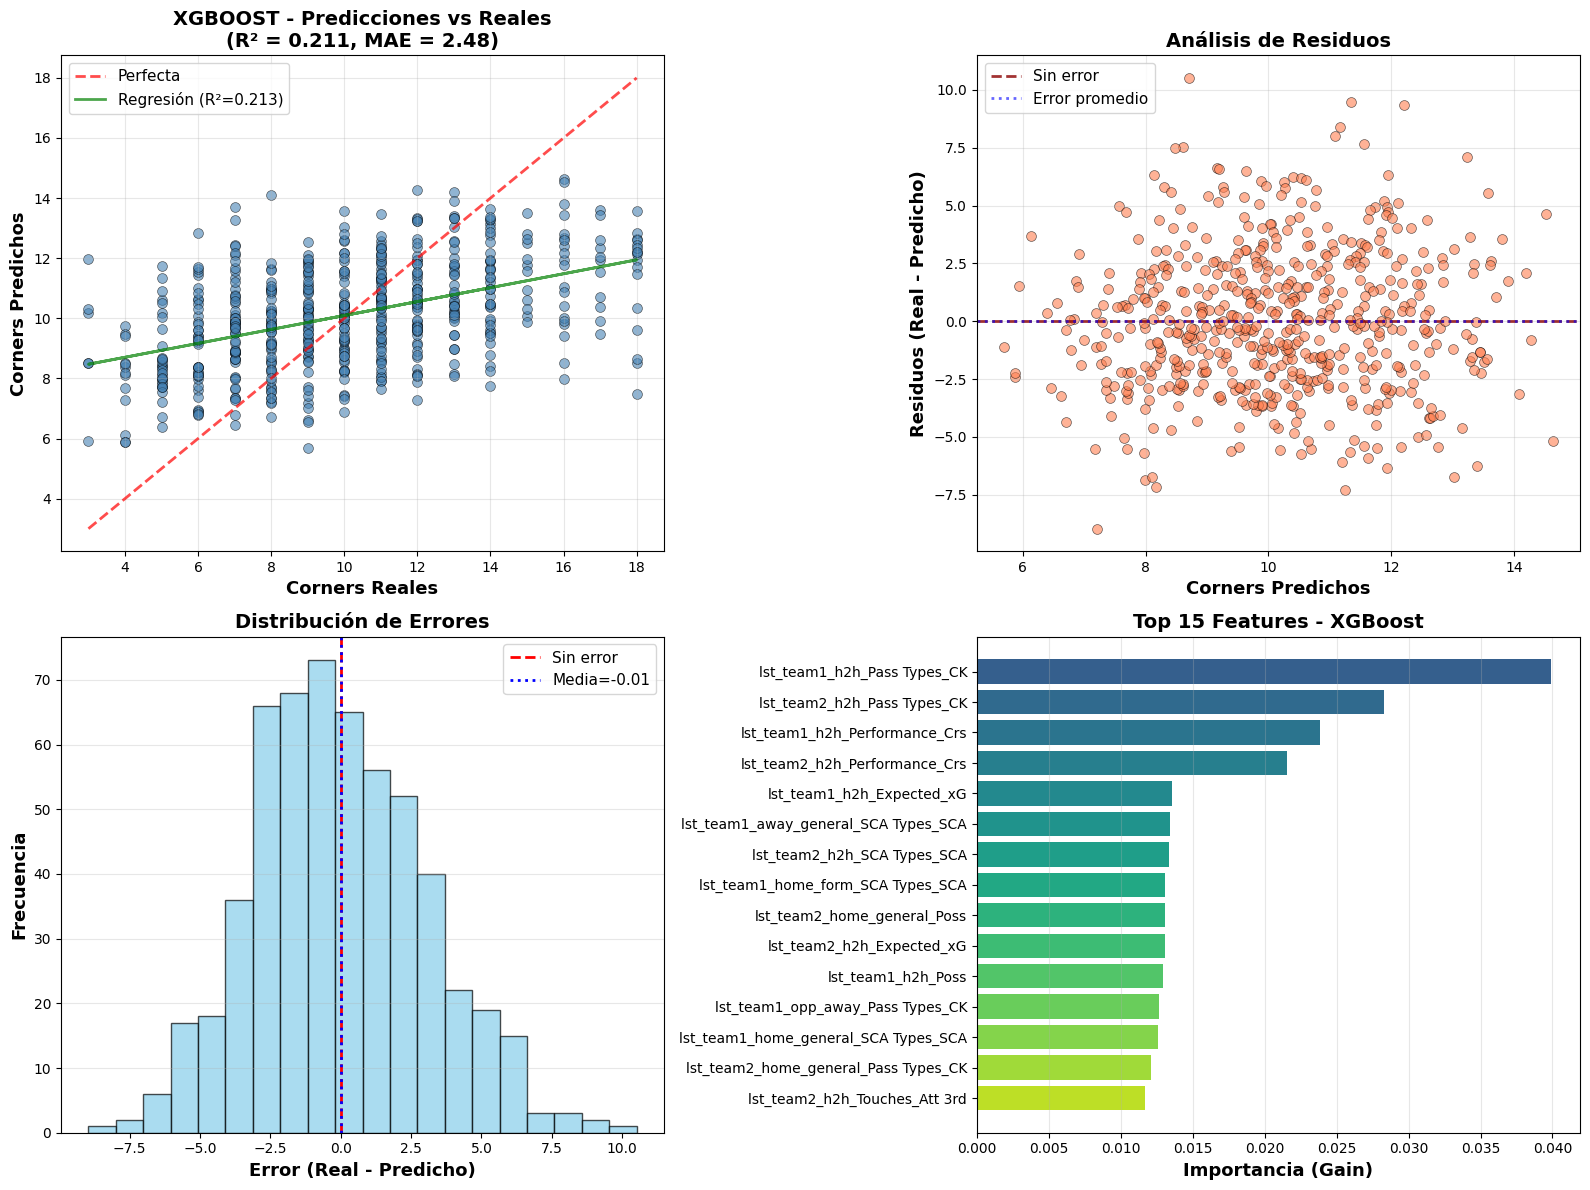


🔍 TOP 20 FEATURES MÁS IMPORTANTES (XGBOOST):
 1. lst_team1_h2h_Pass Types_CK                        0.039916 ███████
 2. lst_team2_h2h_Pass Types_CK                        0.028281 █████
 3. lst_team1_h2h_Performance_Crs                      0.023865 ████
 4. lst_team2_h2h_Performance_Crs                      0.021515 ████
 5. lst_team1_h2h_Expected_xG                          0.013578 ██
 6. lst_team1_away_general_SCA Types_SCA               0.013452 ██
 7. lst_team2_h2h_SCA Types_SCA                        0.013374 ██
 8. lst_team1_home_form_SCA Types_SCA                  0.013094 ██
 9. lst_team2_home_general_Poss                        0.013090 ██
10. lst_team2_h2h_Expected_xG                          0.013069 ██
11. lst_team1_h2h_Poss                                 0.012931 ██
12. lst_team1_opp_away_Pass Types_CK                   0.012685 ██
13. lst_team1_home_general_SCA Types_SCA               0.012579 ██
14. lst_team2_home_general_Pass Types_CK               0.012075 ██
15. 

In [17]:
# ===========================
# XGBOOST REGRESSOR - VERSIÓN COMPLETA
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import joblib

# ===========================
# 1. PREPARAR LOS DATOS
# ===========================

y_array = np.array(y).flatten()

mask = (y_array >= 3) & (y_array <= 18)

# Aplicar filtro
df_data1 = df_data.copy()

df_data = df_data[mask].copy()
y_array = y_array[mask]

print(f"✅ Datos preparados:")
print(f"   X shape: {df_data.shape}")
print(f"   Y shape: {y_array.shape}")

# Verificar y limpiar datos
assert len(df_data) == len(y_array), f"❌ ERROR: Dimensiones no coinciden"

if df_data.isnull().any().any():
    print(f"⚠️ Hay {df_data.isnull().sum().sum()} valores nulos en X")
    df_data = df_data.fillna(0)

if np.isnan(y_array).any():
    mask = ~np.isnan(y_array)
    df_data = df_data[mask]
    y_array = y_array[mask]

# ===========================
# 2. NORMALIZAR FEATURES (OPCIONAL PARA XGBOOST)
# ===========================

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_data),
    columns=df_data.columns
)

# ===========================
# 3. DIVIDIR DATOS
# ===========================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_array, 
    test_size=0.30,
    random_state=42,
    shuffle=True
)

print(f"\n📊 División de datos:")
print(f"   Train: {X_train.shape[0]} muestras")
print(f"   Test:  {X_test.shape[0]} muestras")

# ===========================
# 4. OPTIMIZACIÓN DE HIPERPARÁMETROS
# ===========================

print("\n🔍 Buscando mejores hiperparámetros con XGBoost...")

# Modelo base
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",  # Cambiar a 'gpu_hist' si tienes GPU
    n_jobs=-1,
    random_state=42
)

# Grid de hiperparámetros
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [1],
    "reg_lambda": [3.0],
    "gamma": [0.1, 0.3, 0.5]
}

# Búsqueda aleatoria (más rápido que GridSearch)
rs = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_train, y_train)

print("\n✅ Mejores parámetros encontrados:")
for param, value in rs.best_params_.items():
    print(f"   {param}: {value}")

# ===========================
# 5. RE-ENTRENAR CON EARLY STOPPING
# ===========================

# Split interno para validación
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=43
)

# Crear modelo con mejores parámetros
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    
    # PARÁMETROS CLAVE PARA CORNERS
    n_estimators=300,           # Más árboles para capturar patrones
    max_depth=4,                # Profundidad moderada (evita overfitting)
    learning_rate=0.03,         # Learning rate bajo (más estable)
    
    # REGULARIZACIÓN (importante con 100+ features)
    reg_alpha=0.5,              # L1 (Lasso) - elimina features irrelevantes
    reg_lambda=2.0,             # L2 (Ridge) - controla magnitudes
    gamma=0.3,                  # Min loss reduction
    
    # MUESTREO (reduce overfitting)
    subsample=0.7,              # 70% de muestras por árbol
    colsample_bytree=0.7,       # 70% de features por árbol
    colsample_bylevel=0.7,      # 70% de features por nivel
    
    # OTROS
    min_child_weight=3,         # Min samples en hoja
    random_state=42,
    n_jobs=-1,
    tree_method="hist"          # Más rápido
)

# Entrenar con early stopping (versión compatible)
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# ===========================
# 6. EVALUAR MODELO
# ===========================

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Métricas
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n📈 RESULTADOS XGBOOST")
print("=" * 50)
print(f"TRAIN SET:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  RMSE: {np.sqrt(train_mse):.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTEST SET:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {np.sqrt(test_mse):.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Diferencia entre Train y Test (indicador de overfitting)
print(f"\n⚠️ OVERFITTING CHECK:")
print(f"  Diferencia R²: {abs(train_r2 - test_r2):.4f}")
print(f"  Diferencia MAE: {abs(train_mae - test_mae):.4f}")

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-Validation R² (5-fold):")
print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# ===========================
# 7. ANÁLISIS DE PREDICCIONES
# ===========================

comparison = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_test_pred,
    'Error': y_test - y_test_pred,
    'Error_Abs': np.abs(y_test - y_test_pred),
    'Error_%': (np.abs(y_test - y_test_pred) / np.maximum(y_test, 1) * 100)
})
comparison = comparison.sort_values('Error_Abs', ascending=False)

print("\n🔍 PEORES PREDICCIONES (Top 5):")
print(comparison.head(5).to_string())

print("\n✅ MEJORES PREDICCIONES (Top 5):")
print(comparison.tail(5).to_string())

# Estadísticas de error
print(f"\n📊 ESTADÍSTICAS DE ERROR:")
print(f"  Error promedio: {comparison['Error'].mean():.2f}")
print(f"  Error mediano: {comparison['Error'].median():.2f}")
print(f"  Error estándar: {comparison['Error'].std():.2f}")
print(f"  % predicciones con error <2: {(comparison['Error_Abs'] < 2).sum() / len(comparison) * 100:.1f}%")
print(f"  % predicciones con error <3: {(comparison['Error_Abs'] < 3).sum() / len(comparison) * 100:.1f}%")

# ===========================
# 8. VISUALIZACIONES MEJORADAS
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Predicciones vs Reales (Test)
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_test_pred)

axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='steelblue', edgecolors='k', linewidths=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfecta', alpha=0.7)
axes[0, 0].plot(y_test, slope * y_test + intercept, 'g-', lw=2, 
                label=f'Regresión (R²={r_value**2:.3f})', alpha=0.7)
axes[0, 0].set_xlabel('Corners Reales', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 0].set_title(f'XGBOOST - Predicciones vs Reales\n(R² = {test_r2:.3f}, MAE = {test_mae:.2f})', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 8.2 Residuos vs Predicciones
axes[0, 1].scatter(y_test_pred, comparison['Error'], alpha=0.6, s=50, color='coral', edgecolors='k', linewidths=0.5)
axes[0, 1].axhline(y=0, color='darkred', linestyle='--', lw=2, label='Sin error', alpha=0.8)
axes[0, 1].axhline(y=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label='Error promedio', alpha=0.6)
axes[0, 1].set_xlabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Residuos (Real - Predicho)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Análisis de Residuos', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 8.3 Distribución de errores
axes[1, 0].hist(comparison['Error'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2, label='Sin error')
axes[1, 0].axvline(x=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label=f"Media={comparison['Error'].mean():.2f}")
axes[1, 0].set_xlabel('Error (Real - Predicho)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Frecuencia', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 8.4 Feature Importance (Top 15)
feature_importance = pd.DataFrame({
    'feature': df_data.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'], fontsize=10)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===========================
# 9. FEATURE IMPORTANCE DETALLADA
# ===========================

print("\n🔍 TOP 20 FEATURES MÁS IMPORTANTES (XGBOOST):")
print("=" * 75)
top_features = pd.DataFrame({
    'Feature': df_data.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    bar = '█' * int(row['Importance'] * 200)
    print(f"{idx:2d}. {row['Feature']:50s} {row['Importance']:.6f} {bar}")

# ===========================
# 10. GUARDAR MODELO Y SCALER
# ===========================

joblib.dump(xgb_model, 'xgboost_corners_optimized.pkl')
joblib.dump(scaler, 'scaler_corners_xgb.pkl')
print("\n💾 Modelo guardado como 'xgboost_corners_optimized.pkl'")
print("💾 Scaler guardado como 'scaler_corners_xgb.pkl'")

# ===========================
# 11. COMPARACIÓN VISUAL CON RANDOM FOREST (OPCIONAL)
# ===========================

print("\n📊 COMPARACIÓN RÁPIDA:")
print(f"{'Modelo':<20} {'Train R²':<12} {'Test R²':<12} {'Overfitting':<12}")
print("-" * 60)
print(f"{'XGBoost':<20} {train_r2:<12.4f} {test_r2:<12.4f} {abs(train_r2-test_r2):<12.4f}")

# Si ya tienes el modelo Random Forest cargado, puedes comparar:
# print(f"{'Random Forest':<20} {rf_train_r2:<12.4f} {rf_test_r2:<12.4f} {abs(rf_train_r2-rf_test_r2):<12.4f}")

✅ Datos preparados:
   X shape: (10441, 266)
   Y shape: (10441,)

📊 División de datos:
   Train (fit):      7986 muestras (76.5%)
   Validation:       888 muestras (8.5%)
   Test (hold-out):  1567 muestras (15.0%)

🔍 Búsqueda exhaustiva de hiperparámetros (GridSearchCV)...
⏱️ Esto puede tardar varios minutos con ~1700 partidos...

Fitting 5 folds for each of 512 candidates, totalling 2560 fits

✅ MEJORES HIPERPARÁMETROS ENCONTRADOS:
   colsample_bylevel   : 0.6
   colsample_bytree    : 0.7
   gamma               : 1.0
   learning_rate       : 0.03
   max_depth           : 4
   min_child_weight    : 7
   n_estimators        : 200
   reg_alpha           : 3.0
   reg_lambda          : 8.0
   subsample           : 0.7

📊 MEJOR SCORE (CV MAE): 1.8876

🏆 TOP 5 CONFIGURACIONES:

Rank 508:
  Train MAE: 1.6774
  CV MAE:    1.8876
  Gap:       -0.2102
  Params:    {'colsample_bylevel': 0.6, 'colsample_bytree': 0.7, 'gamma': 1.0, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 7, 'n_e

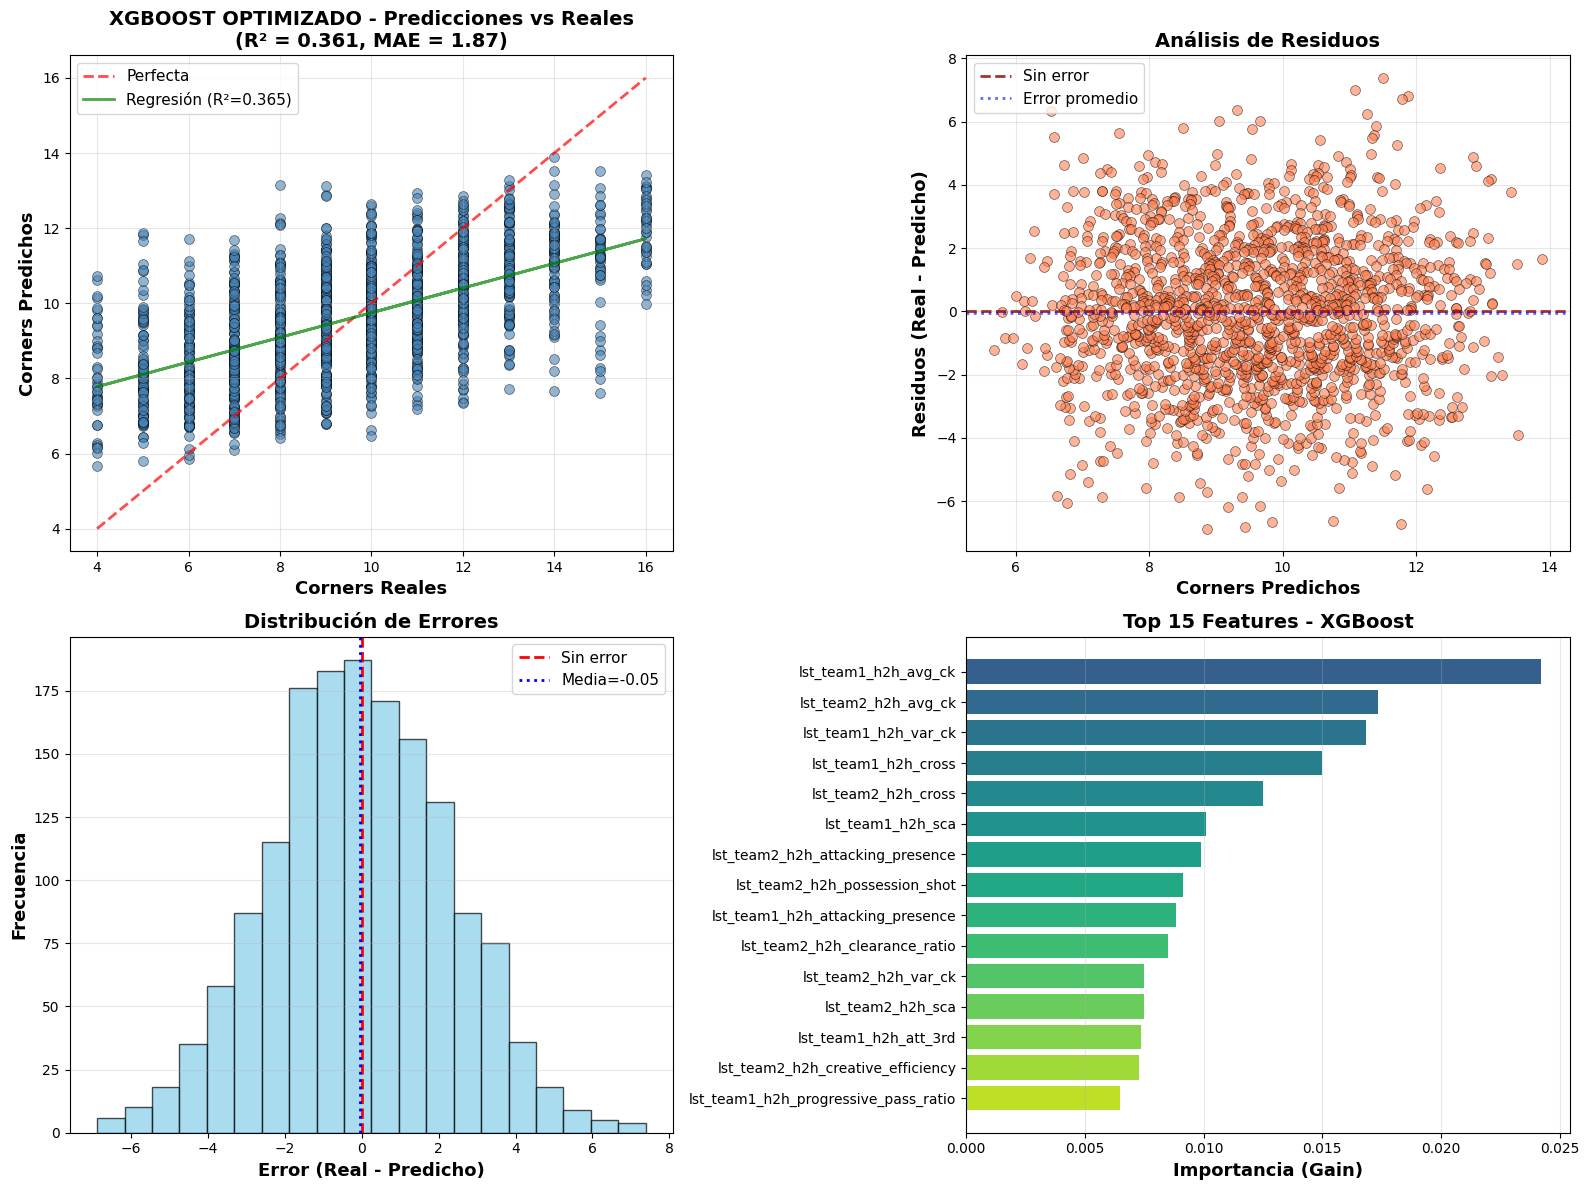


🔍 TOP 20 FEATURES MÁS IMPORTANTES:
 1. lst_team1_h2h_avg_ck                               0.024212 ████
 2. lst_team2_h2h_avg_ck                               0.017348 ███
 3. lst_team1_h2h_var_ck                               0.016851 ███
 4. lst_team1_h2h_cross                                0.014990 ██
 5. lst_team2_h2h_cross                                0.012484 ██
 6. lst_team1_h2h_sca                                  0.010088 ██
 7. lst_team2_h2h_attacking_presence                   0.009882 █
 8. lst_team2_h2h_possession_shot                      0.009137 █
 9. lst_team1_h2h_attacking_presence                   0.008847 █
10. lst_team2_h2h_clearance_ratio                      0.008517 █
11. lst_team2_h2h_var_ck                               0.007510 █
12. lst_team2_h2h_sca                                  0.007506 █
13. lst_team1_h2h_att_3rd                              0.007368 █
14. lst_team2_h2h_creative_efficiency                  0.007275 █
15. lst_team1_h2h_progressive_

In [3]:
# ===========================
# XGBOOST REGRESSOR - VERSIÓN OPTIMIZADA ANTI-OVERFITTING
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,  # ✅ CAMBIO: Usaremos GridSearch para búsqueda exhaustiva
    cross_val_score,
    KFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from xgboost import XGBRegressor
import joblib

# ===========================
# 1. PREPARAR LOS DATOS
# ===========================

y_array = np.array(y).flatten()

mask = (y_array >= 4) & (y_array <= 16)

# Aplicar filtro
df_data1 = df_data.copy()
df_data = df_data[mask].copy()
y_array = y_array[mask]

print(f"✅ Datos preparados:")
print(f"   X shape: {df_data.shape}")
print(f"   Y shape: {y_array.shape}")

# Verificar y limpiar datos
assert len(df_data) == len(y_array), f"❌ ERROR: Dimensiones no coinciden"

if df_data.isnull().any().any():
    print(f"⚠️ Hay {df_data.isnull().sum().sum()} valores nulos en X")
    df_data = df_data.fillna(0)

if np.isnan(y_array).any():
    mask = ~np.isnan(y_array)
    df_data = df_data[mask]
    y_array = y_array[mask]

# ===========================
# 2. NORMALIZAR FEATURES
# ===========================

"""scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_data),
    columns=df_data.columns
)"""
X_scaled = df_data


# ===========================
# 3. DIVIDIR DATOS (ESTRATEGIA MEJORADA)
# ===========================

# ✅ CAMBIO: Aumentamos train al 80% para tener más datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_array, 
    test_size=0.15,  # ⬇️ REDUCIR de 0.30 a 0.20
    random_state=42,
    shuffle=True
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)  # Solo transform

# ✅ NUEVO: Split adicional para validación temprana
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1,  # 20% del train para validación
    random_state=43
)

print(f"\n📊 División de datos:")
print(f"   Train (fit):      {X_train_fit.shape[0]} muestras ({X_train_fit.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Validation:       {X_val.shape[0]} muestras ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Test (hold-out):  {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# ===========================
# 4. GRIDSEARCH OPTIMIZADO PARA GENERALIZACIÓN
# ===========================

print("\n🔍 Búsqueda exhaustiva de hiperparámetros (GridSearchCV)...")
print("⏱️ Esto puede tardar varios minutos con ~1700 partidos...\n")

# ✅ GRID REDUCIDO Y ENFOCADO EN ANTI-OVERFITTING
param_grid = {
    # ⬇️ REDUCIR COMPLEJIDAD
    'n_estimators': [150, 200],  # Menos árboles
    'max_depth': [3, 4],  # ⬇️ Árboles más simples
    'learning_rate': [0.02, 0.03],  # ⬇️ Aprendizaje MÁS lento
    
    # ⬆️ AUMENTAR REGULARIZACIÓN
    'reg_alpha': [3.0, 5.0],  # ⬆️ L1 más fuerte
    'reg_lambda': [5.0, 8.0],  # ⬆️ L2 más fuerte
    'gamma': [0.5, 1.0],  # ⬆️ Penalización más alta
    
    # ⬇️ REDUCIR SAMPLING
    'subsample': [0.6, 0.7],  # ⬇️ Menos datos por árbol
    'colsample_bytree': [0.6, 0.7],  # ⬇️ Menos features por árbol
    'colsample_bylevel': [0.6],  # ⬇️ Menos features por nivel
    
    # ⬆️ AUMENTAR TAMAÑO MÍNIMO
    'min_child_weight': [5, 7]  # ⬆️ Hojas más grandes
}

# ✅ MODELO BASE CON CONFIGURACIÓN CONSERVADORA
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbosity=0  # Silenciar warnings
)

# ✅ CROSS-VALIDATION CON K-FOLD ESTRATIFICADO
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # ⬇️ 3 folds en lugar de 5

# ✅ SCORER PERSONALIZADO (priorizar MAE sobre R²)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ✅ GRIDSEARCH CON CONFIGURACIÓN ANTI-OVERFITTING
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=kfold,  # 3-fold
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

# ENTRENAR GRIDSEARCH
grid_search.fit(X_train_fit, y_train_fit)

# ===========================
# 5. ANALIZAR RESULTADOS DEL GRIDSEARCH
# ===========================

print("\n✅ MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("=" * 70)
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

print(f"\n📊 MEJOR SCORE (CV MAE): {-grid_search.best_score_:.4f}")

# ✅ DETECTAR OVERFITTING EN CV
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['mean_train_mae'] = -results_df['mean_train_score']
results_df['mean_test_mae'] = -results_df['mean_test_score']
results_df['overfitting_gap'] = results_df['mean_train_mae'] - results_df['mean_test_mae']

# Top 5 mejores configuraciones
top_5 = results_df.nsmallest(5, 'mean_test_mae')[
    ['mean_train_mae', 'mean_test_mae', 'overfitting_gap', 'params']
]

print("\n🏆 TOP 5 CONFIGURACIONES:")
print("=" * 70)
for idx, row in top_5.iterrows():
    print(f"\nRank {idx+1}:")
    print(f"  Train MAE: {row['mean_train_mae']:.4f}")
    print(f"  CV MAE:    {row['mean_test_mae']:.4f}")
    print(f"  Gap:       {row['overfitting_gap']:.4f}")
    print(f"  Params:    {row['params']}")

# ===========================
# 6. ENTRENAR MODELO FINAL CON EARLY STOPPING
# ===========================

# ===========================
# 6. ENTRENAR MODELO FINAL CON EARLY STOPPING (COMPATIBLE)
# ===========================

print("\n🚀 Entrenando modelo final con mejores parámetros...")

xgb_model = XGBRegressor(
    **grid_search.best_params_,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# ✅ ENTRENAR CON EVAL_SET (sin early_stopping_rounds en fit)
xgb_model.fit(
    X_train_fit, 
    y_train_fit,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# ✅ VERIFICAR SI HAY EARLY STOPPING ACTIVO
if hasattr(xgb_model, 'best_iteration') and xgb_model.best_iteration is not None:
    print(f"✅ Modelo entrenado con early stopping en iteración: {xgb_model.best_iteration}")
else:
    print(f"✅ Modelo entrenado con {xgb_model.n_estimators} iteraciones completas")

# ===========================
# 7. EVALUACIÓN COMPLETA
# ===========================

# Predicciones en todos los sets
y_train_fit_pred = xgb_model.predict(X_train_fit)
y_val_pred = xgb_model.predict(X_val)
y_train_pred = xgb_model.predict(X_train)  # Train completo
y_test_pred = xgb_model.predict(X_test)    # Test hold-out

# Métricas por set
def calc_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'set': set_name,
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'r2': r2
    }

metrics = [
    calc_metrics(y_train_fit, y_train_fit_pred, 'Train (Fit)'),
    calc_metrics(y_val, y_val_pred, 'Validation'),
    calc_metrics(y_train, y_train_pred, 'Train (Full)'),
    calc_metrics(y_test, y_test_pred, 'Test (Hold-out)')
]

df_metrics = pd.DataFrame(metrics)

print("\n📈 RESULTADOS FINALES - TODAS LAS PARTICIONES")
print("=" * 80)
print(df_metrics.to_string(index=False))

# ✅ ANÁLISIS DE OVERFITTING MULTI-NIVEL
print("\n⚠️ ANÁLISIS DE OVERFITTING:")
print("=" * 80)

gap_train_val = df_metrics[df_metrics['set'] == 'Train (Fit)']['r2'].values[0] - \
                df_metrics[df_metrics['set'] == 'Validation']['r2'].values[0]

gap_train_test = df_metrics[df_metrics['set'] == 'Train (Full)']['r2'].values[0] - \
                 df_metrics[df_metrics['set'] == 'Test (Hold-out)']['r2'].values[0]

gap_val_test = df_metrics[df_metrics['set'] == 'Validation']['r2'].values[0] - \
               df_metrics[df_metrics['set'] == 'Test (Hold-out)']['r2'].values[0]

print(f"  Gap Train→Validation R²:  {gap_train_val:+.4f} {'✅ OK' if abs(gap_train_val) < 0.10 else '⚠️ OVERFITTING'}")
print(f"  Gap Train→Test R²:        {gap_train_test:+.4f} {'✅ OK' if abs(gap_train_test) < 0.15 else '⚠️ OVERFITTING'}")
print(f"  Gap Validation→Test R²:   {gap_val_test:+.4f} {'✅ OK' if abs(gap_val_test) < 0.05 else '⚠️ DRIFT'}")

# ✅ CROSS-VALIDATION FINAL
cv_scores_r2 = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
cv_scores_mae = cross_val_score(xgb_model, X_train, y_train, cv=5, 
                                 scoring='neg_mean_absolute_error')

print(f"\n🔄 CROSS-VALIDATION (5-FOLD) EN TRAIN COMPLETO:")
print(f"  R² Mean:  {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std()*2:.4f})")
print(f"  MAE Mean: {-cv_scores_mae.mean():.4f} (±{cv_scores_mae.std()*2:.4f})")

# ===========================
# 8. ANÁLISIS DE PREDICCIONES (TEST)
# ===========================

test_mse = df_metrics[df_metrics['set'] == 'Test (Hold-out)']['mse'].values[0]
test_mae = df_metrics[df_metrics['set'] == 'Test (Hold-out)']['mae'].values[0]
test_r2 = df_metrics[df_metrics['set'] == 'Test (Hold-out)']['r2'].values[0]

comparison = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_test_pred,
    'Error': y_test - y_test_pred,
    'Error_Abs': np.abs(y_test - y_test_pred),
    'Error_%': (np.abs(y_test - y_test_pred) / np.maximum(y_test, 1) * 100)
})
comparison = comparison.sort_values('Error_Abs', ascending=False)

print("\n🔍 PEORES PREDICCIONES (Top 5):")
print(comparison.head(5).to_string())

print("\n✅ MEJORES PREDICCIONES (Top 5):")
print(comparison.tail(5).to_string())

# Estadísticas de error
print(f"\n📊 ESTADÍSTICAS DE ERROR (TEST):")
print(f"  Error promedio: {comparison['Error'].mean():.2f}")
print(f"  Error mediano: {comparison['Error'].median():.2f}")
print(f"  Error estándar: {comparison['Error'].std():.2f}")
print(f"  % predicciones con error <1.5: {(comparison['Error_Abs'] < 1.5).sum() / len(comparison) * 100:.1f}%")
print(f"  % predicciones con error <2.0: {(comparison['Error_Abs'] < 2.0).sum() / len(comparison) * 100:.1f}%")
print(f"  % predicciones con error <3.0: {(comparison['Error_Abs'] < 3.0).sum() / len(comparison) * 100:.1f}%")

# ===========================
# 9. VISUALIZACIONES MEJORADAS
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9.1 Predicciones vs Reales (Test)
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_test_pred)

axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='steelblue', edgecolors='k', linewidths=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfecta', alpha=0.7)
axes[0, 0].plot(y_test, slope * y_test + intercept, 'g-', lw=2, 
                label=f'Regresión (R²={r_value**2:.3f})', alpha=0.7)
axes[0, 0].set_xlabel('Corners Reales', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 0].set_title(f'XGBOOST OPTIMIZADO - Predicciones vs Reales\n(R² = {test_r2:.3f}, MAE = {test_mae:.2f})', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Residuos vs Predicciones
axes[0, 1].scatter(y_test_pred, comparison['Error'], alpha=0.6, s=50, color='coral', edgecolors='k', linewidths=0.5)
axes[0, 1].axhline(y=0, color='darkred', linestyle='--', lw=2, label='Sin error', alpha=0.8)
axes[0, 1].axhline(y=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label='Error promedio', alpha=0.6)
axes[0, 1].set_xlabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Residuos (Real - Predicho)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Análisis de Residuos', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Distribución de errores
axes[1, 0].hist(comparison['Error'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2, label='Sin error')
axes[1, 0].axvline(x=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label=f"Media={comparison['Error'].mean():.2f}")
axes[1, 0].set_xlabel('Error (Real - Predicho)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Frecuencia', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 9.4 Feature Importance (Top 15)
feature_importance = pd.DataFrame({
    'feature': df_data.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'], fontsize=10)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===========================
# 10. FEATURE IMPORTANCE DETALLADA
# ===========================

print("\n🔍 TOP 20 FEATURES MÁS IMPORTANTES:")
print("=" * 75)
top_features = pd.DataFrame({
    'Feature': df_data.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    bar = '█' * int(row['Importance'] * 200)
    print(f"{idx:2d}. {row['Feature']:50s} {row['Importance']:.6f} {bar}")

# ===========================
# 11. GUARDAR MODELO Y SCALER
# ===========================

joblib.dump(xgb_model, 'xgboost_corners_optimized_v2_6_leagues.pkl')
joblib.dump(scaler, 'scaler_corners_xgb_v2_6_leagues.pkl')
joblib.dump(grid_search.best_params_, 'best_params_xgb_6_leagues.pkl')

print("\n💾 ARCHIVOS GUARDADOS:")
print("   ✅ xgboost_corners_optimized_v2.pkl")
print("   ✅ scaler_corners_xgb_v2.pkl")
print("   ✅ best_params_xgb.pkl")

# ===========================
# 12. RESUMEN FINAL
# ===========================

print("\n" + "=" * 80)
print("📋 RESUMEN EJECUTIVO")
print("=" * 80)

print(f"\n🎯 RENDIMIENTO DEL MODELO:")
print(f"  Test R²:       {test_r2:.4f} ({'✅ EXCELENTE' if test_r2 > 0.40 else '⚠️ MEJORABLE' if test_r2 > 0.25 else '❌ BAJO'})")
print(f"  Test MAE:      {test_mae:.4f} corners")
print(f"  Test RMSE:     {np.sqrt(test_mse):.4f} corners")

print(f"\n🔄 GENERALIZACIÓN:")
print(f"  CV R² (mean):  {cv_scores_r2.mean():.4f}")
print(f"  CV MAE (mean): {-cv_scores_mae.mean():.4f}")
print(f"  Estabilidad:   {'✅ ALTA' if cv_scores_r2.std() < 0.05 else '⚠️ MEDIA' if cv_scores_r2.std() < 0.10 else '❌ BAJA'}")

print(f"\n⚠️ OVERFITTING:")
print(f"  Train-Test Gap R²: {gap_train_test:+.4f} ({'✅ ACEPTABLE' if abs(gap_train_test) < 0.15 else '⚠️ PRESENTE'})")

print("\n" + "=" * 80)


📊 ANÁLISIS DE RENDIMIENTO POR LÍNEAS DE OVER/UNDER

📈 TABLA DE RESULTADOS:
Línea  Over_Accuracy  Over_Precision  Over_Total  Over_Pred  Under_Accuracy  Under_Precision  Under_Total  Under_Pred  Total_Accuracy  Total_Correct
  7.5          96.52           81.13         949       1129           33.44            76.43          320         140           80.61           1023
  8.5          87.04           74.95         787        914           52.49            71.27          482         355           73.92            938
  9.5          73.16           73.72         652        647           72.45            71.86          617         622           72.81            924
 10.5          54.00           71.27         487        369           86.45            75.11          782         900           74.00            939
 11.5          34.08           71.60         355        169           94.75            78.73          914        1100           77.78            987
 12.5           9.05          

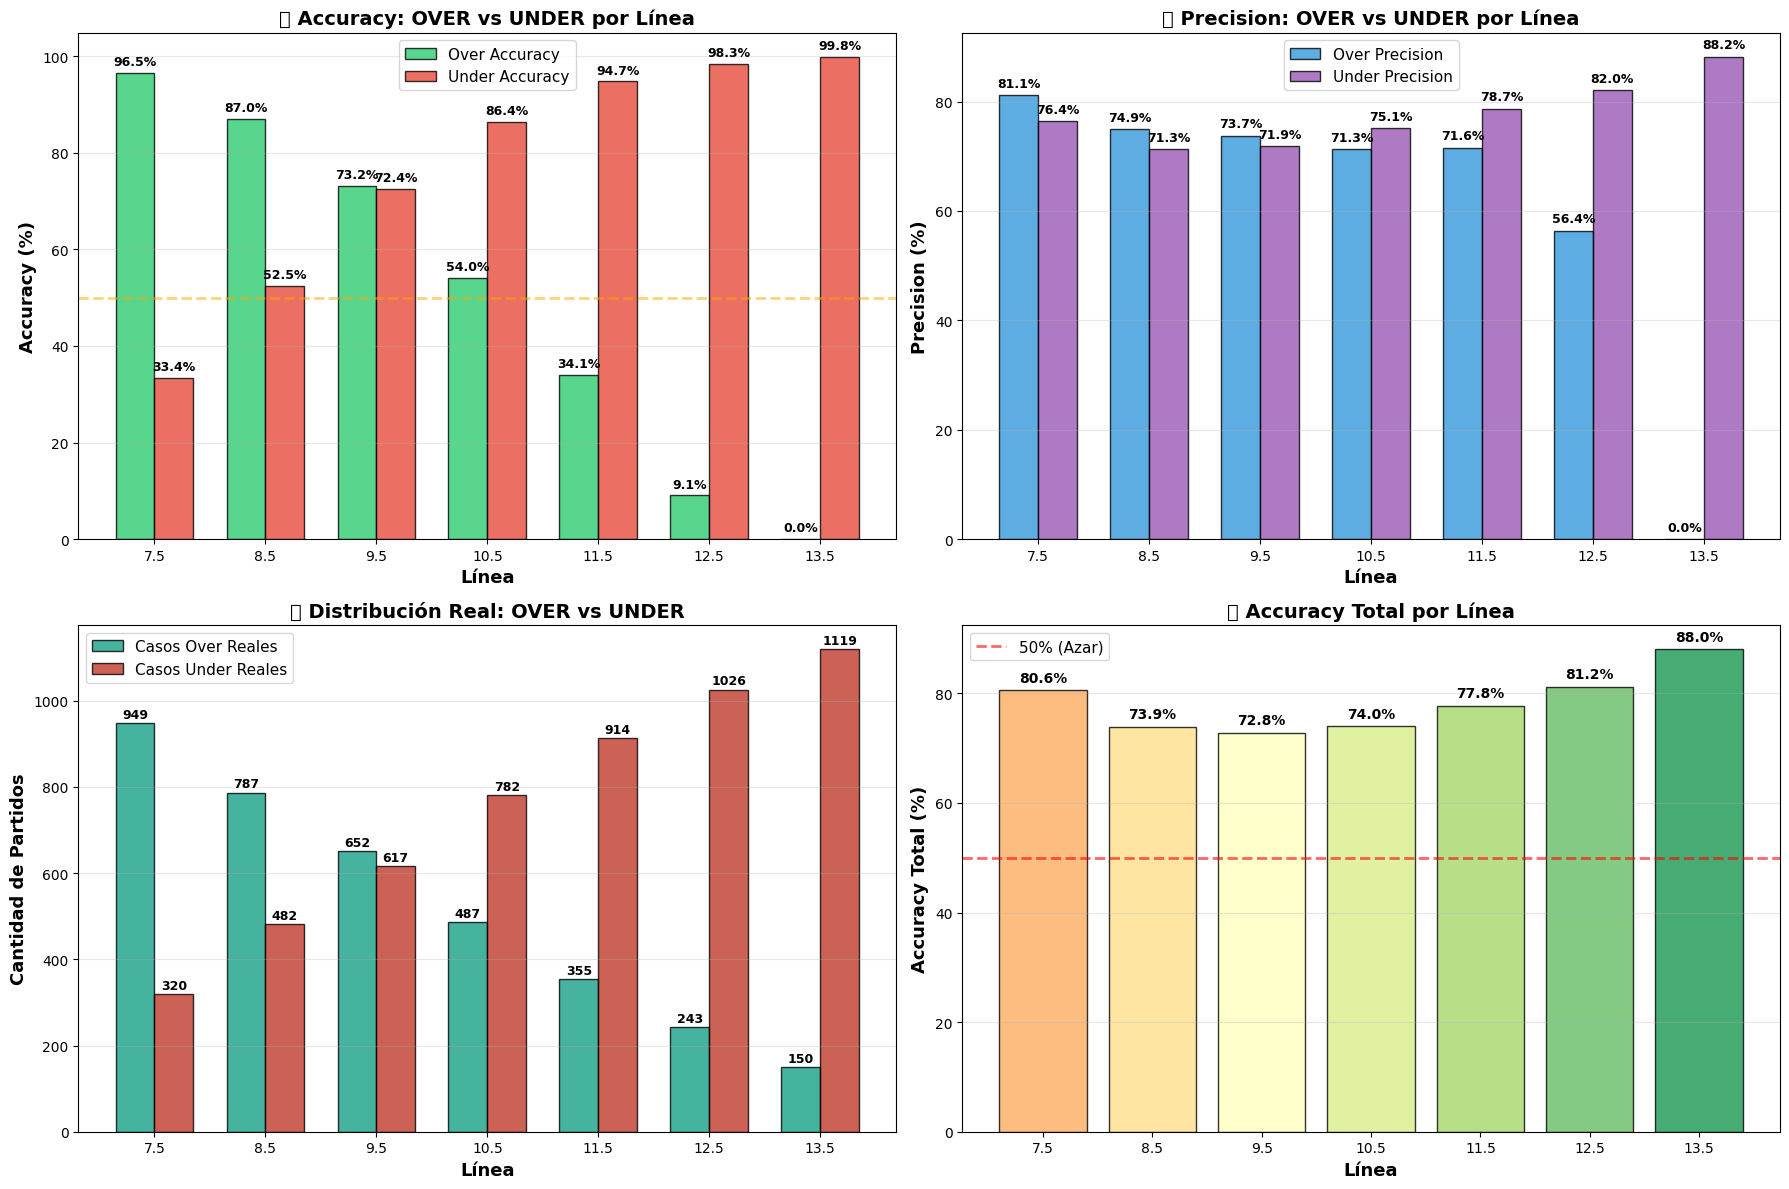

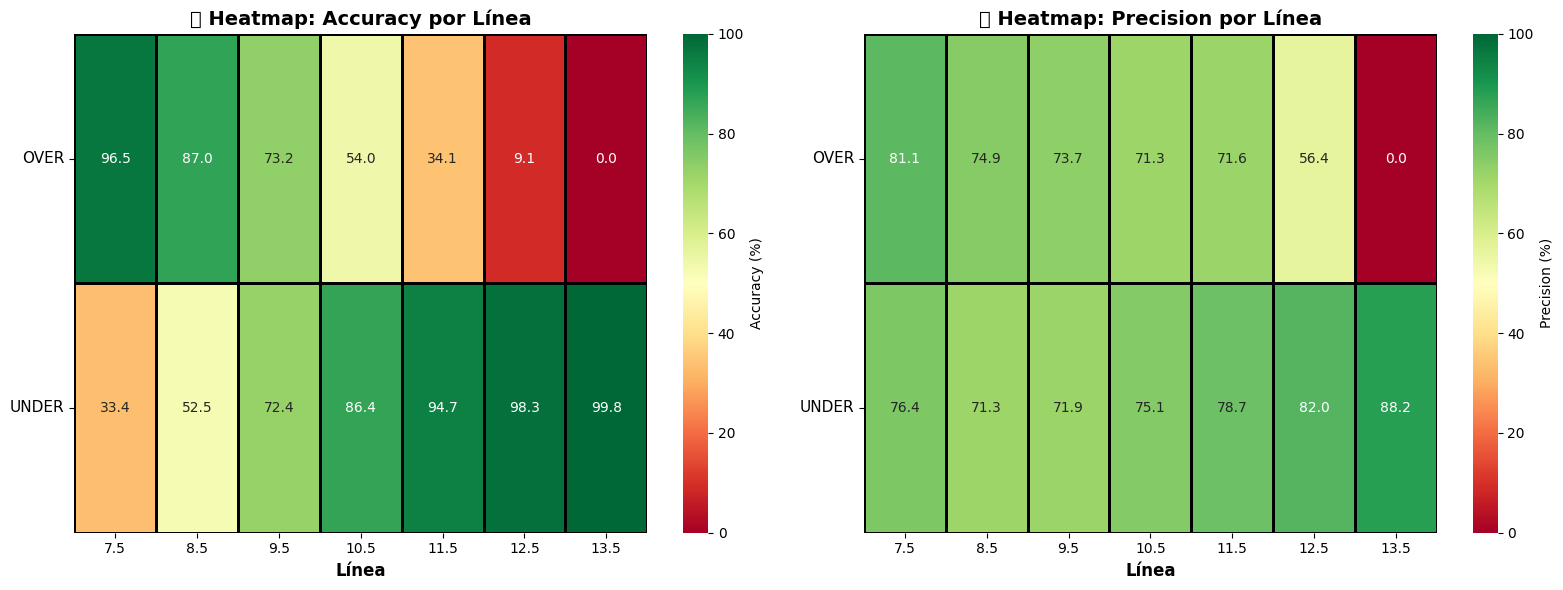


📋 RESUMEN EJECUTIVO

✅ MEJOR LÍNEA PARA OVER:
   Línea: 7.5
   Accuracy: 96.52%
   Precision: 81.13%
   Casos totales: 949

✅ MEJOR LÍNEA PARA UNDER:
   Línea: 13.5
   Accuracy: 99.82%
   Precision: 88.16%
   Casos totales: 1119

🏆 MEJOR LÍNEA GENERAL:
   Línea: 13.5
   Accuracy Total: 88.02%
   Aciertos: 1117/1269

⭐ LÍNEAS CON ACCURACY ≥ 60%:
   • 7.5: 80.61%
   • 8.5: 73.92%
   • 9.5: 72.81%
   • 10.5: 74.00%
   • 11.5: 77.78%
   • 12.5: 81.25%
   • 13.5: 88.02%

⚠️ ADVERTENCIAS:
   • Líneas débiles para OVER (< 50%):
     - 11.5: 34.08%
     - 12.5: 9.05%
     - 13.5: 0.00%
   • Líneas débiles para UNDER (< 50%):
     - 7.5: 33.44%


💾 Resultados guardados en 'over_under_performance.csv'


In [5]:
# ===========================
# ANÁLISIS DE OVER/UNDER POR LÍNEAS
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_over_under_performance(y_real, y_pred, lines=None):
    """
    Analiza el rendimiento del modelo en diferentes líneas de Over/Under
    
    Args:
        y_real: Valores reales de corners
        y_pred: Valores predichos por el modelo
        lines: Lista de líneas a analizar (default: [7.5, 8.5, 9.5, 10.5, 11.5, 12.5])
    
    Returns:
        DataFrame con métricas por línea
    """
    
    if lines is None:
        lines = [7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
    
    results = []
    
    for line in lines:
        # Clasificación real
        real_over = (y_real > line).astype(int)
        real_under = (y_real <= line).astype(int)
        
        # Clasificación predicha
        pred_over = (y_pred > line).astype(int)
        pred_under = (y_pred <= line).astype(int)
        
        # Métricas OVER
        over_correct = ((real_over == 1) & (pred_over == 1)).sum()
        over_total = (real_over == 1).sum()
        over_accuracy = (over_correct / over_total * 100) if over_total > 0 else 0
        
        # Predicciones OVER que acertaron
        over_pred_total = (pred_over == 1).sum()
        over_precision = (over_correct / over_pred_total * 100) if over_pred_total > 0 else 0
        
        # Métricas UNDER
        under_correct = ((real_under == 1) & (pred_under == 1)).sum()
        under_total = (real_under == 1).sum()
        under_accuracy = (under_correct / under_total * 100) if under_total > 0 else 0
        
        # Predicciones UNDER que acertaron
        under_pred_total = (pred_under == 1).sum()
        under_precision = (under_correct / under_pred_total * 100) if under_pred_total > 0 else 0
        
        # Accuracy general en esta línea
        total_correct = over_correct + under_correct
        total_accuracy = (total_correct / len(y_real) * 100)
        
        results.append({
            'Línea': f"{line}",
            'Over_Accuracy': over_accuracy,
            'Over_Precision': over_precision,
            'Over_Total': over_total,
            'Over_Pred': over_pred_total,
            'Under_Accuracy': under_accuracy,
            'Under_Precision': under_precision,
            'Under_Total': under_total,
            'Under_Pred': under_pred_total,
            'Total_Accuracy': total_accuracy,
            'Total_Correct': total_correct
        })
    
    return pd.DataFrame(results)

# ===========================
# EJECUTAR ANÁLISIS
# ===========================

print("\n" + "=" * 80)
print("📊 ANÁLISIS DE RENDIMIENTO POR LÍNEAS DE OVER/UNDER")
print("=" * 80)

# Líneas a analizar
lines_to_test = [7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]

# Realizar análisis
df_performance = analyze_over_under_performance(
    y_test, 
    y_test_pred, 
    lines=lines_to_test
)

# Mostrar resultados
print("\n📈 TABLA DE RESULTADOS:")
print("=" * 80)
print(df_performance.to_string(index=False))

# ===========================
# VISUALIZACIÓN 1: GRÁFICO DE BARRAS AGRUPADAS
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1.1 Accuracy OVER vs UNDER
x = np.arange(len(df_performance))
width = 0.35

axes[0, 0].bar(x - width/2, df_performance['Over_Accuracy'], width, 
               label='Over Accuracy', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, df_performance['Under_Accuracy'], width, 
               label='Under Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')

axes[0, 0].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[0, 0].set_title('🎯 Accuracy: OVER vs UNDER por Línea', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(df_performance['Línea'])
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=50, color='orange', linestyle='--', lw=2, alpha=0.5, label='50% (Azar)')

# Agregar valores en las barras
for i, v in enumerate(df_performance['Over_Accuracy']):
    axes[0, 0].text(i - width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Accuracy']):
    axes[0, 0].text(i + width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.2 Precision OVER vs UNDER
axes[0, 1].bar(x - width/2, df_performance['Over_Precision'], width, 
               label='Over Precision', color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width/2, df_performance['Under_Precision'], width, 
               label='Under Precision', color='#9b59b6', alpha=0.8, edgecolor='black')

axes[0, 1].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Precision (%)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('🔍 Precision: OVER vs UNDER por Línea', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(df_performance['Línea'])
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(df_performance['Over_Precision']):
    axes[0, 1].text(i - width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Precision']):
    axes[0, 1].text(i + width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.3 Distribución de casos reales
axes[1, 0].bar(x - width/2, df_performance['Over_Total'], width, 
               label='Casos Over Reales', color='#16a085', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, df_performance['Under_Total'], width, 
               label='Casos Under Reales', color='#c0392b', alpha=0.8, edgecolor='black')

axes[1, 0].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Cantidad de Partidos', fontsize=13, fontweight='bold')
axes[1, 0].set_title('📊 Distribución Real: OVER vs UNDER', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(df_performance['Línea'])
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(df_performance['Over_Total']):
    axes[1, 0].text(i - width/2, v + 5, f'{int(v)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Total']):
    axes[1, 0].text(i + width/2, v + 5, f'{int(v)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.4 Accuracy Total por Línea
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_performance)))
bars = axes[1, 1].bar(x, df_performance['Total_Accuracy'], 
                      color=colors_gradient, alpha=0.8, edgecolor='black')

axes[1, 1].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy Total (%)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('🎯 Accuracy Total por Línea', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(df_performance['Línea'])
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=50, color='red', linestyle='--', lw=2, alpha=0.6, label='50% (Azar)')
axes[1, 1].legend(fontsize=11)

for i, v in enumerate(df_performance['Total_Accuracy']):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ===========================
# VISUALIZACIÓN 2: HEATMAP COMPARATIVO
# ===========================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos para heatmap
heatmap_data_accuracy = df_performance[['Línea', 'Over_Accuracy', 'Under_Accuracy']].set_index('Línea').T
heatmap_data_precision = df_performance[['Línea', 'Over_Precision', 'Under_Precision']].set_index('Línea').T

# 2.1 Heatmap Accuracy
sns.heatmap(heatmap_data_accuracy, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Accuracy (%)'}, 
            ax=axes[0], linewidths=2, linecolor='black')
axes[0].set_title('🔥 Heatmap: Accuracy por Línea', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Línea', fontsize=12, fontweight='bold')
axes[0].set_yticklabels(['OVER', 'UNDER'], rotation=0, fontsize=11)

# 2.2 Heatmap Precision
sns.heatmap(heatmap_data_precision, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Precision (%)'}, 
            ax=axes[1], linewidths=2, linecolor='black')
axes[1].set_title('🔥 Heatmap: Precision por Línea', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Línea', fontsize=12, fontweight='bold')
axes[1].set_yticklabels(['OVER', 'UNDER'], rotation=0, fontsize=11)

plt.tight_layout()
plt.show()

# ===========================
# RESUMEN EJECUTIVO
# ===========================

print("\n" + "=" * 80)
print("📋 RESUMEN EJECUTIVO")
print("=" * 80)

# Mejor línea para OVER
best_over_line = df_performance.loc[df_performance['Over_Accuracy'].idxmax()]
print(f"\n✅ MEJOR LÍNEA PARA OVER:")
print(f"   Línea: {best_over_line['Línea']}")
print(f"   Accuracy: {best_over_line['Over_Accuracy']:.2f}%")
print(f"   Precision: {best_over_line['Over_Precision']:.2f}%")
print(f"   Casos totales: {int(best_over_line['Over_Total'])}")

# Mejor línea para UNDER
best_under_line = df_performance.loc[df_performance['Under_Accuracy'].idxmax()]
print(f"\n✅ MEJOR LÍNEA PARA UNDER:")
print(f"   Línea: {best_under_line['Línea']}")
print(f"   Accuracy: {best_under_line['Under_Accuracy']:.2f}%")
print(f"   Precision: {best_under_line['Under_Precision']:.2f}%")
print(f"   Casos totales: {int(best_under_line['Under_Total'])}")

# Mejor línea general
best_total_line = df_performance.loc[df_performance['Total_Accuracy'].idxmax()]
print(f"\n🏆 MEJOR LÍNEA GENERAL:")
print(f"   Línea: {best_total_line['Línea']}")
print(f"   Accuracy Total: {best_total_line['Total_Accuracy']:.2f}%")
print(f"   Aciertos: {int(best_total_line['Total_Correct'])}/{len(y_test)}")

# Líneas por encima del 60% de accuracy
high_accuracy_lines = df_performance[df_performance['Total_Accuracy'] >= 60]
if len(high_accuracy_lines) > 0:
    print(f"\n⭐ LÍNEAS CON ACCURACY ≥ 60%:")
    for _, row in high_accuracy_lines.iterrows():
        print(f"   • {row['Línea']}: {row['Total_Accuracy']:.2f}%")
else:
    print(f"\n⚠️ Ninguna línea alcanzó 60% de accuracy total")

# Advertencias
print(f"\n⚠️ ADVERTENCIAS:")
weak_lines_over = df_performance[df_performance['Over_Accuracy'] < 50]
if len(weak_lines_over) > 0:
    print(f"   • Líneas débiles para OVER (< 50%):")
    for _, row in weak_lines_over.iterrows():
        print(f"     - {row['Línea']}: {row['Over_Accuracy']:.2f}%")

weak_lines_under = df_performance[df_performance['Under_Accuracy'] < 50]
if len(weak_lines_under) > 0:
    print(f"   • Líneas débiles para UNDER (< 50%):")
    for _, row in weak_lines_under.iterrows():
        print(f"     - {row['Línea']}: {row['Under_Accuracy']:.2f}%")

print("\n" + "=" * 80)

# ===========================
# GUARDAR RESULTADOS
# ===========================

df_performance.to_csv('over_under_performance.csv', index=False)
print("\n💾 Resultados guardados en 'over_under_performance.csv'")

In [20]:
import plotly.express as plt

plt.histogram(y)


🔻 TOP 20 FEATURES MENOS IMPORTANTES (XGBOOST):
 1. league_NED                                         0.000000 ▓
 2. league_FRA                                         0.000000 ▓
 3. league_GER                                         0.000000 ▓
 4. league_ESP                                         0.000000 ▓
 5. league_ITA                                         0.000000 ▓
 6. lst_team2_h2h_gf                                   0.001176 ▓
 7. lst_team1_away_form_creative_efficiency            0.001607 ▓
 8. lst_team1_away_general_attacking_presence          0.001985 ▓
 9. lst_team2_home_form_att_3rd                        0.002374 ▓
10. lst_team2_home_form_assist_sca                     0.002411 ▓
11. lst_team2_away_general_att_3rd                     0.002433 ▓
12. lst_team1_away_general_sh_accuracy                 0.002457 ▓
13. lst_team2_away_general_interception_tackle         0.002475 ▓
14. lst_team1_away_form_cross                          0.002492 ▓
15. lst_team2_home_general_o

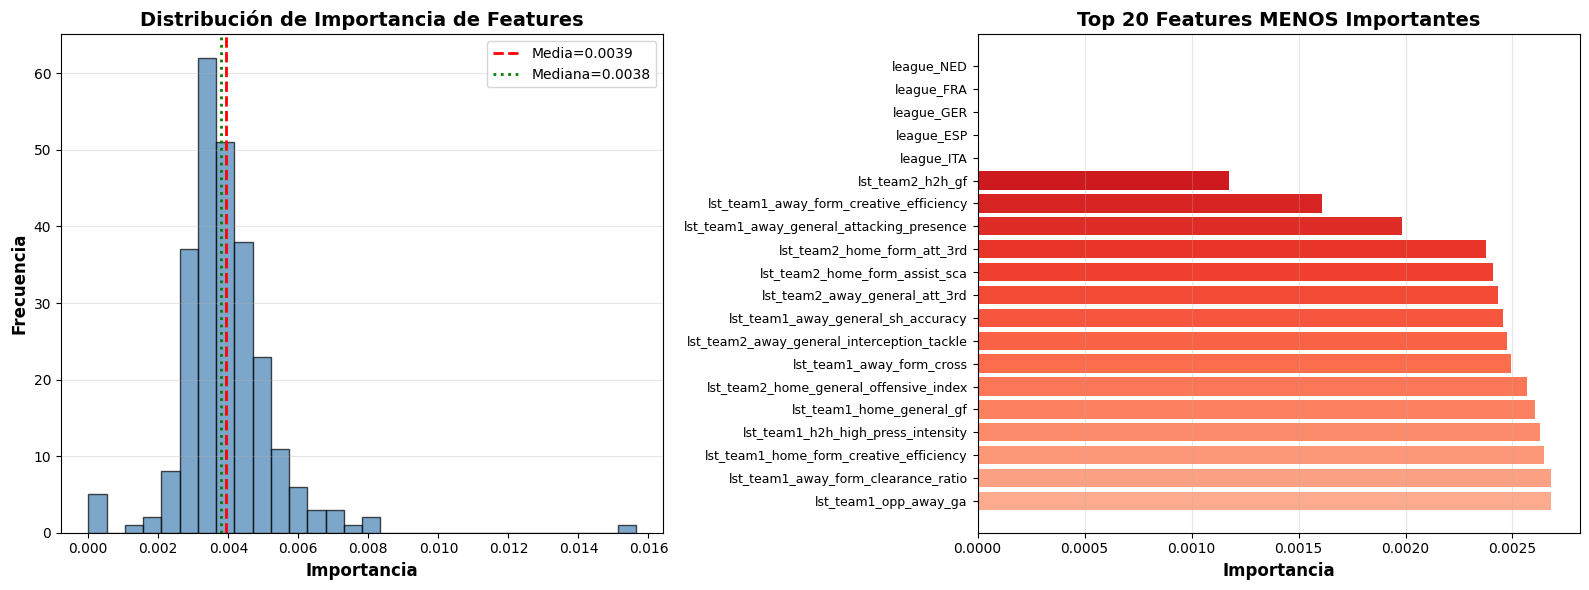


🗑️ FEATURES CANDIDATAS A ELIMINAR (importancia < 0.005):
Total: 223 features
  1. league_NED
  2. league_FRA
  3. league_GER
  4. league_ESP
  5. league_ITA
  6. lst_team2_h2h_gf
  7. lst_team1_away_form_creative_efficiency
  8. lst_team1_away_general_attacking_presence
  9. lst_team2_home_form_att_3rd
  10. lst_team2_home_form_assist_sca
  ... y 213 más

🗑️ FEATURES CANDIDATAS A ELIMINAR (bottom 10%):
Total: 26 features

COMPARACIÓN: MODELO COMPLETO vs MODELO REDUCIDO

🧪 PRUEBA SIN 223 FEATURES:
Shape original: (2004, 254)
Shape reducido: (2004, 31)

📊 RESULTADOS:
  R² (Test): 0.1172
  MAE (Test): 2.2105
  CV R² Mean: 0.0847 (+/- 0.0412)

📊 COMPARACIÓN FINAL:
Modelo                         R² (Test)       MAE (Test)     
------------------------------------------------------------
Original (todas features)      0.1459          2.1554         
Reducido (sin {len(features_to_remove_threshold)} features) 0.1172          2.2105         

⚠️ PRECAUCIÓN: Eliminar estas features reduce el r

In [8]:
# ===========================
# ANÁLISIS DE FEATURES MENOS IMPORTANTES
# ===========================

import pandas as pd
import numpy as np

# Obtener todas las importancias ordenadas
all_features_importance = pd.DataFrame({
    'Feature': df_data.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)  # Ascendente para ver las menos importantes primero

# ===========================
# 1. FEATURES MENOS IMPORTANTES (Bottom 20)
# ===========================

print("\n🔻 TOP 20 FEATURES MENOS IMPORTANTES (XGBOOST):")
print("=" * 75)

bottom_features = all_features_importance.head(100)

for idx, (_, row) in enumerate(bottom_features.iterrows(), 1):
    bar = '▓' * max(1, int(row['Importance'] * 500))  # Escala aumentada para ver diferencias
    print(f"{idx:2d}. {row['Feature']:50s} {row['Importance']:.6f} {bar}")

# ===========================
# 2. ESTADÍSTICAS DE IMPORTANCIA
# ===========================

print("\n📊 ESTADÍSTICAS DE IMPORTANCIA:")
print("=" * 50)
print(f"Total features: {len(all_features_importance)}")
print(f"Importancia promedio: {all_features_importance['Importance'].mean():.6f}")
print(f"Importancia mediana: {all_features_importance['Importance'].median():.6f}")
print(f"Importancia std: {all_features_importance['Importance'].std():.6f}")
print(f"Importancia máxima: {all_features_importance['Importance'].max():.6f}")
print(f"Importancia mínima: {all_features_importance['Importance'].min():.6f}")

# ===========================
# 3. FEATURES CON IMPORTANCIA CASI NULA
# ===========================

threshold_zero = 0.001  # Umbral para considerar "casi cero"
near_zero_features = all_features_importance[all_features_importance['Importance'] < threshold_zero]

print(f"\n⚠️ FEATURES CON IMPORTANCIA < {threshold_zero}:")
print(f"Total: {len(near_zero_features)} features")
if len(near_zero_features) > 0:
    print("\nLista completa:")
    for idx, (_, row) in enumerate(near_zero_features.iterrows(), 1):
        print(f"  {idx:2d}. {row['Feature']:50s} {row['Importance']:.6f}")

# ===========================
# 4. DISTRIBUCIÓN POR PERCENTILES
# ===========================

print("\n📈 DISTRIBUCIÓN DE IMPORTANCIA POR PERCENTILES:")
print("=" * 50)
for percentile in [10, 25, 50, 75, 90]:
    value = np.percentile(all_features_importance['Importance'], percentile)
    count = (all_features_importance['Importance'] <= value).sum()
    print(f"Percentil {percentile:2d}: {value:.6f} ({count} features)")

# ===========================
# 5. VISUALIZACIÓN - TODAS LAS FEATURES
# ===========================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 5.1 Histograma de importancias
axes[0].hist(all_features_importance['Importance'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=all_features_importance['Importance'].mean(), color='red', 
                linestyle='--', lw=2, label=f"Media={all_features_importance['Importance'].mean():.4f}")
axes[0].axvline(x=all_features_importance['Importance'].median(), color='green', 
                linestyle=':', lw=2, label=f"Mediana={all_features_importance['Importance'].median():.4f}")
axes[0].set_xlabel('Importancia', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Importancia de Features', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 5.2 Bottom 20 features
bottom_20 = all_features_importance.head(20)
colors_bottom = plt.cm.Reds(np.linspace(0.9, 0.3, len(bottom_20)))
axes[1].barh(range(len(bottom_20)), bottom_20['Importance'], color=colors_bottom)
axes[1].set_yticks(range(len(bottom_20)))
axes[1].set_yticklabels(bottom_20['Feature'], fontsize=9)
axes[1].set_xlabel('Importancia', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Features MENOS Importantes', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===========================
# 6. IDENTIFICAR FEATURES A ELIMINAR
# ===========================

# Opción A: Por umbral de importancia
importance_threshold = 0.005  # Ajusta según tus necesidades
features_to_remove_threshold = all_features_importance[
    all_features_importance['Importance'] < importance_threshold
]['Feature'].tolist()

print(f"\n🗑️ FEATURES CANDIDATAS A ELIMINAR (importancia < {importance_threshold}):")
print(f"Total: {len(features_to_remove_threshold)} features")
if len(features_to_remove_threshold) > 0:
    for idx, feat in enumerate(features_to_remove_threshold[:10], 1):
        print(f"  {idx}. {feat}")
    if len(features_to_remove_threshold) > 10:
        print(f"  ... y {len(features_to_remove_threshold) - 10} más")

# Opción B: Por percentil (bottom X%)
bottom_percentile = 10  # Eliminar el 10% menos importante
percentile_value = np.percentile(all_features_importance['Importance'], bottom_percentile)
features_to_remove_percentile = all_features_importance[
    all_features_importance['Importance'] <= percentile_value
]['Feature'].tolist()

print(f"\n🗑️ FEATURES CANDIDATAS A ELIMINAR (bottom {bottom_percentile}%):")
print(f"Total: {len(features_to_remove_percentile)} features")

# ===========================
# 7. ELIMINAR FEATURES Y RE-ENTRENAR (OPCIONAL)
# ===========================

def test_without_features(df_data, features_to_remove, model_type='xgboost'):
    """
    Prueba el modelo sin ciertas features
    
    Args:
        df_data: DataFrame original
        features_to_remove: Lista de features a eliminar
        model_type: 'xgboost' o 'randomforest'
    """
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_absolute_error
    
    # Crear nuevo DataFrame sin las features
    df_reduced = df_data.drop(columns=features_to_remove, errors='ignore')
    
    print(f"\n🧪 PRUEBA SIN {len(features_to_remove)} FEATURES:")
    print(f"Shape original: {df_data.shape}")
    print(f"Shape reducido: {df_reduced.shape}")
    
    # Normalizar
    scaler_test = StandardScaler()
    X_scaled_test = pd.DataFrame(
        scaler_test.fit_transform(df_reduced),
        columns=df_reduced.columns
    )
    
    # Split
    X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
        X_scaled_test, y_array, test_size=0.25, random_state=42
    )
    
    # Entrenar modelo rápido
    if model_type == 'xgboost':
        from xgboost import XGBRegressor
        model_test = XGBRegressor(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=42,
            n_jobs=-1
        )
    else:
        from sklearn.ensemble import RandomForestRegressor
        model_test = RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            random_state=42,
            n_jobs=-1
        )
    
    model_test.fit(X_train_test, y_train_test)
    
    # Evaluar
    y_test_pred_test = model_test.predict(X_test_test)
    r2_test = r2_score(y_test_test, y_test_pred_test)
    mae_test = mean_absolute_error(y_test_test, y_test_pred_test)
    
    print(f"\n📊 RESULTADOS:")
    print(f"  R² (Test): {r2_test:.4f}")
    print(f"  MAE (Test): {mae_test:.4f}")
    
    # Cross-validation
    cv_scores_test = cross_val_score(model_test, X_train_test, y_train_test, cv=5, scoring='r2')
    print(f"  CV R² Mean: {cv_scores_test.mean():.4f} (+/- {cv_scores_test.std() * 2:.4f})")
    
    return r2_test, mae_test

# Probar sin las features menos importantes
print("\n" + "=" * 75)
print("COMPARACIÓN: MODELO COMPLETO vs MODELO REDUCIDO")
print("=" * 75)

r2_reduced, mae_reduced = test_without_features(
    df_data, 
    features_to_remove_threshold,
    model_type='xgboost'
)

print(f"\n📊 COMPARACIÓN FINAL:")
print(f"{'Modelo':<30} {'R² (Test)':<15} {'MAE (Test)':<15}")
print("-" * 60)
print(f"{'Original (todas features)':<30} {test_r2:<15.4f} {test_mae:<15.4f}")
print(f"{'Reducido (sin {len(features_to_remove_threshold)} features)':<30} {r2_reduced:<15.4f} {mae_reduced:<15.4f}")

difference_r2 = test_r2 - r2_reduced
difference_mae = test_mae - mae_reduced

if abs(difference_r2) < 0.01 and abs(difference_mae) < 0.1:
    print(f"\n✅ RECOMENDACIÓN: Puedes eliminar estas {len(features_to_remove_threshold)} features sin perder rendimiento significativo")
else:
    print(f"\n⚠️ PRECAUCIÓN: Eliminar estas features reduce el rendimiento:")
    print(f"   Pérdida R²: {difference_r2:.4f}")
    print(f"   Cambio MAE: {difference_mae:.4f}")

# ===========================
# 8. GUARDAR LISTA DE FEATURES A MANTENER
# ===========================

# Features importantes (por encima del umbral)
important_features = all_features_importance[
    all_features_importance['Importance'] >= importance_threshold
]['Feature'].tolist()

# Guardar en archivo
with open('important_features.txt', 'w') as f:
    f.write('\n'.join(important_features))

print(f"\n💾 Lista de {len(important_features)} features importantes guardada en 'important_features.txt'")

In [21]:
import plotly.express as px
import plotly.graph_objects as go

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr()

# Crear el mapa de calor con Plotly
fig = px.imshow(
    corr_matrix,
    labels=dict(x="Variables", y="Variables", color="Correlación"),
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    color_continuous_scale='RdBu_r',  # Escala de colores rojo-azul
    aspect="auto",
    text_auto='.2f'  # Mostrar valores con 2 decimales
)

# Personalizar el layout
fig.update_layout(
    title='Mapa de Correlación - Estadísticas de Equipos',
    width=800,
    height=700
)

fig.show()

In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="weather_feature_engineering")

def get_coords(stadium, city):
    location = geolocator.geocode(f"{stadium}, {city}")
    if location:
        return location.latitude, location.longitude
    return None, None

In [4]:
get_coords("bernabeu","madrid")

(40.4530225, -3.687422)

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def get_weather(lat, lon, date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date,
        "end_date": date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "windspeed_10m_max"],
        "timezone": "auto"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    
    if "daily" in data:
        d = data["daily"]
        return {
            "temp_max": d["temperature_2m_max"][0],
            "temp_min": d["temperature_2m_min"][0],
            "precipitation": d["precipitation_sum"][0],
            "wind_speed": d["windspeed_10m_max"][0]
        }
    return None